<a href="https://colab.research.google.com/github/KelestZ/HighResImg_Gen/blob/master/SAVE_GAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install python-igraph
!pip3 install powerlaw

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
import os    
os.chdir("/content/gdrive/My Drive/gcn-data/")
!ls

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
'graph_stat (1).py'   PGG_dblp		     '__pycache__ (1)'	 sub.node.dat
 graph_stat.py	      PGG_dblp_version2.zip   sub.label.dat
 NDBLP		      __pycache__	      sub.link.dat


In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import numpy as np
from sklearn.manifold import SpectralEmbedding
import torch.optim as optim
import warnings
import scipy.sparse as sp
from pprint import pprint
from graph_stat import *
warnings.filterwarnings("ignore")


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import copy

# def show_graph(adj, thresh=.5):
#     if not isinstance(adj, np.ndarray):
#         adj_ = adj.data.cpu().numpy()
#     else:
#         adj_ = copy.deepcopy(adj)
#     # adj_ = adj_ / np.max(adj_)
#     rows, cols = np.where(adj_ > thresh)
#     if rows.size == 0:
#         print('empty graph to print')
#         return
#     edges = zip(rows.tolist(), cols.tolist())
#     gr = nx.Graph()
#     gr.add_edges_from(edges)
#     nx.draw(gr, node_size=30)
#     plt.show()
#     a = nx.to_numpy_array(gr)
#     pprint(compute_graph_statistics(a))
    
    
def show_graph(adj, base_adj=None, remove_isolated=False):
    if not isinstance(adj, np.ndarray):
        adj_ = adj.data.cpu().numpy()
    else:
        adj_ = copy.deepcopy(adj)
    
    adj_ -= np.diag(np.diag(adj_))
    print('Is there DIAG?? ', np.sum(np.diag(adj_)))
    gr = nx.from_numpy_array(adj_)
    assert((adj_ == adj_.T).all())
    if remove_isolated:
        gr.remove_nodes_from(list(nx.isolates(gr)))
    nx.draw(gr, node_size=10)
    plt.title('gen')
    plt.show()
    d = compute_graph_statistics(adj_)
    pprint(d)
    
    if base_adj is not None:
        print('Is there DIAG on base?? ', np.sum(np.diag(base_adj)))
        
        base_gr = nx.from_numpy_array(base_adj)
        nx.draw(base_gr, node_size=10)
        plt.title('base')
        plt.show()
        bd = compute_graph_statistics(base_adj)
        diff_d = {}
        for k in list(d.keys()):
            diff_d[k] = round(abs(d[k] - bd[k]), 4)
        print(diff_d.keys())
        print(diff_d.values())
    
    
def make_symmetric(m):
    m_ = torch.transpose(m)
    w = torch.max(m_, m_.T)
    return w


def make_adj(x, n):
    res = torch.zeros(n, n).cuda()
    i = 0
    for r in range(1, n):
        for c in range(r, n):
            res[r, c] = x[i]
            res[c, r] = res[r, c]
            i += 1
    return res


def cat_attr(x, attr_vec):
    if attr_vec is None:
        return x
    attr_mat = attr_vec.repeat(x.size()[0], 1)
    x = torch.cat([x, attr_mat], dim=1)
    # print(x.shape)
    return x


def get_spectral_embedding(adj, d):
    """
    Given adj is N*N, return its feature mat N*D, D is fixed in model
    :param adj:
    :return:
    """
    
    adj_ = adj.data.cpu().numpy()
    emb = SpectralEmbedding(n_components=d)
    res = emb.fit_transform(adj_)
    x = torch.from_numpy(res).float().cuda()
    '''
    x=torch.eye(adj.size()[0]).cuda()
    '''
    return x

'''
def normalize(mx):
    """Row-normalize sparse matrix"""
    mx = mx.data.cpu().numpy()
    mx += sp.eye(mx.shape[0])
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return torch.from_numpy(mx).float().cuda()
'''
def normalize(adj):
    adj = adj.data.cpu().numpy()
    adj_ = adj + np.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = np.diag(np.power(rowsum, -0.5).flatten())
    degree_mat_sqrt = np.diag(np.power(rowsum, 0.5).flatten())
    adj_normalized = degree_mat_inv_sqrt.dot(adj_).dot(degree_mat_sqrt)
    return torch.from_numpy(adj_normalized).float().cuda()

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)
def update_ed(rec_adj, ed):
    a = rec_adj.data.cpu().numpy()
    d = compute_graph_statistics(a)
    for k, v in d.items():
        ed[k].append(v)

def draw_eval(ed, d, k):
    n = len(ed[k])
    plt.plot(np.arange(n), ed[k])
    plt.plot(np.arange(n), [d[k]]*n, 'r--')
    plt.title(k)
    plt.show()

def draw_all_eval(ed, d):
    for k in ed:
        draw_eval(ed, d, k)

In [0]:

# def show_graph(adj, base_adj=None, remove_isolated=False):
#     if not isinstance(adj, np.ndarray):
#         adj_ = adj.data.cpu().numpy()
#     else:
#         adj_ = copy.deepcopy(adj)
    
#     adj_ -= np.diag(np.diag(adj_))
   
#     gr = nx.from_numpy_array(adj_)
#     assert((adj_ == adj_.T).all())
#     if remove_isolated:
#         gr.remove_nodes_from(list(nx.isolates(gr)))
#     nx.draw(gr, node_size=10)
#     plt.title('gen')
#     plt.show()
#     d = compute_graph_statistics(adj_)
#     pprint(d)
    
#     if base_adj is not None:
#         base_gr = nx.from_numpy_array(base_adj)
#         nx.draw(base_gr, node_size=10)
#         plt.title('base')
#         plt.show()
#         bd = compute_graph_statistics(base_adj)
#         diff_d = {}
#         for k in list(d.keys()):
#             diff_d[k] = round(abs(d[k] - bd[k]), 4)
#         print(diff_d.keys())
#         print(diff_d.values())



In [0]:
def keep_topk_conns(adj, k=3):
    g = nx.from_numpy_array(adj)
    to_removes = [cp for cp in sorted(nx.connected_components(g), key=len)][:-k]
    for cp in to_removes:
        g.remove_nodes_from(cp)
    adj = nx.to_numpy_array(g)
    return adj


def remove_small_conns(adj, keep_min_conn=4):
    g = nx.from_numpy_array(adj)
    for cp in list(nx.algorithms.components.connected_components(g)):
        if len(cp) < keep_min_conn:
            g.remove_nodes_from(cp)
    adj = nx.to_numpy_array(g)
    return adj

In [0]:
# script for loading NWE dblp
# folder structure
# - this.ipynb
# - $DATA_DIR - *.txt

from pprint import pprint
from collections import defaultdict
import os
import numpy as np

NODE_FILE = 'node.dat'
LINK_FILE = 'link.dat'
LABEL_FILE = 'label.dat'
ATTR_FILE = 'attribute.dat'
DATA_DIR = 'PGG_dblp'
mat_names = []  # e.g. GSE_2304
adj_mats = []  # essential data, type: list(np.ndarray)
attr_vecs = [] # essential data, type: list(np.ndarray)
id_maps = []  # map index to gene name if you need

for f in os.listdir(DATA_DIR):
    if not f.startswith(('nodes', 'links', 'attrs')):
        continue
    else:
        mat_names.append('_'.join(f.split('.')[0].split('_')[1:]))
mat_names = sorted([it for it in set(mat_names)])
print(mat_names)
print('Test length', len(mat_names))
for mat_name in mat_names:
    node_file = 'nodes_' + mat_name + '.txt'
    link_file = 'links_' + mat_name + '.txt'
    attr_file  = 'attrs_' + mat_name + '.txt'
    node_file_path = os.path.join(DATA_DIR, node_file)
    link_file_path = os.path.join(DATA_DIR, link_file)
    attr_file_path = os.path.join(DATA_DIR, attr_file)
    
    id_to_item = {}
    with open(node_file_path, 'r') as f:
        for i, line in enumerate(f):
            author = line.rstrip('\n')
            id_to_item[i] = author
    all_ids = set(id_to_item.keys())
    
    with open(attr_file_path, 'r') as f:
        attr_vec = np.loadtxt(f).T.flatten()
        attr_vecs.append(attr_vec)
    
    links = defaultdict(set)
    with open(link_file_path, 'r') as f:
        for line in f:
            cells = line.rstrip('\n').split(',')
            from_id = int(cells[0])
            to_id = int(cells[1])
            if from_id in all_ids and to_id in all_ids:
                links[from_id].add(to_id)
    
    N = len(all_ids)
    adj = np.zeros((N, N))
    for from_id in range(N):
        for to_id in links[from_id]:
            adj[from_id, to_id] = 1
            adj[to_id, from_id] = 1
            
    adj -= np.diag(np.diag(adj))
    id_map = [id_to_item[i] for i in range(N)]
    
    
    # Remove small component
    # adj = remove_small_conns(adj, keep_min_conn=4)
    
    # Keep large component 
    adj = keep_topk_conns(adj, k=1)
    adj_mats.append(adj)
    id_maps.append(id_map)
    
    if int(np.sum(adj)) == 0:
        adj_mats.pop(-1)
        id_maps.pop(-1)
        mat_names.pop(-1)
        attr_vecs.pop(-1)
                
        
        
# print some samples
for i in range(5):
    print('No:', i, mat_names[i])
    print('Adj Mat', adj_mats[i].shape)
    print(adj_mats[i])
    print('# of nodes', len(id_maps[i]))
    print('# of links', np.count_nonzero(adj_mats[i]) // 2)
    print('Atrribute vector', attr_vecs[i].shape)
    print(attr_vecs[i])
    print('Item names', id_maps[i])
    print('Components')
    print(list(nx.algorithms.components.connected_components(nx.from_numpy_array(adj_mats[i]))))
    
train_adj_mats = adj_mats[:int(len(adj_mats) * .8)]
test_adj_mats = adj_mats[int(len(adj_mats) * .8):]
train_attr_vecs = attr_vecs[:int(len(attr_vecs) * .8)]
test_attr_vecs = attr_vecs[int(len(attr_vecs) * .8):]

['ckim_00-09_0-10', 'ckim_00-09_10-30', 'ckim_00-09_30+', 'ckim_10-19_0-10', 'ckim_10-19_10-30', 'ckim_10-19_30+', 'ckim_90-99_0-10', 'ckim_90-99_10-30', 'ckim_90-99_30+', 'icdm_00-09_0-10', 'icdm_00-09_10-30', 'icdm_00-09_30+', 'icdm_10-19_0-10', 'icdm_10-19_10-30', 'icdm_10-19_30+', 'icdm_90-99_0-10', 'icdm_90-99_10-30', 'icdm_90-99_30+', 'icml_00-09_0-10', 'icml_00-09_10-30', 'icml_00-09_30+', 'icml_10-19_0-10', 'icml_10-19_10-30', 'icml_10-19_30+', 'icml_90-99_0-10', 'icml_90-99_10-30', 'icml_90-99_30+', 'kdd_00-09_0-10', 'kdd_00-09_10-30', 'kdd_00-09_30+', 'kdd_10-19_0-10', 'kdd_10-19_10-30', 'kdd_10-19_30+', 'kdd_90-99_0-10', 'kdd_90-99_10-30', 'kdd_90-99_30+', 'nips_00-09_0-10', 'nips_00-09_10-30', 'nips_00-09_30+', 'nips_10-19_0-10', 'nips_10-19_10-30', 'nips_10-19_30+', 'nips_90-99_0-10', 'nips_90-99_10-30', 'nips_90-99_30+', 'sigir_00-09_0-10', 'sigir_00-09_10-30', 'sigir_00-09_30+', 'sigir_10-19_0-10', 'sigir_10-19_10-30', 'sigir_10-19_30+', 'sigir_90-99_0-10', 'sigir_90-99_

i count 0
[0. 0. 0. 0. 0. 1. 0. 0. 2. 1.]
Is there DIAG??  0.0


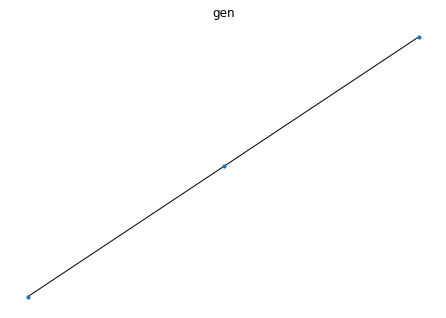

{'LCC': 3,
 'claw_count': 0.0,
 'cpl': 1.3333333333333333,
 'd': 1.3333333333333333,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 2,
 'gini': -0.4999999999999999,
 'n_components': 1,
 'node_num': 3,
 'power_law_exp': 5.328085122666891,
 'rel_edge_distr_entropy': 0.946326365259516,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 1.0}
i count 1
[0. 0. 0. 0. 0. 1. 0. 0. 2. 2.]
Is there DIAG??  0.0


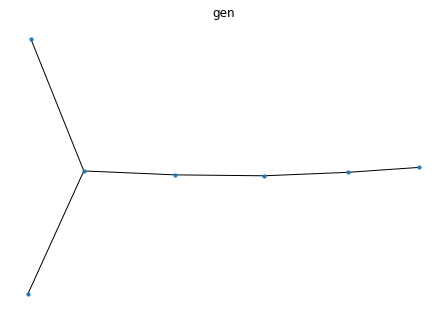

{'LCC': 7,
 'claw_count': 1.0,
 'cpl': 2.4761904761904763,
 'd': 1.7142857142857142,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.0714285714285714,
 'n_components': 1,
 'node_num': 7,
 'power_law_exp': 3.2026058631088743,
 'rel_edge_distr_entropy': 0.9577120798337921,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 6.0}
i count 2
[0. 0. 0. 0. 0. 1. 0. 0. 2. 3.]
Is there DIAG??  0.0


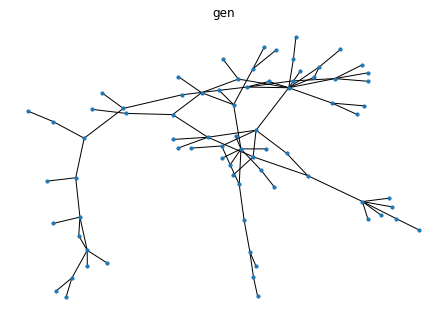

{'LCC': 76,
 'claw_count': 249.0,
 'cpl': 6.415087719298246,
 'd': 2.210526315789474,
 'd_max': 10.0,
 'd_min': 1.0,
 'edge_num': 84,
 'gini': 0.33286340852130336,
 'n_components': 1,
 'node_num': 76,
 'power_law_exp': 2.7351216464482864,
 'rel_edge_distr_entropy': 0.9474673548740912,
 'square_count': 0,
 'triangle_count': 5,
 'wedge_count': 206.0}


In [0]:
for i in range(3):
    print('i count', i)
    print(train_attr_vecs[i])
    a = train_adj_mats[i]
    show_graph(a)

In [0]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [0]:
class Encoder(nn.Module):
    def __init__(self, av_size, d_size, gc_size, z_size, rep_size=32):
        """
        :param av_size: D_A
        :param d_size: D_X
        :param gc_size: D'
        :param z_size: z
        """
        super(Encoder, self).__init__()
        # input parameters
        self.z_size = z_size
        self.attr_vec = None
        self.gc_size = gc_size
        self.d_size = d_size
        self.av_size = av_size
        self.rep_size = rep_size
        
        self.gc = GraphConvolution(d_size + av_size, gc_size) #+ av_size
        self.gc2 = GraphConvolution(gc_size , z_size)#int(gc_size/2))
        self.gc3 = GraphConvolution(gc_size , z_size)#int(gc_size/2))

    
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec

    def forward(self, adj):
        x = get_spectral_embedding(adj, d=self.d_size)
        x = cat_attr(x, self.attr_vec)
        x =F.relu(self.gc(x, adj))
      
        z_mean= self.gc2(x, adj)
        z_logvar = self.gc3(x, adj)
      
        return z_mean, z_logvar

In [0]:
class Decoder(nn.Module):
    def __init__(self, z_out_size, rep_size):
        """
        :param z_out_size: = z_size + len(attr_vec)
        """
        super(Decoder, self).__init__()
        self.z_out_size = z_out_size
        self.rep_size = rep_size

    def forward(self, z):      
        x = z
        x = torch.mm(x, x.t())
        #x = F.sigmoid(x)
        return x

In [0]:
class Generator(nn.Module):
    def __init__(self, av_size, d_size, gc_size, z_size, z_out_size, rep_size):
        """
        :param av_size: D_A
        :param d_size: D_X
        :param gc_size: D' = GCN(D_X + D_A)
        :param z_size: original z size
        :param z_out_size: z size + D_A (append attribute)
        """
        super(Generator, self).__init__()
        self.attr_vec = None
        self.av_size = av_size
        self.d_zize = d_size
        self.z_size = z_size
        self.z_out_size = z_out_size
        self.rep_size = rep_size
        self.encoder = Encoder(av_size, d_size, gc_size, z_size, self.rep_size)
        self.decoder = Decoder(z_out_size, self.rep_size)
    
    def set_attr_vec(self, attr_vec):
        self.attr_vec = attr_vec
        self.encoder.set_attr_vec(attr_vec)
   
    def forward(self, adj, training=True):
        mean, logvar = self.encoder(adj)
        if(training):
            std = logvar.mul(0.5).exp_()
            reparametrized_noise = torch.randn(mean.shape, requires_grad=True).cuda()
            reparametrized_noise = mean + std * reparametrized_noise
        else:
            reparametrized_noise = mean
            # print('mean',mean)
        x = cat_attr(reparametrized_noise, self.attr_vec)
        rec_x = self.decoder(x)
        return mean, logvar, rec_x

In [0]:
def top_n_indexes(arr, n):
    idx = np.argpartition(arr, arr.size-n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]


def topk_adj(adj, k):
    adj_ = adj.data.cpu().numpy()
    assert((adj_ == adj_.T).all())
    # if not (adj_ == adj_.T).all():
    #    print('Not Symmetric')
    #    print(adj_)       
    adj_ = (adj_-np.min(adj_)) / np.ptp(adj_)
    adj_ -= np.diag(np.diag(adj_))
    tri_adj = np.triu(adj_)
    inds = top_n_indexes(tri_adj, k // 2)
    res = torch.zeros(adj.shape)
    for ind in inds:
        i = ind[0]
        j = ind[1]
        res[i, j] = 1.0
        res[j, i] = 1.0
    return res.cuda()


def test_gen(model, n, attr_vec, twice_edge_num):
    fixed_noise = torch.randn((n, z_size), requires_grad=True).cuda()
    if attr_vec is not None:
        fixed_noise = cat_attr(fixed_noise, attr_vec.cuda())
    a_ = model.decoder(fixed_noise)
    #print(F.sigmoid(a_))
    a_ = topk_adj(F.sigmoid(a_), twice_edge_num)
    #print(a_)
    show_graph(a_)

26 data training in total 
[0/30]: vae_loss:4.6268, prior_loss:39.8813
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


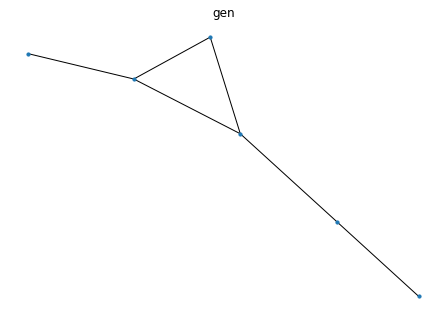

{'LCC': 6,
 'claw_count': 2.0,
 'cpl': 1.9333333333333333,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': 0.04761904761904767,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 2.674331879653742,
 'rel_edge_distr_entropy': 0.8759405003843227,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


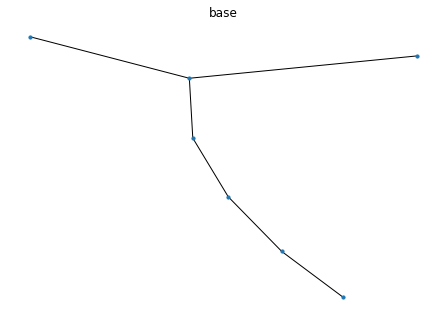

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 1, 2.0, 1.0, 1, 0, 0.5283, 0.119, 0.0818, 1, 0.5429])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


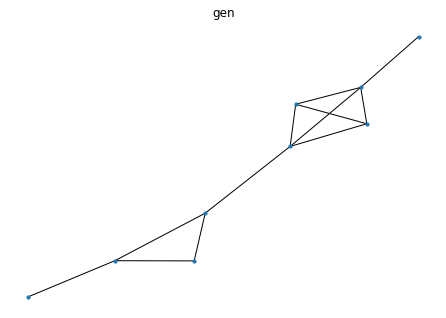

{'LCC': 9,
 'claw_count': 12.0,
 'cpl': 2.25,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.24305555555555558,
 'n_components': 4,
 'node_num': 12,
 'power_law_exp': 2.1450112095572464,
 'rel_edge_distr_entropy': 0.8486636721217414,
 'square_count': 1,
 'triangle_count': 5,
 'wedge_count': 25.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


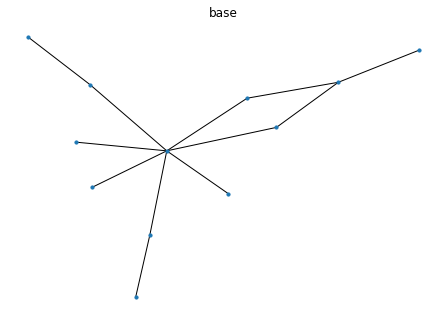

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 3, 3.0, 24.0, 5, 1, 0.9179, 0.0625, 0.0536, 3, 0.1742])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


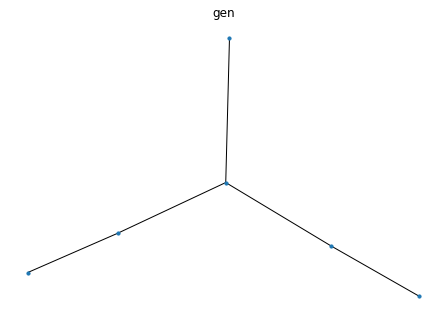

{'LCC': 6,
 'claw_count': 1.0,
 'cpl': 2.066666666666667,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.10000000000000009,
 'n_components': 1,
 'node_num': 6,
 'power_law_exp': 3.414577626291068,
 'rel_edge_distr_entropy': 0.9463784368140203,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


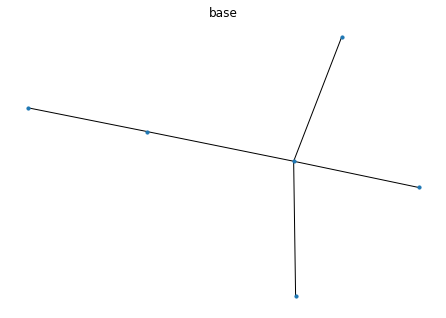

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 0, 2.0, 3.0, 0, 0, 0.4708, 0.0667, 0.0482, 0, 0.2])
Testing set
Is there DIAG??  0.0


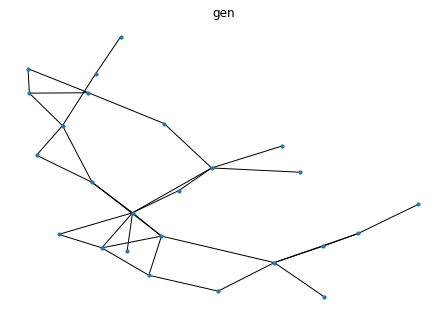

{'LCC': 25,
 'claw_count': 81.0,
 'cpl': 3.3133333333333335,
 'd': 2.2666667,
 'd_max': 7.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.3578431372549018,
 'n_components': 6,
 'node_num': 30,
 'power_law_exp': 2.1977348303475854,
 'rel_edge_distr_entropy': 0.9004261840932528,
 'square_count': 0,
 'triangle_count': 8,
 'wedge_count': 89.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


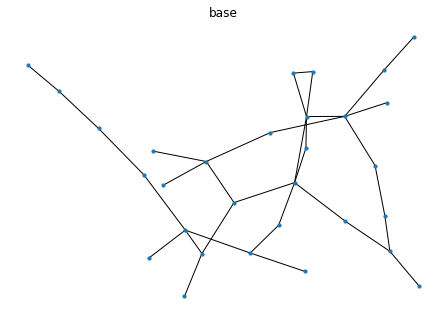

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 5, 23.0, 39.0, 6, 0, 0.2791, 0.1382, 0.0589, 5, 0.8775])
Is there DIAG??  0.0


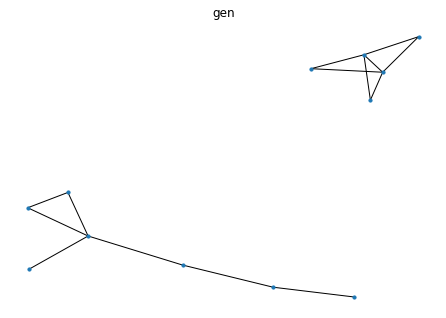

{'LCC': 7,
 'claw_count': 12.0,
 'cpl': 1.8709677419354838,
 'd': 2.3333333,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.0535714285714286,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.33171849928212,
 'rel_edge_distr_entropy': 0.9623951418196145,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 25.0}
Is there DIAG on base??  0.0


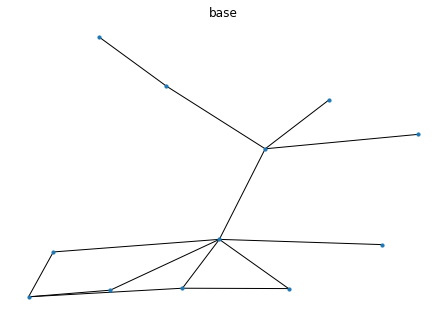

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 5, 6.0, 14.0, 3, 0, 0.1411, 0.0952, 0.0301, 1, 0.5078])
Is there DIAG??  0.0


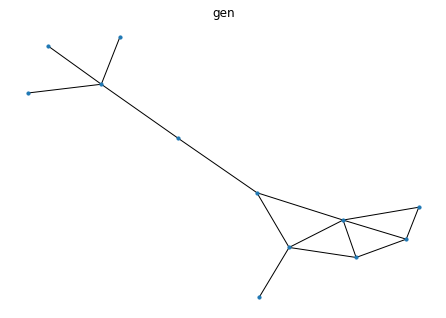

{'LCC': 12,
 'claw_count': 21.0,
 'cpl': 2.787878787878788,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.30222222222222217,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.3238957422150968,
 'rel_edge_distr_entropy': 0.8645467922082983,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 33.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


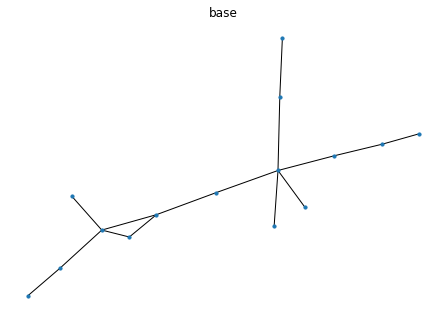

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 3, 8.0, 6.0, 3, 0, 0.4936, 0.1467, 0.0811, 3, 0.6597])
Is there DIAG??  0.0


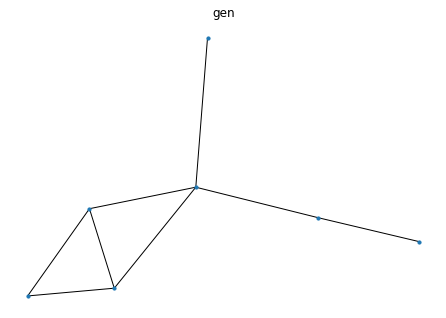

{'LCC': 7,
 'claw_count': 6.0,
 'cpl': 1.9523809523809523,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.19444444444444442,
 'n_components': 3,
 'node_num': 9,
 'power_law_exp': 2.408503615336456,
 'rel_edge_distr_entropy': 0.837740964716753,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 14.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


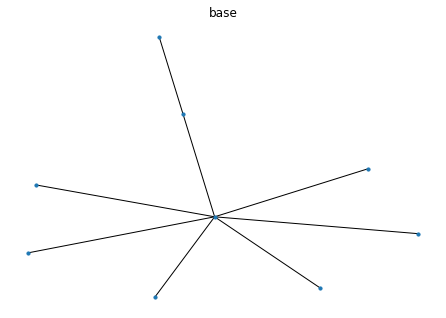

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 2, 8.0, 29.0, 2, 0, 2.0018, 0.0417, 0.0028, 2, 0.0079])
26 data training in total 
[1/30]: vae_loss:3.7464, prior_loss:8.8814
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


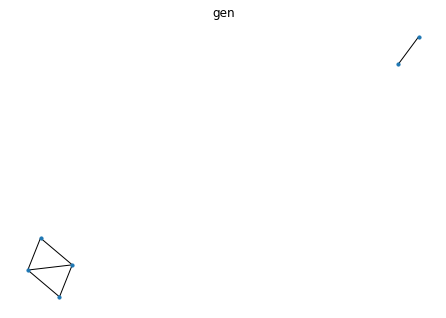

{'LCC': 4,
 'claw_count': 2.0,
 'cpl': 1.1428571428571428,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': 0.04761904761904767,
 'n_components': 3,
 'node_num': 7,
 'power_law_exp': 2.674331879653742,
 'rel_edge_distr_entropy': 0.8759405616457789,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


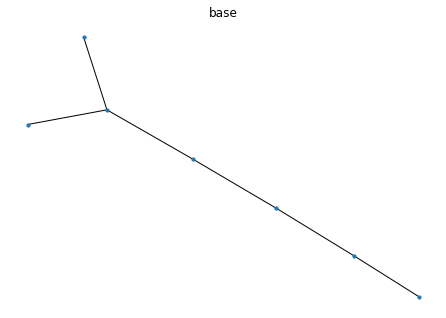

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 3, 2.0, 1.0, 2, 0, 0.5283, 0.119, 0.0818, 2, 1.3333])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


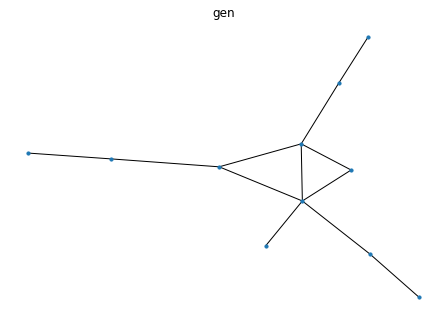

{'LCC': 11,
 'claw_count': 15.0,
 'cpl': 2.5454545454545454,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.19444444444444442,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.6018795500591496,
 'rel_edge_distr_entropy': 0.9027638874227625,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 23.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


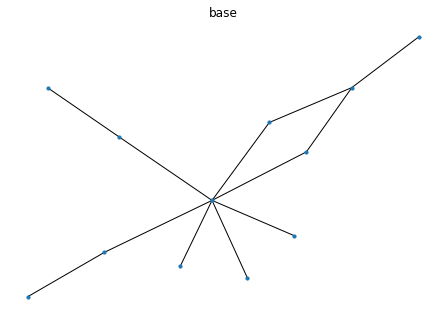

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 1, 5.0, 21.0, 2, 0, 0.461, 0.0139, 0.0005, 1, 0.1212])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


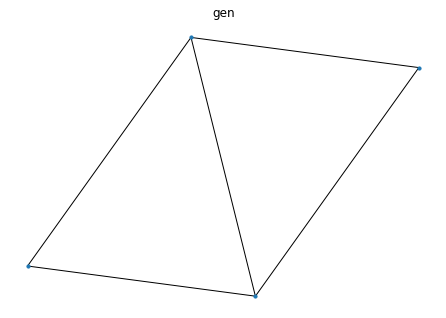

{'LCC': 4,
 'claw_count': 2.0,
 'cpl': 1.1666666666666667,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 5,
 'gini': 0.06666666666666665,
 'n_components': 3,
 'node_num': 6,
 'power_law_exp': 2.1162212531024944,
 'rel_edge_distr_entropy': 0.7624454796474622,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


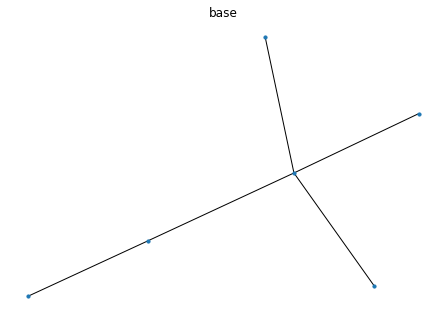

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 2, 1.0, 2.0, 2, 0, 1.7692, 0.1, 0.1358, 2, 0.7])
Testing set
Is there DIAG??  0.0


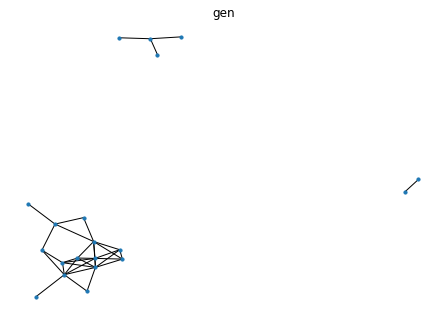

{'LCC': 14,
 'claw_count': 194.99999999999997,
 'cpl': 1.8877551020408163,
 'd': 2.2666667,
 'd_max': 8.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.5215686274509803,
 'n_components': 13,
 'node_num': 30,
 'power_law_exp': 2.0594090179141435,
 'rel_edge_distr_entropy': 0.8099686531071654,
 'square_count': 11,
 'triangle_count': 25,
 'wedge_count': 137.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


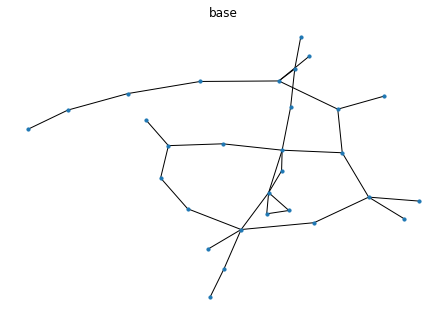

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 16, 71.0, 153.0, 23, 11, 0.4175, 0.302, 0.1494, 12, 2.303])
Is there DIAG??  0.0


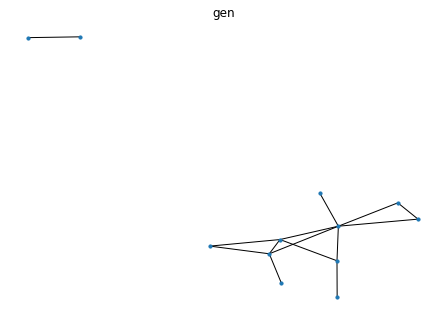

{'LCC': 10,
 'claw_count': 29.0,
 'cpl': 2.0,
 'd': 2.3333333,
 'd_max': 6.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.1785714285714286,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.549906600843973,
 'rel_edge_distr_entropy': 0.91990956172368,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 33.0}
Is there DIAG on base??  0.0


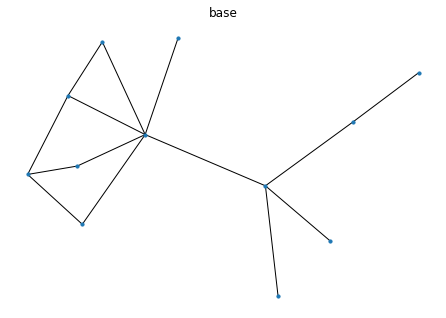

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 0.0, 0.0, 0, 0, 2, 2.0, 3.0, 3, 0, 0.0771, 0.0298, 0.0124, 1, 0.3788])
Is there DIAG??  0.0


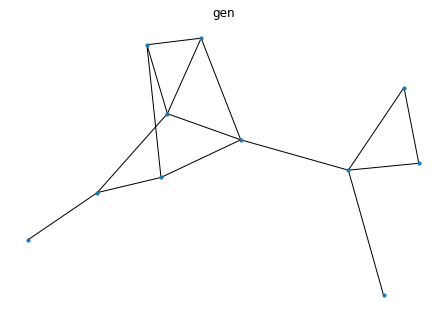

{'LCC': 11,
 'claw_count': 16.0,
 'cpl': 2.4,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.288888888888889,
 'n_components': 5,
 'node_num': 15,
 'power_law_exp': 2.1066814120500728,
 'rel_edge_distr_entropy': 0.854776741952476,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 32.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


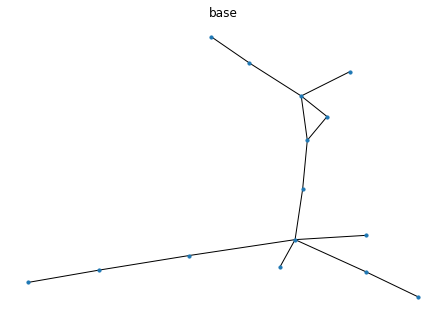

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 4, 7.0, 1.0, 2, 0, 0.7108, 0.1333, 0.0909, 4, 1.0476])
Is there DIAG??  0.0


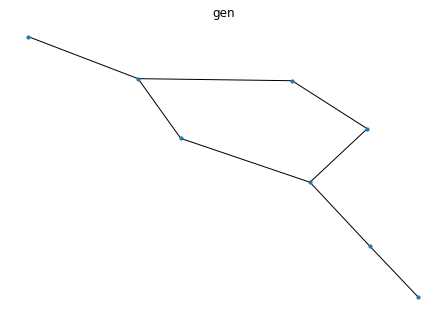

{'LCC': 8,
 'claw_count': 2.0,
 'cpl': 2.25,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.05555555555555558,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 2.609718417527379,
 'rel_edge_distr_entropy': 0.9166043628966368,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 10.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


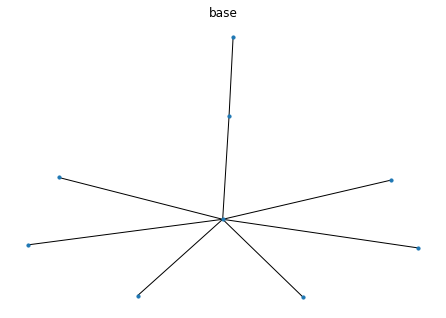

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 1, 12.0, 33.0, 0, 0, 1.8006, 0.0972, 0.0817, 1, 0.3056])
26 data training in total 
[2/30]: vae_loss:4.8117, prior_loss:5.1884
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


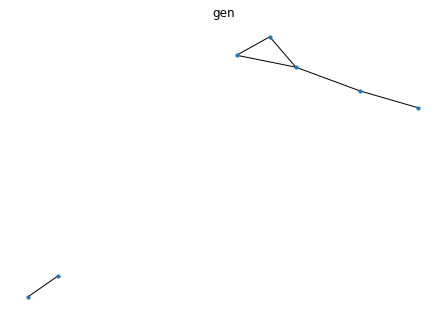

{'LCC': 5,
 'claw_count': 1.0,
 'cpl': 1.6363636363636365,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.0714285714285714,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 3.2026058631088743,
 'rel_edge_distr_entropy': 0.9577121084628163,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 6.0}
Is there DIAG on base??  0.0


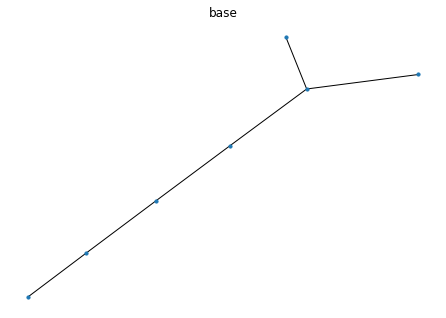

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 0.0, 0.0, 0, 0, 2, 0.0, 0.0, 1, 0, 0.0, 0.0, 0.0, 1, 0.8398])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


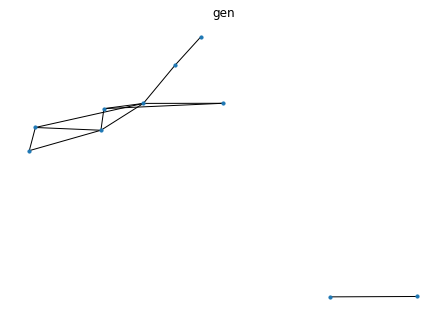

{'LCC': 8,
 'claw_count': 16.0,
 'cpl': 1.8620689655172413,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.24305555555555558,
 'n_components': 4,
 'node_num': 12,
 'power_law_exp': 2.3750621817166464,
 'rel_edge_distr_entropy': 0.8707465714264453,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 25.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


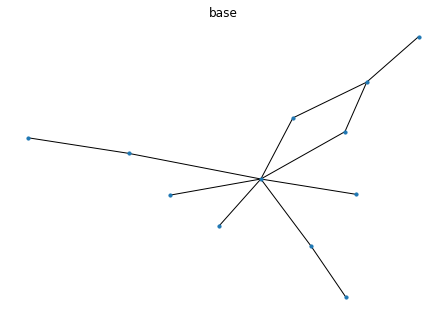

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 4, 3.0, 20.0, 4, 0, 0.6878, 0.0625, 0.0315, 3, 0.5622])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


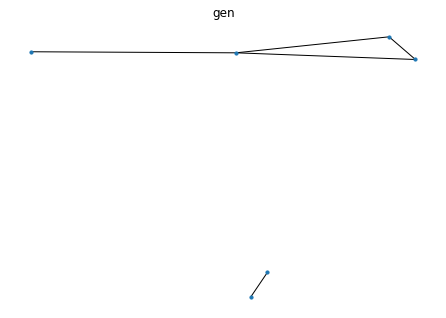

{'LCC': 4,
 'claw_count': 1.0,
 'cpl': 1.2857142857142858,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.10000000000000009,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 3.414577626291068,
 'rel_edge_distr_entropy': 0.9463784368140203,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


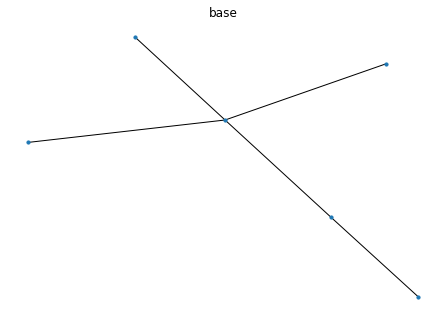

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 2, 2.0, 3.0, 1, 0, 0.4708, 0.0667, 0.0482, 1, 0.581])
Testing set
Is there DIAG??  0.0


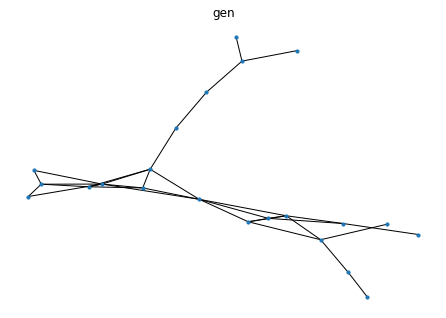

{'LCC': 22,
 'claw_count': 101.0,
 'cpl': 3.601731601731602,
 'd': 2.2666667,
 'd_max': 7.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.42450980392156845,
 'n_components': 9,
 'node_num': 30,
 'power_law_exp': 2.050757706420617,
 'rel_edge_distr_entropy': 0.8632936464749981,
 'square_count': 3,
 'triangle_count': 16,
 'wedge_count': 103.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


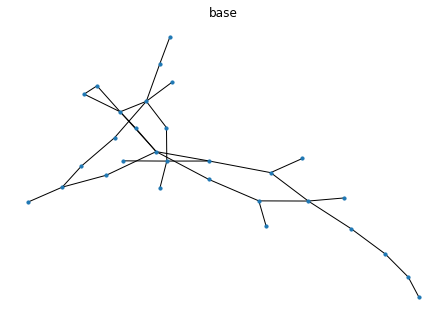

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 8, 37.0, 59.0, 14, 3, 0.4261, 0.2049, 0.096, 8, 0.5891])
Is there DIAG??  0.0


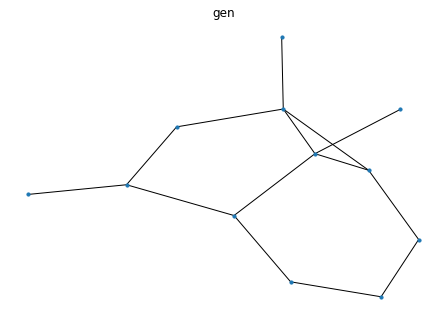

{'LCC': 12,
 'claw_count': 11.0,
 'cpl': 2.409090909090909,
 'd': 2.3333333,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.07738095238095255,
 'n_components': 1,
 'node_num': 12,
 'power_law_exp': 2.357310324197768,
 'rel_edge_distr_entropy': 0.9597585266557128,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 25.0}
Is there DIAG on base??  0.0


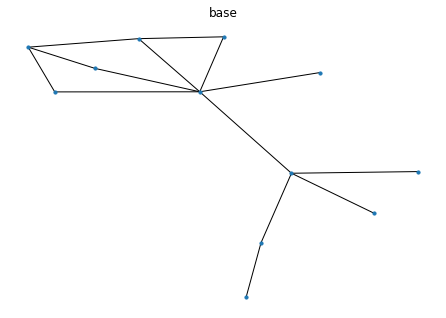

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 0, 6.0, 15.0, 0, 0, 0.1155, 0.0714, 0.0274, 0, 0.0303])
Is there DIAG??  0.0


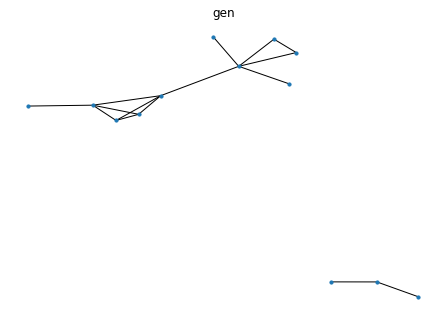

{'LCC': 10,
 'claw_count': 20.0,
 'cpl': 2.125,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.2711111111111111,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.501381371276859,
 'rel_edge_distr_entropy': 0.8880500438956077,
 'square_count': 1,
 'triangle_count': 5,
 'wedge_count': 31.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


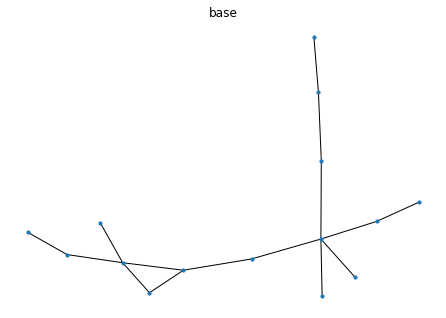

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 5, 6.0, 5.0, 4, 1, 0.3161, 0.1156, 0.0576, 3, 1.3226])
Is there DIAG??  0.0


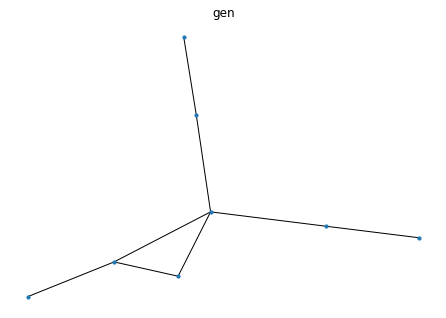

{'LCC': 8,
 'claw_count': 5.0,
 'cpl': 2.2142857142857144,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.125,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 2.752714662512919,
 'rel_edge_distr_entropy': 0.8920549676513547,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 12.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


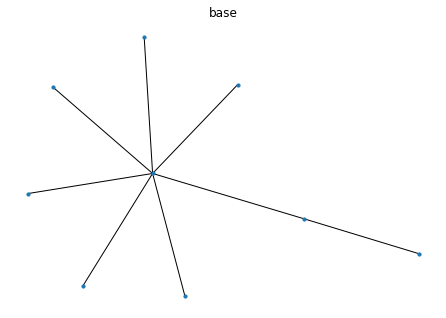

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 1, 10.0, 30.0, 1, 0, 1.6576, 0.0278, 0.0571, 1, 0.2698])
26 data training in total 
[3/30]: vae_loss:12.1998, prior_loss:2.4509
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


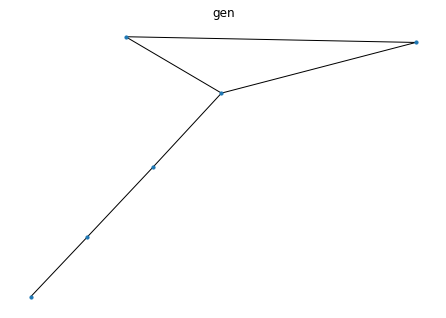

{'LCC': 6,
 'claw_count': 1.0,
 'cpl': 2.066666666666667,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': -0.023809523809523725,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 2.549906600843973,
 'rel_edge_distr_entropy': 0.8983485320836201,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 7.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


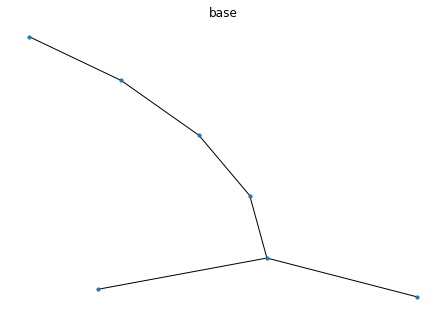

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 1, 1.0, 0.0, 1, 0, 0.6527, 0.0476, 0.0594, 1, 0.4095])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


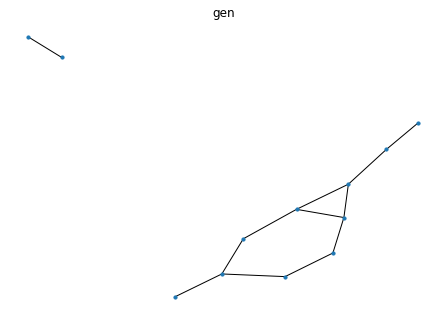

{'LCC': 10,
 'claw_count': 4.0,
 'cpl': 2.5217391304347827,
 'd': 2.0,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 12,
 'gini': 0.05555555555555558,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.6743318796537414,
 'rel_edge_distr_entropy': 0.9648849585409844,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 16.0}
Is there DIAG on base??  0.0


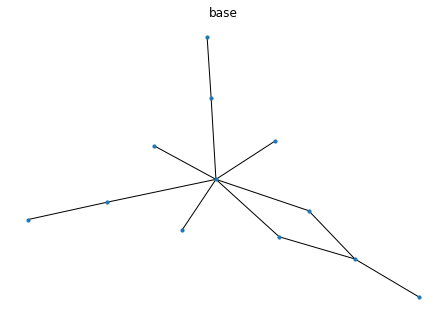

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 0.0, 0.0, 0, 0, 2, 12.0, 32.0, 1, 0, 0.3885, 0.125, 0.0626, 1, 0.0975])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


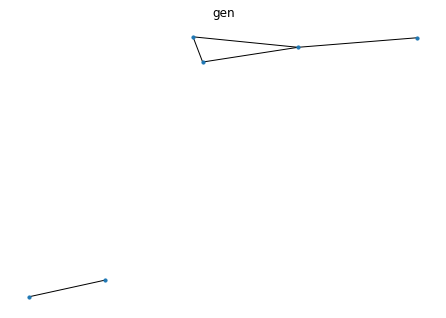

{'LCC': 4,
 'claw_count': 1.0,
 'cpl': 1.2857142857142858,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.10000000000000009,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 3.414577626291068,
 'rel_edge_distr_entropy': 0.9463784368140203,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


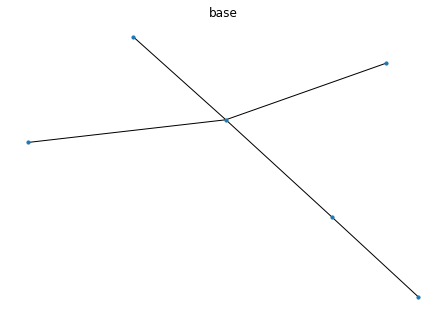

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 2, 2.0, 3.0, 1, 0, 0.4708, 0.0667, 0.0482, 1, 0.581])
Testing set
Is there DIAG??  0.0


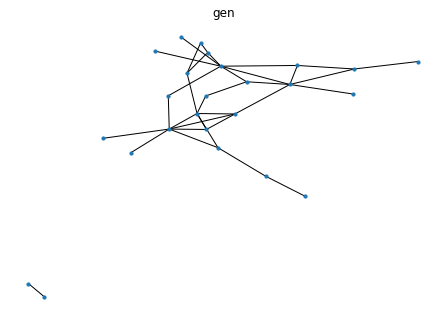

{'LCC': 23,
 'claw_count': 121.0,
 'cpl': 2.8464566929133857,
 'd': 2.2666667,
 'd_max': 7.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.40098039215686265,
 'n_components': 7,
 'node_num': 30,
 'power_law_exp': 2.293693974478612,
 'rel_edge_distr_entropy': 0.8821241863458578,
 'square_count': 1,
 'triangle_count': 9,
 'wedge_count': 103.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


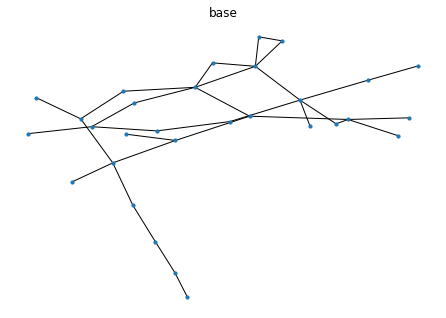

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 7, 37.0, 79.0, 7, 1, 0.1832, 0.1814, 0.0772, 6, 1.3443])
Is there DIAG??  0.0


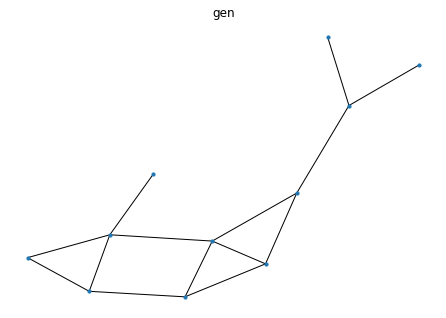

{'LCC': 11,
 'claw_count': 13.0,
 'cpl': 2.5454545454545454,
 'd': 2.3333333,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.125,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.227843378412744,
 'rel_edge_distr_entropy': 0.9247946876723717,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 28.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


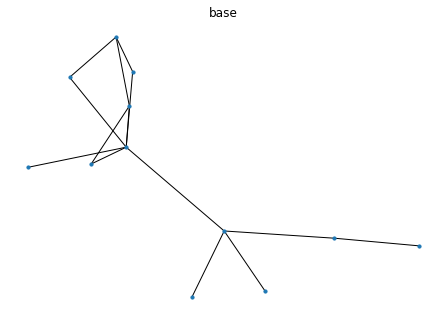

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 1, 3.0, 13.0, 2, 0, 0.2449, 0.0238, 0.0075, 1, 0.1667])
Is there DIAG??  0.0


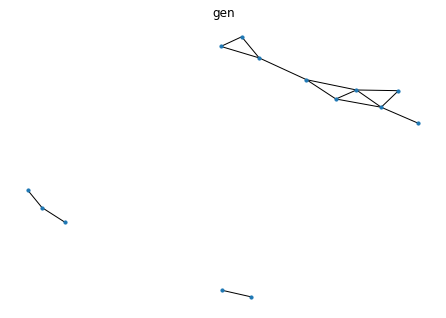

{'LCC': 9,
 'claw_count': 11.0,
 'cpl': 2.2,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.18666666666666676,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.583528711564063,
 'rel_edge_distr_entropy': 0.9294692216440752,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 25.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


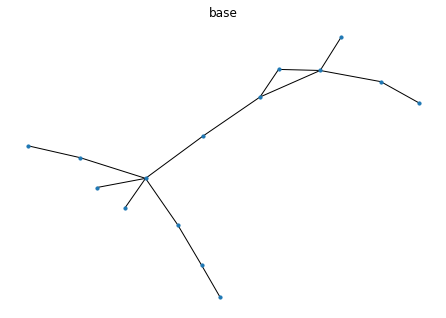

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 6, 0.0, 4.0, 3, 0, 0.2339, 0.0311, 0.0162, 3, 1.2476])
Is there DIAG??  0.0


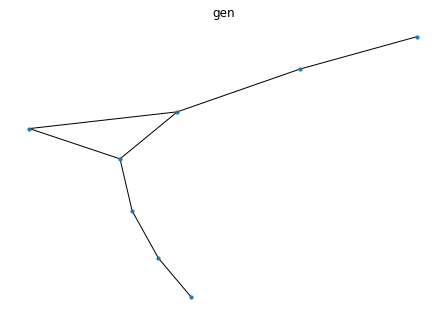

{'LCC': 8,
 'claw_count': 2.0,
 'cpl': 2.5714285714285716,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.05555555555555558,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 2.609718417527379,
 'rel_edge_distr_entropy': 0.9166043628966368,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 10.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


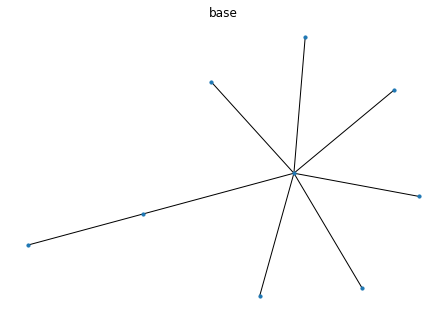

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 1, 12.0, 33.0, 1, 0, 1.8006, 0.0972, 0.0817, 1, 0.627])
26 data training in total 
[4/30]: vae_loss:10.8442, prior_loss:1.7181
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


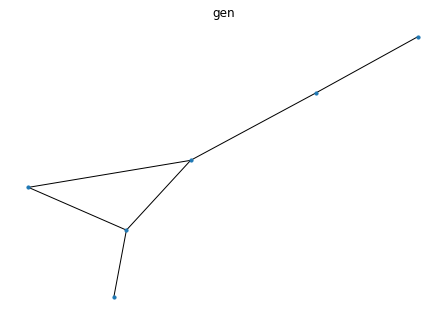

{'LCC': 6,
 'claw_count': 2.0,
 'cpl': 1.9333333333333333,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': 0.04761904761904767,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 2.674331879653742,
 'rel_edge_distr_entropy': 0.8759404391228663,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


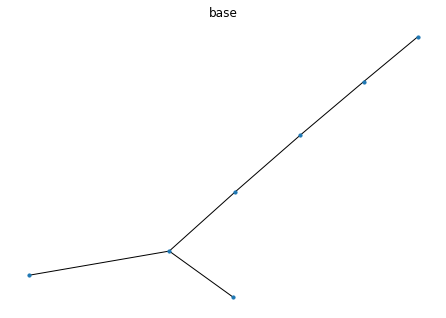

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 1, 2.0, 1.0, 1, 0, 0.5283, 0.119, 0.0818, 1, 0.5429])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


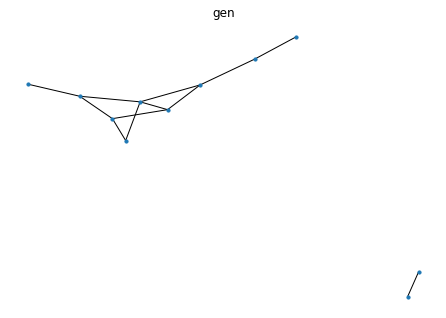

{'LCC': 9,
 'claw_count': 8.0,
 'cpl': 2.189189189189189,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.1527777777777779,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.5348042230159296,
 'rel_edge_distr_entropy': 0.9183960026184926,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 20.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


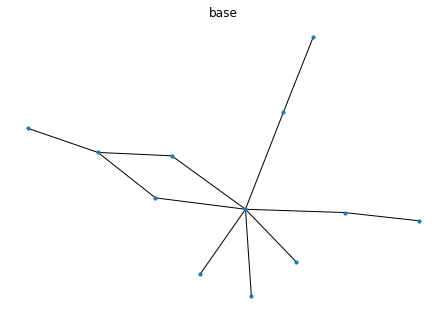

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 3, 8.0, 28.0, 1, 0, 0.5281, 0.0278, 0.0161, 2, 0.2351])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


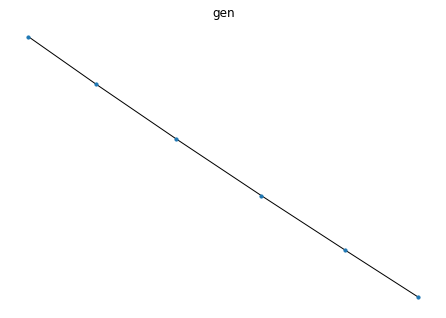

{'LCC': 6,
 'claw_count': 0.0,
 'cpl': 2.3333333333333335,
 'd': 1.6666666,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.20000000000000007,
 'n_components': 1,
 'node_num': 6,
 'power_law_exp': 3.1640425613334453,
 'rel_edge_distr_entropy': 0.9755815145647054,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 4.0}
Is there DIAG on base??  0.0


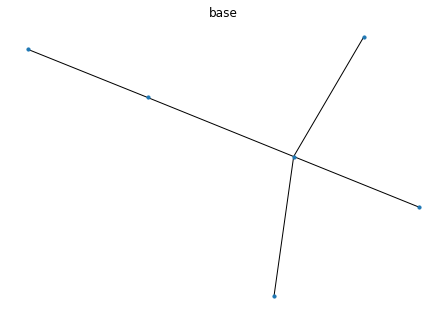

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 0, 3.0, 4.0, 0, 0, 0.7213, 0.1667, 0.0774, 0, 0.4667])
Testing set
Is there DIAG??  0.0


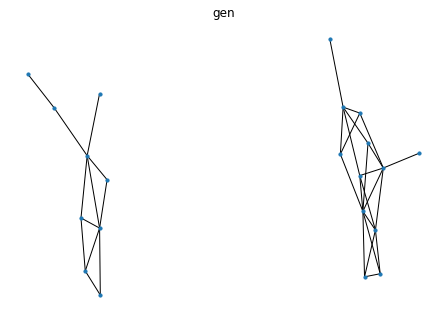

{'LCC': 12,
 'claw_count': 106.0,
 'cpl': 1.9509803921568627,
 'd': 2.2666667,
 'd_max': 7.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.4352941176470586,
 'n_components': 11,
 'node_num': 30,
 'power_law_exp': 1.9844622237454432,
 'rel_edge_distr_entropy': 0.8543220995689489,
 'square_count': 2,
 'triangle_count': 14,
 'wedge_count': 106.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


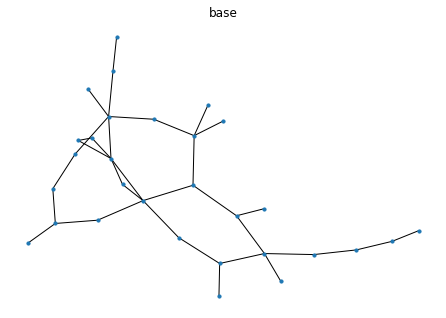

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 18, 40.0, 64.0, 12, 2, 0.4924, 0.2157, 0.105, 10, 2.2398])
Is there DIAG??  0.0


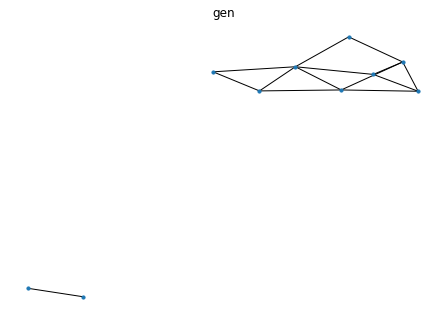

{'LCC': 8,
 'claw_count': 21.0,
 'cpl': 1.5862068965517242,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.20833333333333348,
 'n_components': 4,
 'node_num': 12,
 'power_law_exp': 2.103246451845914,
 'rel_edge_distr_entropy': 0.8839521947191525,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 33.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


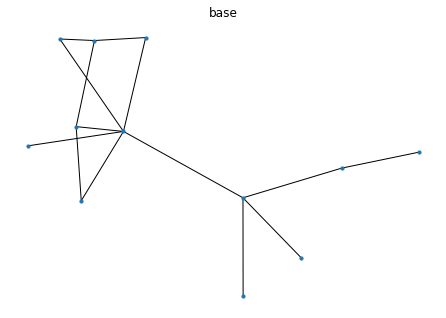

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 4, 2.0, 5.0, 3, 0, 0.3695, 0.0595, 0.0484, 3, 0.7926])
Is there DIAG??  0.0


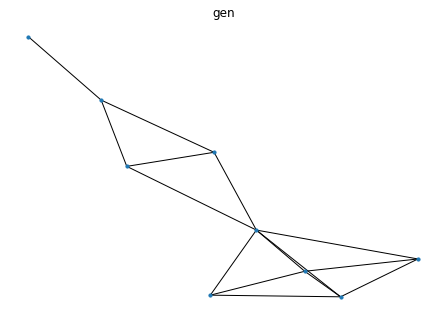

{'LCC': 9,
 'claw_count': 33.0,
 'cpl': 1.9444444444444444,
 'd': 2.0,
 'd_max': 6.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.37777777777777777,
 'n_components': 7,
 'node_num': 15,
 'power_law_exp': 1.8948626263418045,
 'rel_edge_distr_entropy': 0.7842656662803593,
 'square_count': 2,
 'triangle_count': 9,
 'wedge_count': 42.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


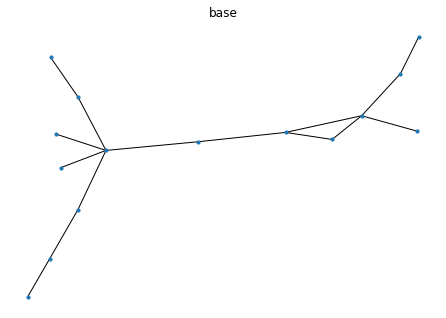

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 6, 17.0, 18.0, 8, 2, 0.9226, 0.2222, 0.1614, 6, 1.5032])
Is there DIAG??  0.0


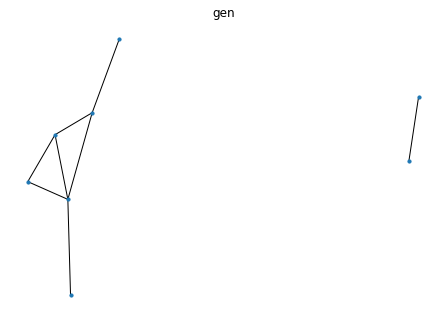

{'LCC': 6,
 'claw_count': 6.0,
 'cpl': 1.625,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.15277777777777768,
 'n_components': 3,
 'node_num': 9,
 'power_law_exp': 2.8706159838918133,
 'rel_edge_distr_entropy': 0.8771712260628222,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 13.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


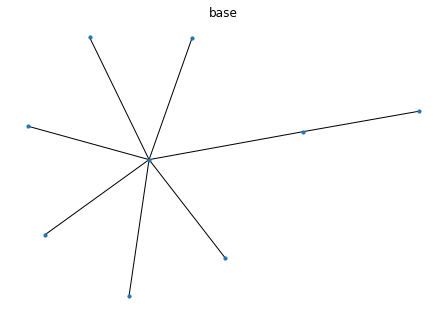

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 3, 9.0, 29.0, 2, 0, 1.5397, 0.0, 0.0422, 2, 0.3194])
26 data training in total 
[5/30]: vae_loss:4.4093, prior_loss:1.4246
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


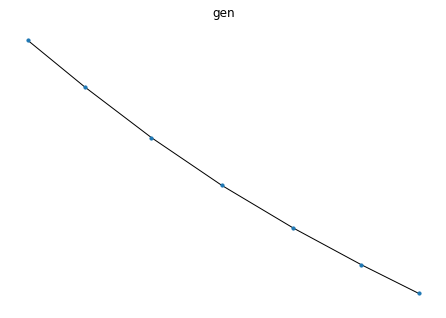

{'LCC': 7,
 'claw_count': 0.0,
 'cpl': 2.6666666666666665,
 'd': 1.7142857,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.16666666666666663,
 'n_components': 1,
 'node_num': 7,
 'power_law_exp': 3.019773057244549,
 'rel_edge_distr_entropy': 0.98012020142357,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


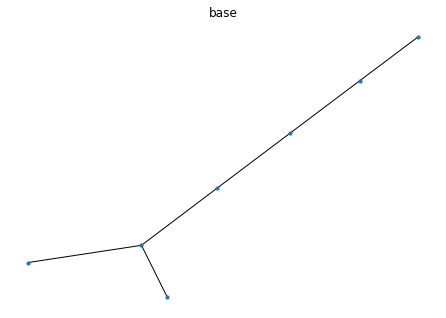

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 0, 1.0, 1.0, 0, 0, 0.1828, 0.0952, 0.0224, 0, 0.1905])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


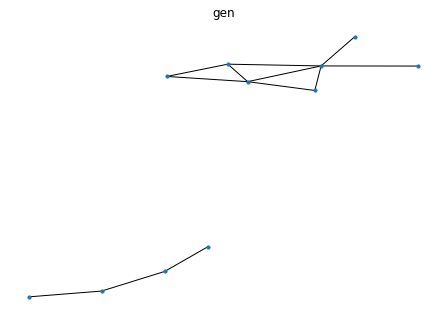

{'LCC': 7,
 'claw_count': 15.0,
 'cpl': 1.6666666666666667,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.19444444444444442,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.6018795500591496,
 'rel_edge_distr_entropy': 0.9027638874227625,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 23.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


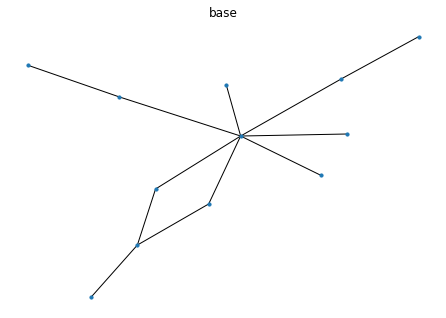

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 5, 5.0, 21.0, 3, 0, 0.461, 0.0139, 0.0005, 2, 0.7576])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


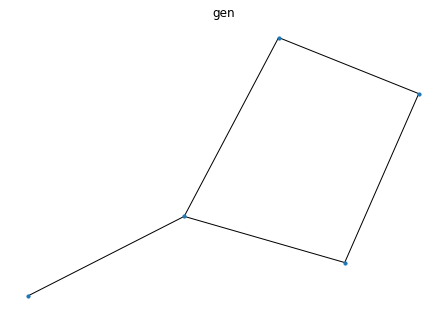

{'LCC': 5,
 'claw_count': 1.0,
 'cpl': 1.6,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 5,
 'gini': -0.03333333333333344,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 2.5732899022206244,
 'rel_edge_distr_entropy': 0.8690135303720694,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 6.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


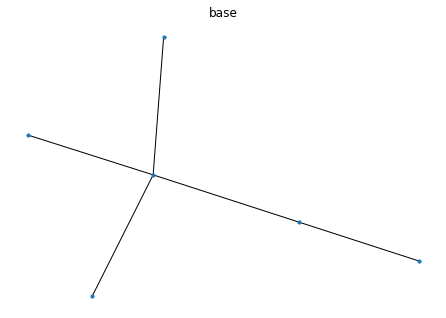

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 1, 1.0, 3.0, 0, 0, 1.3121, 0.0, 0.0292, 1, 0.2667])
Testing set
Is there DIAG??  0.0


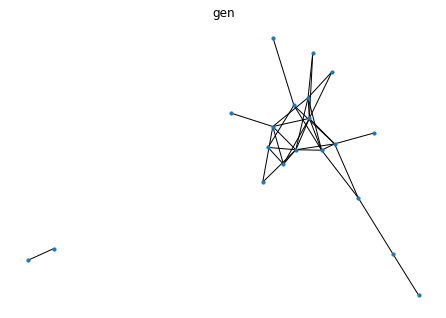

{'LCC': 18,
 'claw_count': 202.0,
 'cpl': 2.4805194805194803,
 'd': 2.2666667,
 'd_max': 8.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.5215686274509803,
 'n_components': 12,
 'node_num': 30,
 'power_law_exp': 2.04885993481375,
 'rel_edge_distr_entropy': 0.8103721396406749,
 'square_count': 4,
 'triangle_count': 19,
 'wedge_count': 138.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


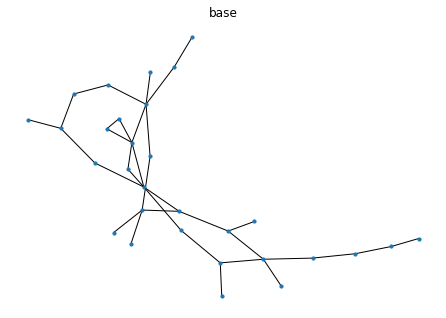

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 12, 72.0, 160.0, 17, 4, 0.428, 0.302, 0.1489, 11, 1.7103])
Is there DIAG??  0.0


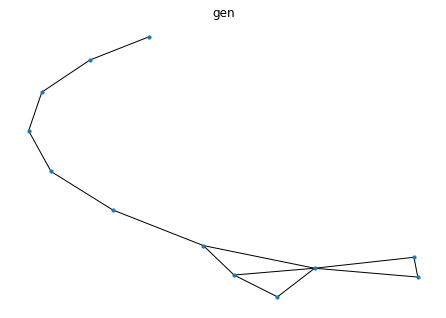

{'LCC': 12,
 'claw_count': 12.0,
 'cpl': 3.5,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.011904761904762085,
 'n_components': 1,
 'node_num': 12,
 'power_law_exp': 2.283169952048856,
 'rel_edge_distr_entropy': 0.9711678359346441,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 24.0}
Is there DIAG on base??  0.0


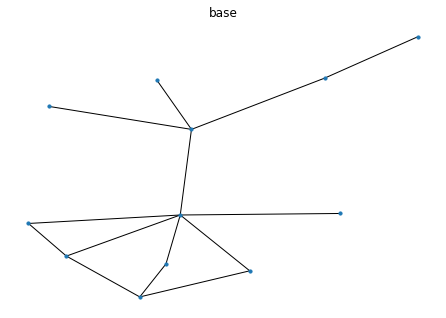

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 0, 7.0, 14.0, 2, 0, 0.1896, 0.1369, 0.0389, 0, 1.1212])
Is there DIAG??  0.0


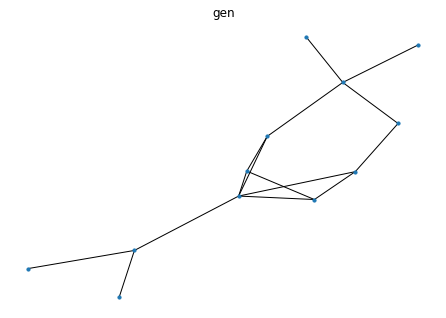

{'LCC': 12,
 'claw_count': 19.0,
 'cpl': 2.4696969696969697,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.2844444444444445,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.306913226083471,
 'rel_edge_distr_entropy': 0.868729340756611,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 32.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


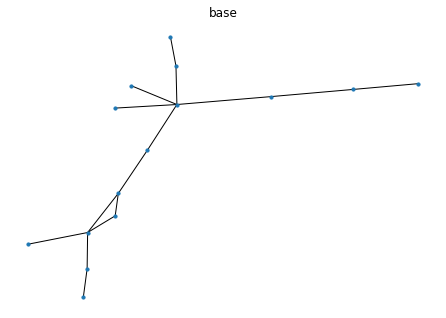

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 3, 7.0, 4.0, 2, 0, 0.5106, 0.1289, 0.077, 3, 0.9779])
Is there DIAG??  0.0


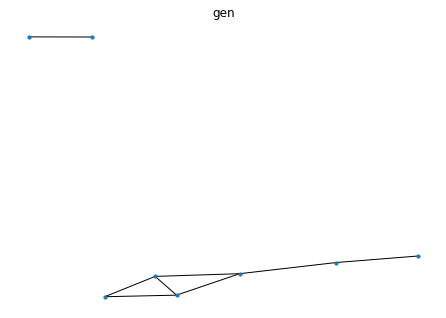

{'LCC': 6,
 'claw_count': 3.0,
 'cpl': 1.8125,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.0972222222222221,
 'n_components': 3,
 'node_num': 9,
 'power_law_exp': 2.7086236185895256,
 'rel_edge_distr_entropy': 0.9017205670536185,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 11.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


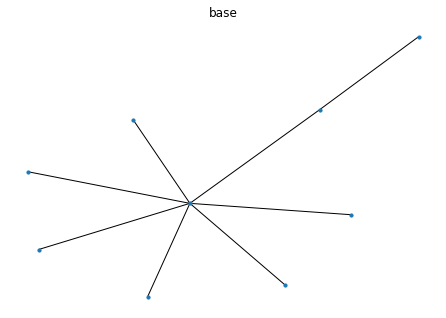

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 3, 11.0, 32.0, 2, 0, 1.7017, 0.0556, 0.0668, 2, 0.1319])
26 data training in total 
[6/30]: vae_loss:7.5554, prior_loss:1.0416
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


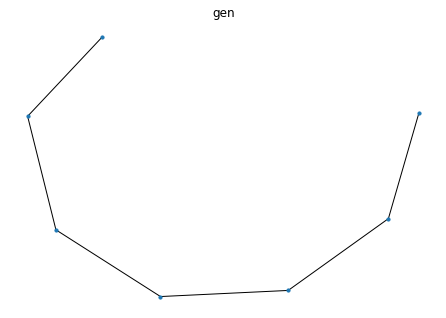

{'LCC': 7,
 'claw_count': 0.0,
 'cpl': 2.6666666666666665,
 'd': 1.7142857,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.16666666666666663,
 'n_components': 1,
 'node_num': 7,
 'power_law_exp': 3.019773057244549,
 'rel_edge_distr_entropy': 0.98012020142357,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


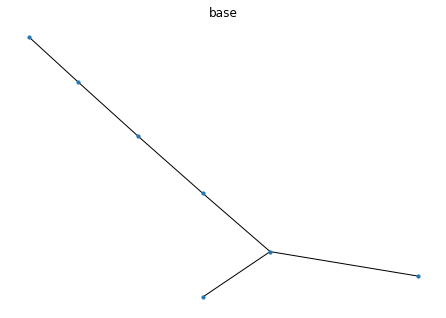

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 0, 1.0, 1.0, 0, 0, 0.1828, 0.0952, 0.0224, 0, 0.1905])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


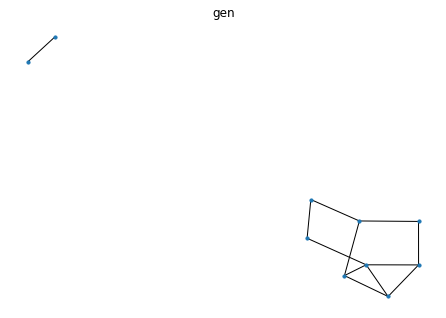

{'LCC': 8,
 'claw_count': 8.0,
 'cpl': 1.6896551724137931,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.17361111111111116,
 'n_components': 4,
 'node_num': 12,
 'power_law_exp': 2.2722346772858293,
 'rel_edge_distr_entropy': 0.8951523402041497,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 21.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


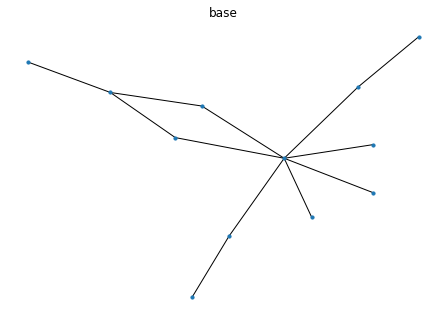

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 4, 7.0, 28.0, 2, 0, 0.7906, 0.0069, 0.0071, 3, 0.7346])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


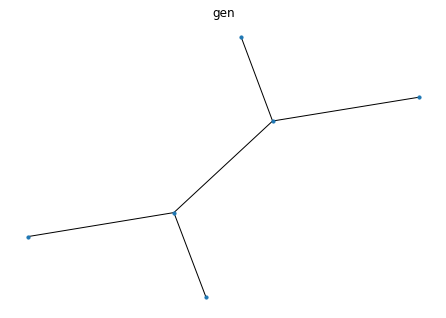

{'LCC': 6,
 'claw_count': 2.0,
 'cpl': 1.9333333333333333,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.06666666666666665,
 'n_components': 1,
 'node_num': 6,
 'power_law_exp': 3.730717679880512,
 'rel_edge_distr_entropy': 0.9171753590633354,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 6.0}
Is there DIAG on base??  0.0


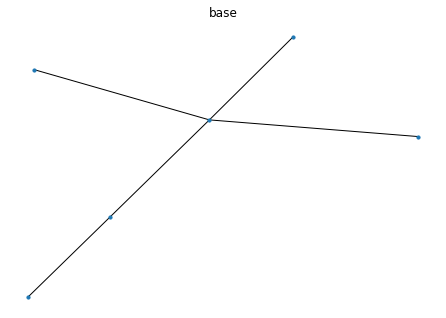

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 0, 1.0, 2.0, 0, 0, 0.1547, 0.0333, 0.019, 0, 0.0667])
Testing set
Is there DIAG??  0.0


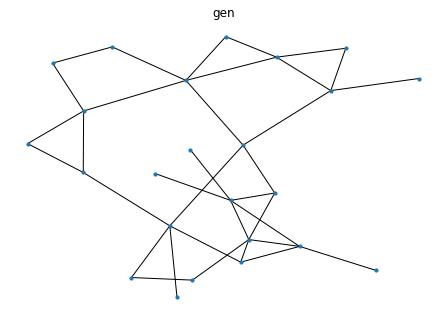

{'LCC': 24,
 'claw_count': 63.0,
 'cpl': 3.1340579710144927,
 'd': 2.2666667,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.3558823529411763,
 'n_components': 7,
 'node_num': 30,
 'power_law_exp': 2.115392432118174,
 'rel_edge_distr_entropy': 0.8968204613151667,
 'square_count': 0,
 'triangle_count': 6,
 'wedge_count': 86.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


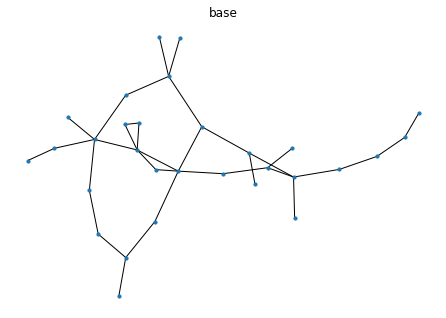

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 6, 20.0, 21.0, 4, 0, 0.3615, 0.1363, 0.0625, 6, 1.0567])
Is there DIAG??  0.0


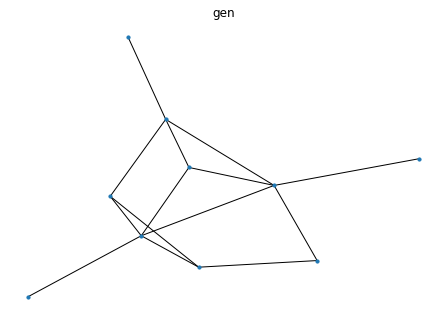

{'LCC': 10,
 'claw_count': 27.0,
 'cpl': 1.9333333333333333,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.24404761904761907,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.163581631118821,
 'rel_edge_distr_entropy': 0.867916527726502,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 36.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


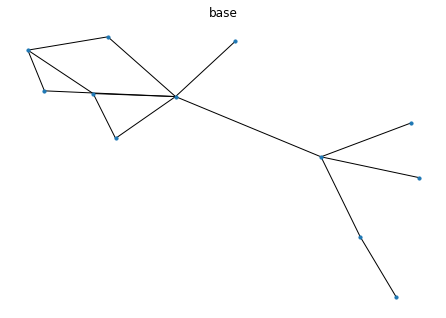

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 2, 5.0, 1.0, 2, 0, 0.3092, 0.0952, 0.0644, 2, 0.4455])
Is there DIAG??  0.0


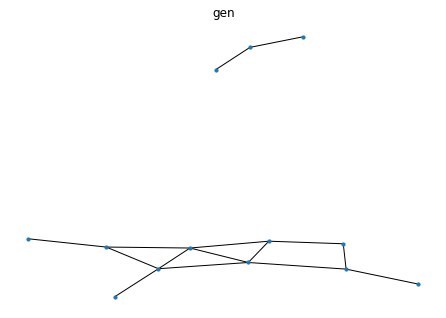

{'LCC': 10,
 'claw_count': 15.0,
 'cpl': 2.1875,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.24888888888888894,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.4704195178809156,
 'rel_edge_distr_entropy': 0.8953427174784984,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 29.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


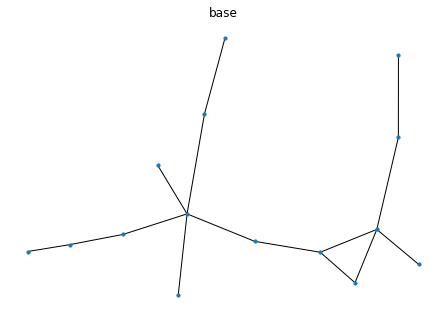

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 5, 4.0, 0.0, 2, 0, 0.3471, 0.0933, 0.0503, 3, 1.2601])
Is there DIAG??  0.0


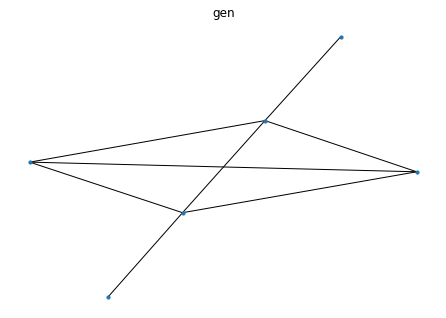

{'LCC': 6,
 'claw_count': 10.0,
 'cpl': 1.5333333333333334,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.2777777777777777,
 'n_components': 4,
 'node_num': 9,
 'power_law_exp': 2.207288813145534,
 'rel_edge_distr_entropy': 0.7588775665368691,
 'square_count': 1,
 'triangle_count': 4,
 'wedge_count': 18.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


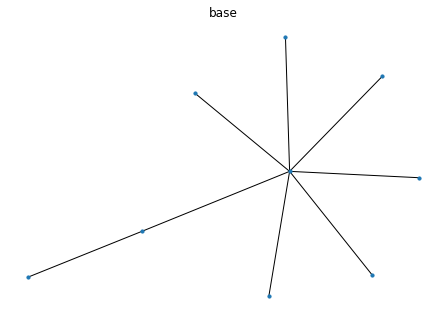

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 3, 4.0, 25.0, 4, 1, 2.203, 0.125, 0.0761, 3, 0.4111])
26 data training in total 
[7/30]: vae_loss:3.0057, prior_loss:0.9853
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


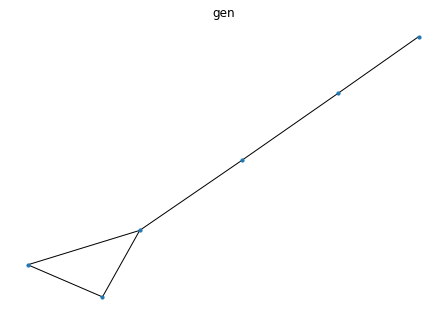

{'LCC': 6,
 'claw_count': 1.0,
 'cpl': 2.066666666666667,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': -0.023809523809523725,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 2.549906600843973,
 'rel_edge_distr_entropy': 0.8983485320836201,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 7.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


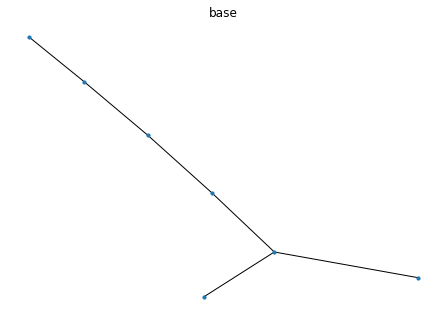

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 1, 1.0, 0.0, 1, 0, 0.6527, 0.0476, 0.0594, 1, 0.4095])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


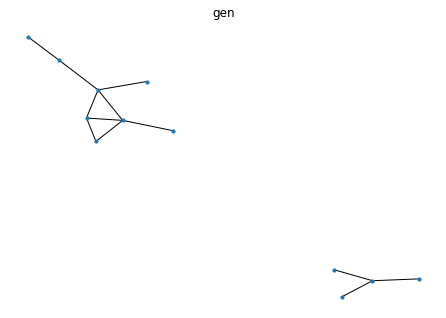

{'LCC': 8,
 'claw_count': 10.0,
 'cpl': 1.9705882352941178,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 12,
 'gini': 0.13888888888888906,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.887947882664749,
 'rel_edge_distr_entropy': 0.9359419665287186,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 20.0}
Is there DIAG on base??  0.0


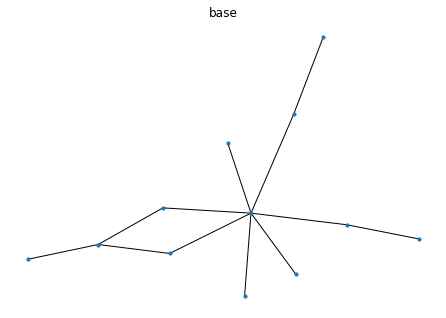

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 0.0, 0.0, 0, 0, 4, 8.0, 26.0, 2, 0, 0.1749, 0.0417, 0.0337, 1, 0.4537])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


{'LCC': 6,
 'claw_count': 1.0,
 'cpl': 2.1333333333333333,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.10000000000000009,
 'n_components': 1,
 'node_num': 6,
 'power_law_exp': 3.414577626291068,
 'rel_edge_distr_entropy': 0.9463784368140203,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


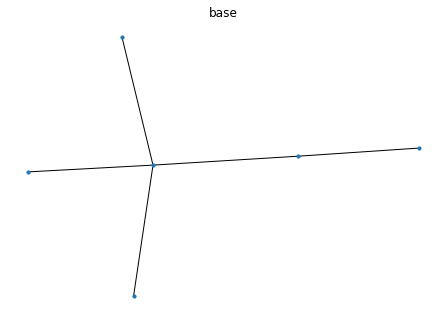

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 0, 2.0, 3.0, 0, 0, 0.4708, 0.0667, 0.0482, 0, 0.2667])
Testing set
Is there DIAG??  0.0


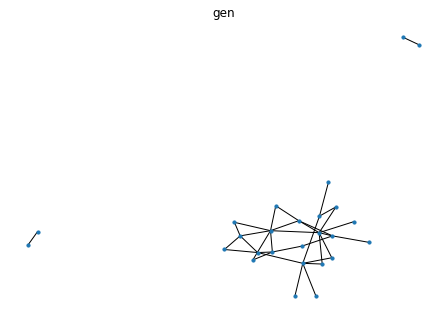

{'LCC': 22,
 'claw_count': 111.0,
 'cpl': 2.630901287553648,
 'd': 2.2666667,
 'd_max': 7.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.3784313725490196,
 'n_components': 7,
 'node_num': 30,
 'power_law_exp': 2.350029297545745,
 'rel_edge_distr_entropy': 0.8942289225479937,
 'square_count': 0,
 'triangle_count': 6,
 'wedge_count': 98.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


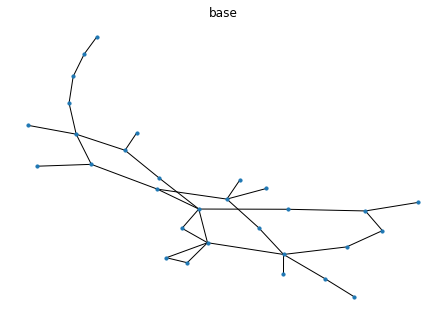

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 8, 32.0, 69.0, 4, 0, 0.1268, 0.1588, 0.0651, 6, 1.5599])
Is there DIAG??  0.0


{'LCC': 11,
 'claw_count': 9.0,
 'cpl': 2.5272727272727273,
 'd': 2.3333333,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.06547619047619047,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.139666724106282,
 'rel_edge_distr_entropy': 0.9447190741916937,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 25.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 1, 6.0, 17.0, 2, 0, 0.3331, 0.0833, 0.0124, 1, 0.1485])
Is there DIAG??  0.0


{'LCC': 12,
 'claw_count': 6.0,
 'cpl': 3.0869565217391304,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 15,
 'gini': 0.0755555555555556,
 'n_components': 2,
 'node_num': 15,
 'power_law_exp': 2.6431699961058612,
 'rel_edge_distr_entropy': 0.9700364297396069,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 20.0}
Is there DIAG on base??  0.0


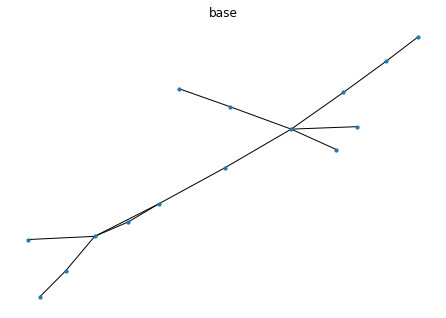

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 3, 5.0, 9.0, 0, 0, 0.1743, 0.08, 0.0244, 1, 0.3607])
Is there DIAG??  0.0


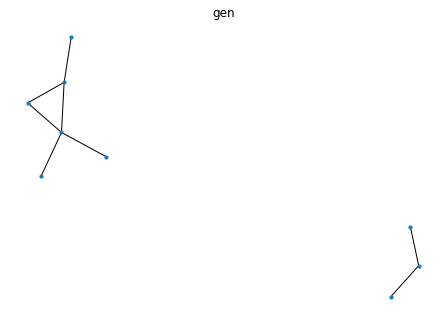

{'LCC': 6,
 'claw_count': 5.0,
 'cpl': 1.6666666666666667,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 8,
 'gini': 0.06944444444444442,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 3.324859901265959,
 'rel_edge_distr_entropy': 0.9314851747429381,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 11.0}
Is there DIAG on base??  0.0


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 0.0, 0.0, 0, 0, 3, 11.0, 30.0, 1, 0, 1.0854, 0.0833, 0.0965, 1, 0.2778])
26 data training in total 
[8/30]: vae_loss:8.4192, prior_loss:0.7326
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


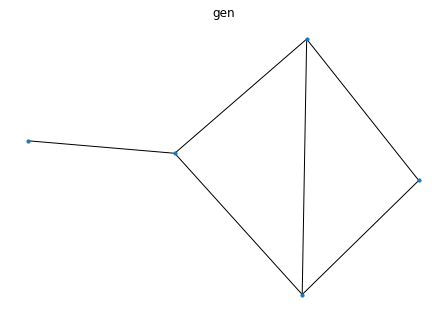

{'LCC': 5,
 'claw_count': 3.0,
 'cpl': 1.5,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': 0.11904761904761907,
 'n_components': 3,
 'node_num': 7,
 'power_law_exp': 2.253451992194984,
 'rel_edge_distr_entropy': 0.794168892305829,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 10.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 2, 4.0, 2.0, 2, 0, 0.9492, 0.1905, 0.1635, 2, 0.9762])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


{'LCC': 10,
 'claw_count': 8.0,
 'cpl': 2.8,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.17361111111111116,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.2722346772858293,
 'rel_edge_distr_entropy': 0.8951524361508442,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 21.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 2, 7.0, 28.0, 3, 0, 0.7906, 0.0069, 0.0071, 2, 0.3758])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


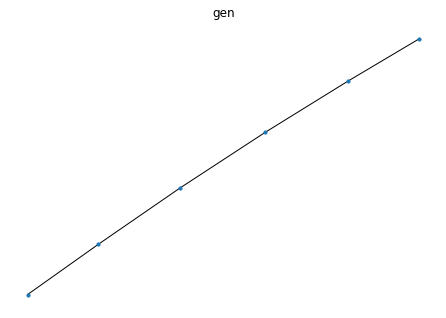

{'LCC': 6,
 'claw_count': 0.0,
 'cpl': 2.3333333333333335,
 'd': 1.6666666,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.20000000000000007,
 'n_components': 1,
 'node_num': 6,
 'power_law_exp': 3.1640425613334453,
 'rel_edge_distr_entropy': 0.9755815145647054,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 4.0}
Is there DIAG on base??  0.0


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 0, 3.0, 4.0, 0, 0, 0.7213, 0.1667, 0.0774, 0, 0.4667])
Testing set
Is there DIAG??  0.0


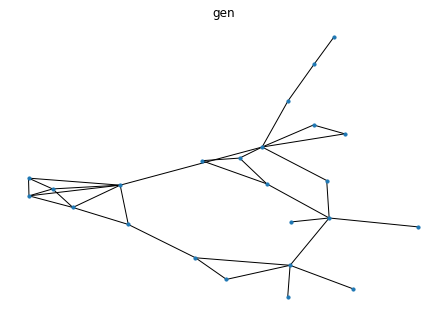

{'LCC': 24,
 'claw_count': 77.0,
 'cpl': 3.1666666666666665,
 'd': 2.2666667,
 'd_max': 6.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.3696078431372547,
 'n_components': 7,
 'node_num': 30,
 'power_law_exp': 2.1264237175289784,
 'rel_edge_distr_entropy': 0.8928942485386084,
 'square_count': 2,
 'triangle_count': 11,
 'wedge_count': 90.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


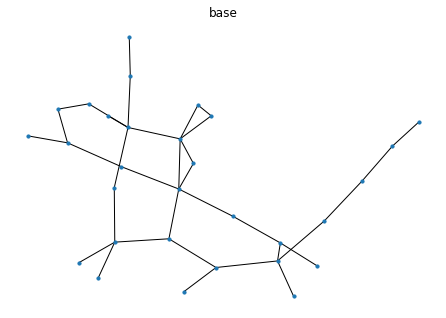

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 6, 24.0, 35.0, 9, 2, 0.3505, 0.15, 0.0664, 6, 1.0241])
Is there DIAG??  0.0


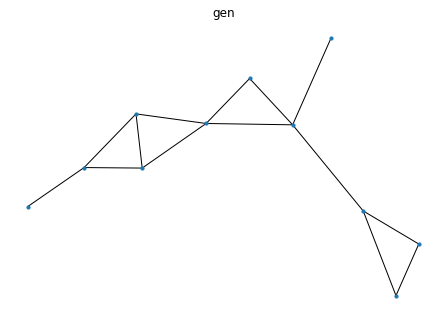

{'LCC': 11,
 'claw_count': 12.0,
 'cpl': 2.6363636363636362,
 'd': 2.3333333,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.11309523809523814,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.1896419709627115,
 'rel_edge_distr_entropy': 0.9323149895845481,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 27.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


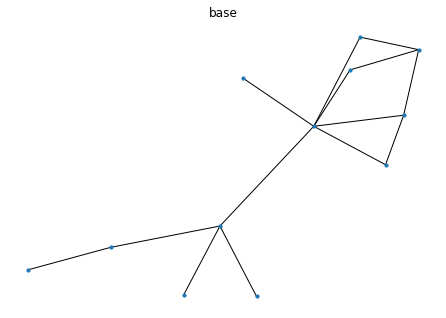

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 1, 4.0, 14.0, 3, 0, 0.2831, 0.0357, 0.0, 1, 0.2576])
Is there DIAG??  0.0


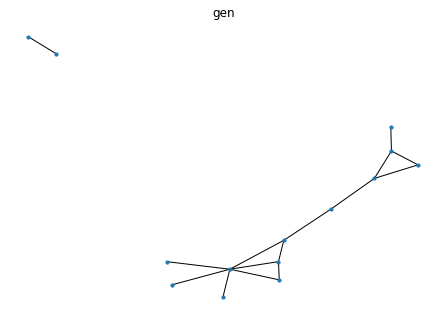

{'LCC': 12,
 'claw_count': 24.0,
 'cpl': 2.8656716417910446,
 'd': 2.0,
 'd_max': 6.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.22666666666666657,
 'n_components': 3,
 'node_num': 15,
 'power_law_exp': 2.6937566579213024,
 'rel_edge_distr_entropy': 0.9101472859355693,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 30.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


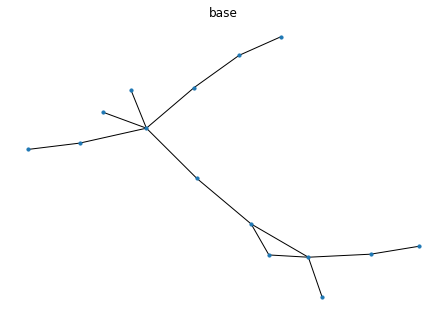

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 3, 5.0, 9.0, 2, 0, 0.1237, 0.0711, 0.0355, 2, 0.5819])
Is there DIAG??  0.0


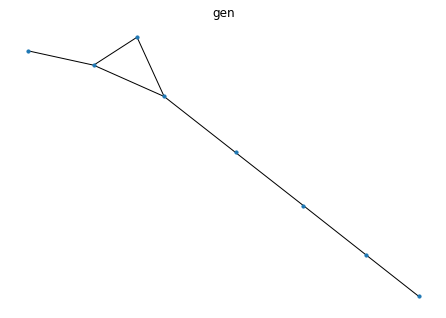

{'LCC': 8,
 'claw_count': 2.0,
 'cpl': 2.642857142857143,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.05555555555555558,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 2.609718417527379,
 'rel_edge_distr_entropy': 0.9166043628966368,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 10.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


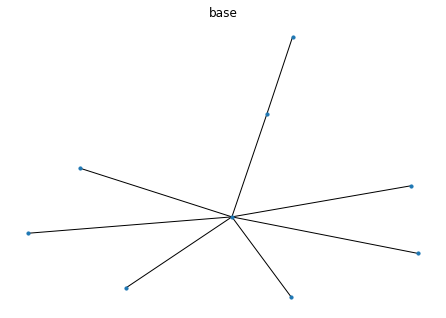

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 1, 12.0, 33.0, 1, 0, 1.8006, 0.0972, 0.0817, 1, 0.6984])
26 data training in total 
[9/30]: vae_loss:2.3846, prior_loss:0.7313
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


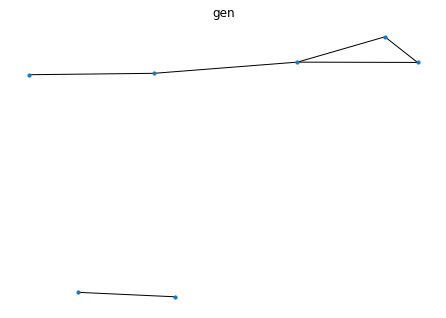

{'LCC': 5,
 'claw_count': 1.0,
 'cpl': 1.6363636363636365,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.0714285714285714,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 3.2026058631088743,
 'rel_edge_distr_entropy': 0.9577121084628163,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 6.0}
Is there DIAG on base??  0.0


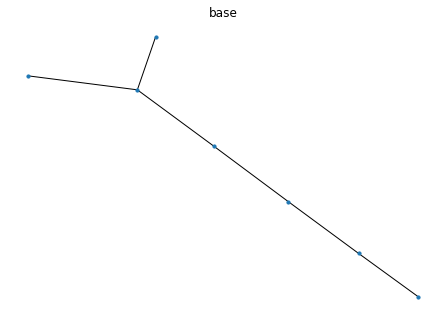

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 0.0, 0.0, 0, 0, 2, 0.0, 0.0, 1, 0, 0.0, 0.0, 0.0, 1, 0.8398])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


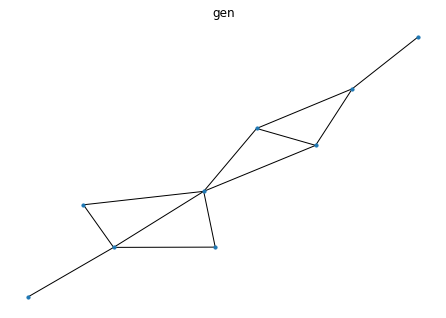

{'LCC': 9,
 'claw_count': 17.0,
 'cpl': 2.138888888888889,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.2777777777777779,
 'n_components': 4,
 'node_num': 12,
 'power_law_exp': 2.1722010946411068,
 'rel_edge_distr_entropy': 0.8387291594834336,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 27.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


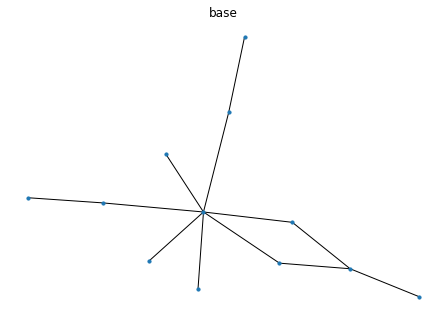

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 3, 1.0, 19.0, 4, 0, 0.8907, 0.0972, 0.0635, 3, 0.2854])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


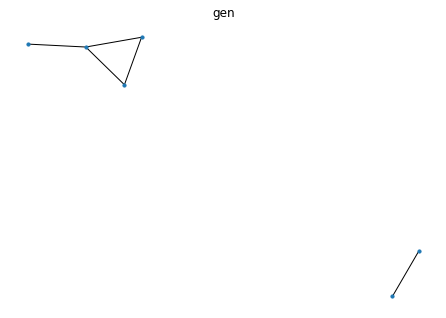

{'LCC': 4,
 'claw_count': 1.0,
 'cpl': 1.2857142857142858,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.10000000000000009,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 3.414577626291068,
 'rel_edge_distr_entropy': 0.9463784368140203,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


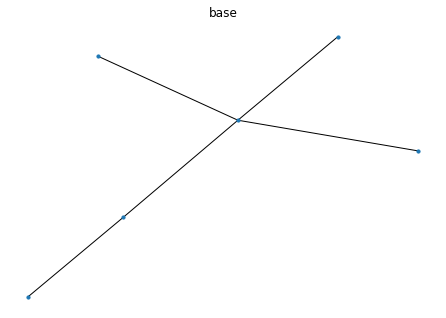

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 2, 2.0, 3.0, 1, 0, 0.4708, 0.0667, 0.0482, 1, 0.581])
Testing set
Is there DIAG??  0.0


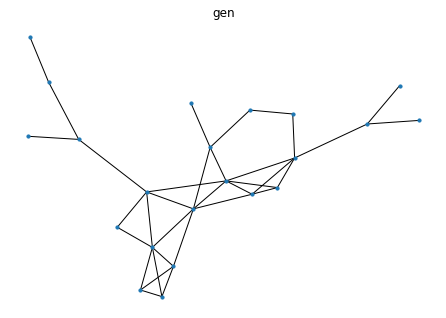

{'LCC': 22,
 'claw_count': 97.0,
 'cpl': 3.134199134199134,
 'd': 2.2666667,
 'd_max': 6.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.4235294117647057,
 'n_components': 9,
 'node_num': 30,
 'power_law_exp': 2.046687621164343,
 'rel_edge_distr_entropy': 0.8643944721390414,
 'square_count': 2,
 'triangle_count': 14,
 'wedge_count': 102.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


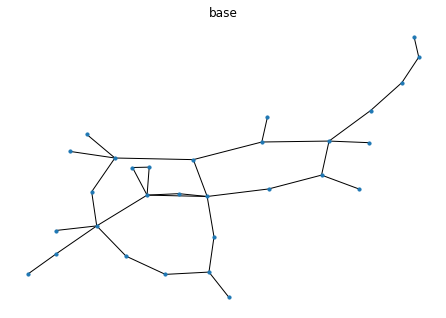

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 8, 36.0, 55.0, 12, 2, 0.4302, 0.2039, 0.0949, 8, 1.0566])
Is there DIAG??  0.0


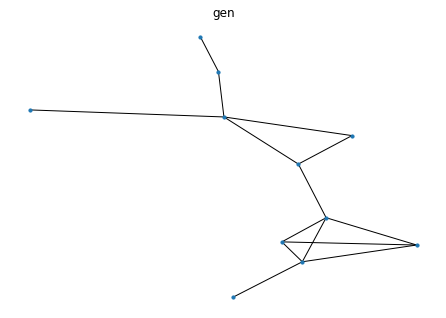

{'LCC': 11,
 'claw_count': 15.0,
 'cpl': 2.6363636363636362,
 'd': 2.3333333,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.14880952380952395,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.244201130514621,
 'rel_edge_distr_entropy': 0.9199109049774025,
 'square_count': 1,
 'triangle_count': 5,
 'wedge_count': 29.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


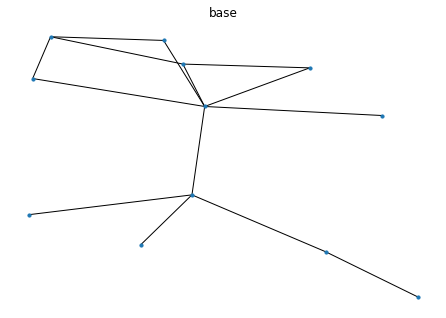

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 1, 2.0, 11.0, 4, 1, 0.2286, 0.0, 0.0124, 1, 0.2576])
Is there DIAG??  0.0


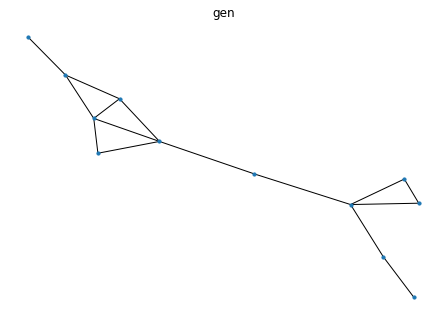

{'LCC': 12,
 'claw_count': 14.0,
 'cpl': 2.9545454545454546,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.24888888888888894,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.2217665576144823,
 'rel_edge_distr_entropy': 0.8847207856104193,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 29.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


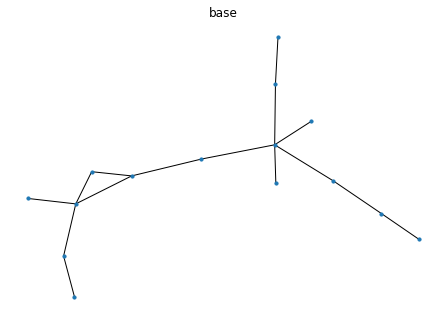

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 3, 4.0, 1.0, 3, 0, 0.5957, 0.0933, 0.061, 3, 0.4931])
Is there DIAG??  0.0


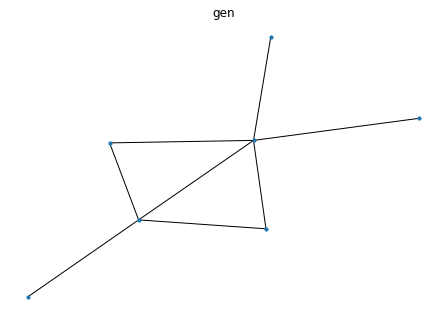

{'LCC': 7,
 'claw_count': 14.0,
 'cpl': 1.7142857142857142,
 'd': 1.7777778,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.26388888888888884,
 'n_components': 3,
 'node_num': 9,
 'power_law_exp': 2.597434379930681,
 'rel_edge_distr_entropy': 0.7963387698311156,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 18.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


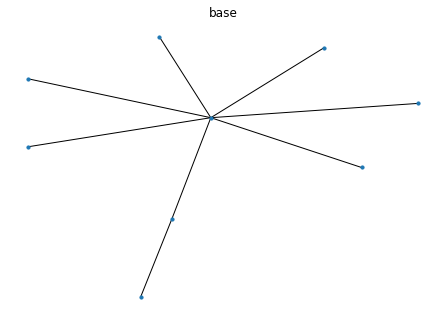

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 2, 4.0, 21.0, 2, 0, 1.8129, 0.1111, 0.0386, 2, 0.2302])
26 data training in total 
[10/30]: vae_loss:5.7343, prior_loss:0.6332
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


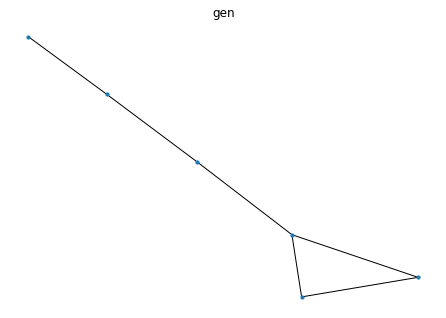

{'LCC': 6,
 'claw_count': 1.0,
 'cpl': 2.066666666666667,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': -0.023809523809523725,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 2.549906600843973,
 'rel_edge_distr_entropy': 0.8983485320836201,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 7.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


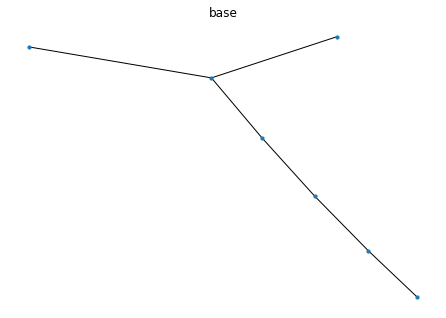

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 1, 1.0, 0.0, 1, 0, 0.6527, 0.0476, 0.0594, 1, 0.4095])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


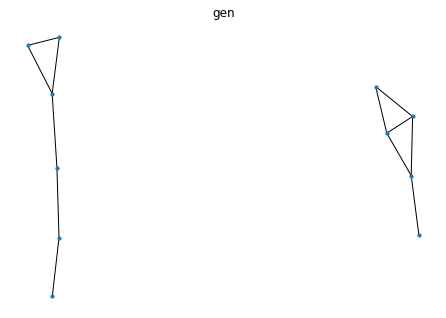

{'LCC': 6,
 'claw_count': 4.0,
 'cpl': 1.84,
 'd': 2.0,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.07638888888888906,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.399458145014412,
 'rel_edge_distr_entropy': 0.941641200179947,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 17.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


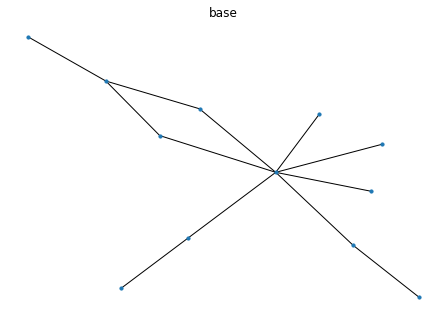

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 6, 11.0, 32.0, 3, 0, 0.6634, 0.1042, 0.0394, 2, 0.5842])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


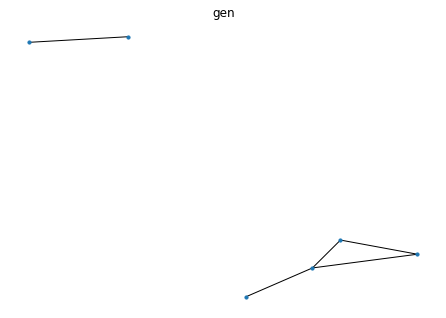

{'LCC': 4,
 'claw_count': 1.0,
 'cpl': 1.2857142857142858,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.10000000000000009,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 3.414577626291068,
 'rel_edge_distr_entropy': 0.9463784368140203,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


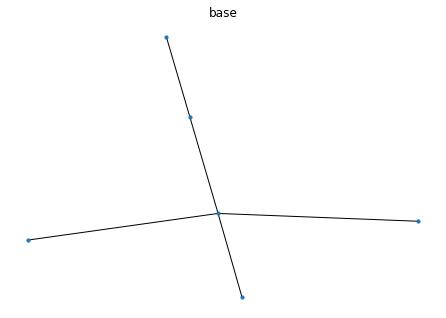

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 2, 2.0, 3.0, 1, 0, 0.4708, 0.0667, 0.0482, 1, 0.581])
Testing set
Is there DIAG??  0.0


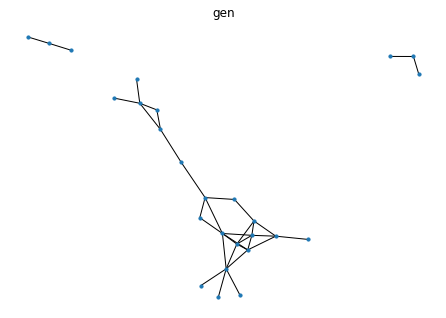

{'LCC': 20,
 'claw_count': 87.0,
 'cpl': 3.2908163265306123,
 'd': 2.2666667,
 'd_max': 6.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.3735294117647059,
 'n_components': 7,
 'node_num': 30,
 'power_law_exp': 2.3531443736850552,
 'rel_edge_distr_entropy': 0.8971188002113822,
 'square_count': 2,
 'triangle_count': 12,
 'wedge_count': 93.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


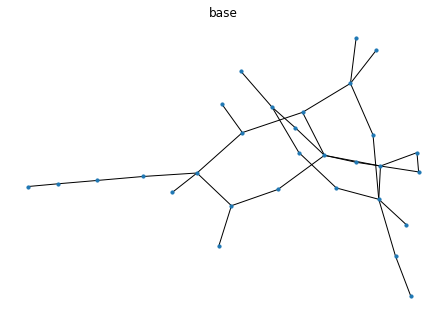

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 10, 27.0, 45.0, 10, 2, 0.1237, 0.1539, 0.0622, 6, 0.9])
Is there DIAG??  0.0


{'LCC': 12,
 'claw_count': 9.0,
 'cpl': 3.015151515151515,
 'd': 2.3333333,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.0535714285714286,
 'n_components': 1,
 'node_num': 12,
 'power_law_exp': 2.3394655037229932,
 'rel_edge_distr_entropy': 0.9646422134039876,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 24.0}
Is there DIAG on base??  0.0


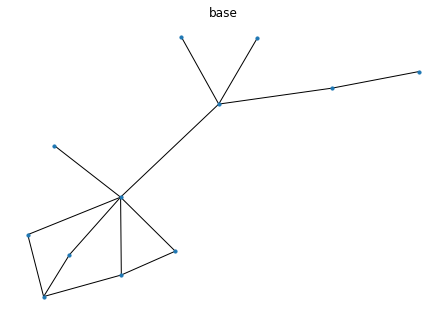

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 0, 7.0, 17.0, 2, 0, 0.1333, 0.0952, 0.0323, 0, 0.6364])
Is there DIAG??  0.0


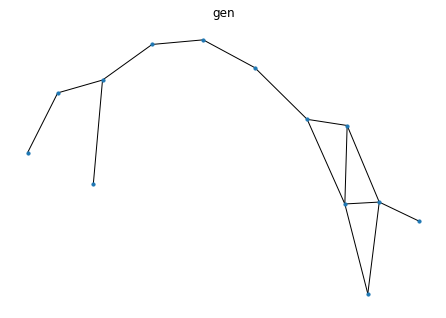

{'LCC': 13,
 'claw_count': 11.0,
 'cpl': 3.7435897435897436,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.20444444444444443,
 'n_components': 3,
 'node_num': 15,
 'power_law_exp': 2.3635179152578742,
 'rel_edge_distr_entropy': 0.9124065858460414,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 26.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


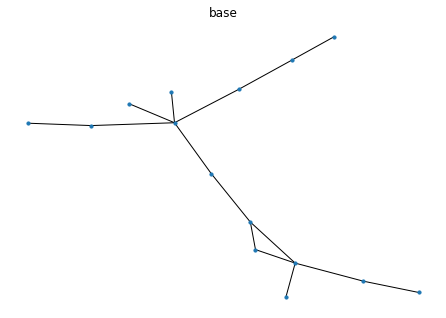

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 2, 1.0, 4.0, 2, 0, 0.454, 0.0489, 0.0333, 2, 0.296])
Is there DIAG??  0.0


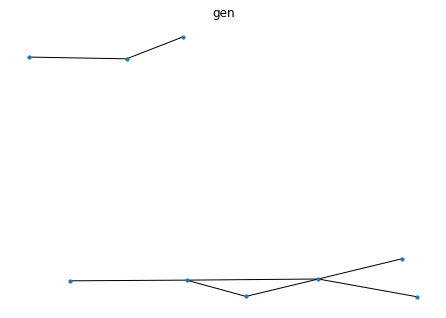

{'LCC': 6,
 'claw_count': 5.0,
 'cpl': 1.6666666666666667,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 8,
 'gini': 0.06944444444444442,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 3.324859901265959,
 'rel_edge_distr_entropy': 0.9314851747429381,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 11.0}
Is there DIAG on base??  0.0


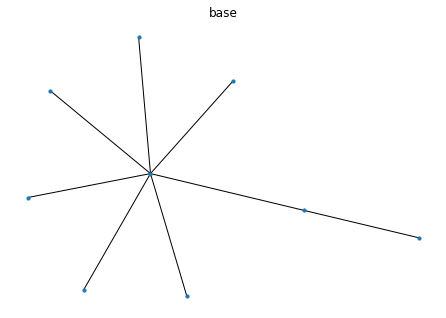

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 0.0, 0.0, 0, 0, 3, 11.0, 30.0, 1, 0, 1.0854, 0.0833, 0.0965, 1, 0.2778])
26 data training in total 
[11/30]: vae_loss:3.7544, prior_loss:0.5028
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


{'LCC': 7,
 'claw_count': 1.0,
 'cpl': 2.380952380952381,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.0714285714285714,
 'n_components': 1,
 'node_num': 7,
 'power_law_exp': 3.2026058631088743,
 'rel_edge_distr_entropy': 0.9577122309857289,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 6.0}
Is there DIAG on base??  0.0


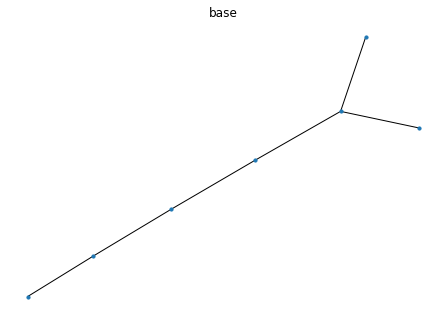

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0.0, 0, 0, 0.0, 0.0, 0.0, 0, 0.0952])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


{'LCC': 11,
 'claw_count': 3.0,
 'cpl': 2.690909090909091,
 'd': 2.0,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.03472222222222232,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.3500465612161587,
 'rel_edge_distr_entropy': 0.9504150456553102,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 16.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


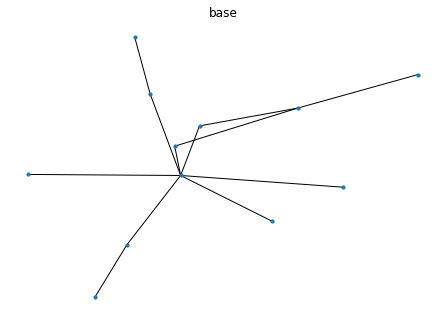

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 1, 12.0, 33.0, 1, 0, 0.7128, 0.1458, 0.0481, 1, 0.2667])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


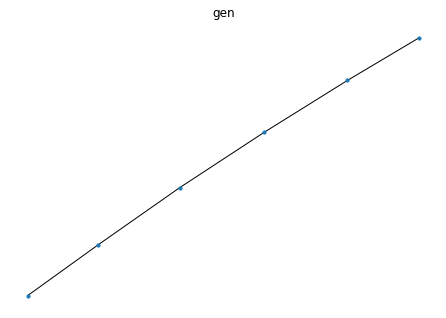

{'LCC': 6,
 'claw_count': 0.0,
 'cpl': 2.3333333333333335,
 'd': 1.6666666,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.20000000000000007,
 'n_components': 1,
 'node_num': 6,
 'power_law_exp': 3.1640425613334453,
 'rel_edge_distr_entropy': 0.9755815145647054,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 4.0}
Is there DIAG on base??  0.0


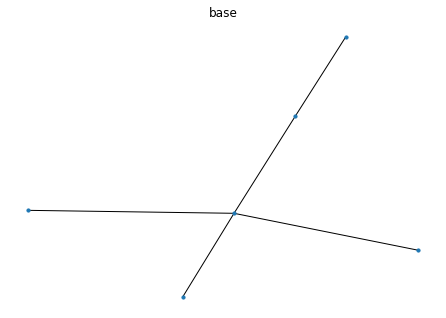

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 0, 3.0, 4.0, 0, 0, 0.7213, 0.1667, 0.0774, 0, 0.4667])
Testing set
Is there DIAG??  0.0


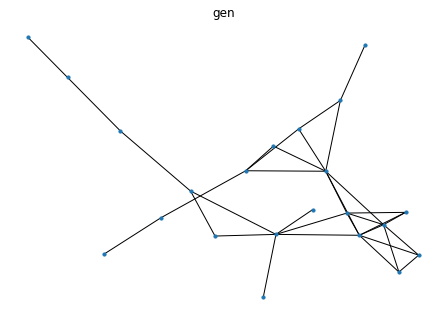

{'LCC': 22,
 'claw_count': 130.0,
 'cpl': 3.294372294372294,
 'd': 2.2666667,
 'd_max': 7.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.4441176470588235,
 'n_components': 9,
 'node_num': 30,
 'power_law_exp': 2.0716818182836865,
 'rel_edge_distr_entropy': 0.855587936925119,
 'square_count': 3,
 'triangle_count': 16,
 'wedge_count': 111.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


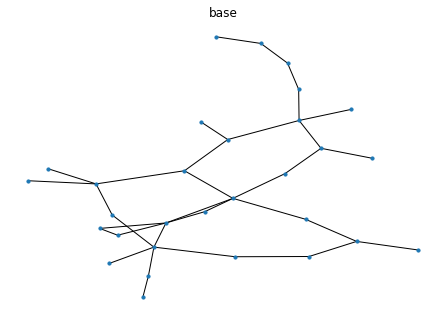

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 8, 45.0, 88.0, 14, 3, 0.4052, 0.2245, 0.1037, 8, 0.8964])
Is there DIAG??  0.0


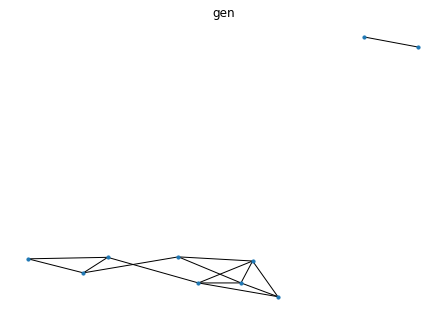

{'LCC': 8,
 'claw_count': 16.0,
 'cpl': 1.6551724137931034,
 'd': 2.3333333,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.17261904761904767,
 'n_components': 4,
 'node_num': 12,
 'power_law_exp': 2.0814927008751924,
 'rel_edge_distr_entropy': 0.8924674638529322,
 'square_count': 1,
 'triangle_count': 6,
 'wedge_count': 31.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


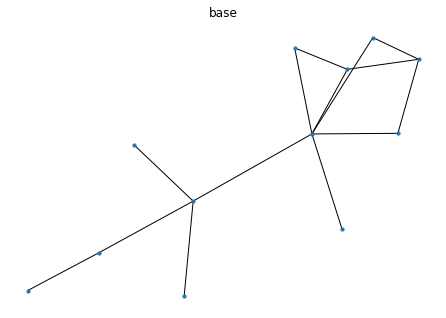

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 4, 0.0, 10.0, 5, 1, 0.3913, 0.0238, 0.0398, 3, 0.7236])
Is there DIAG??  0.0


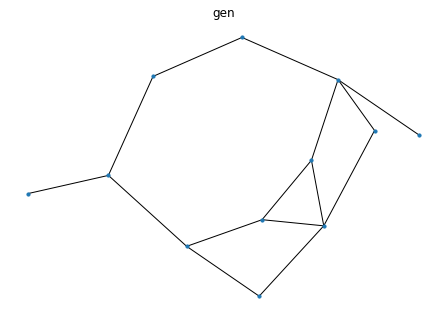

{'LCC': 12,
 'claw_count': 12.0,
 'cpl': 2.4242424242424243,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.23555555555555552,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.207288813145534,
 'rel_edge_distr_entropy': 0.888903334158732,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 28.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


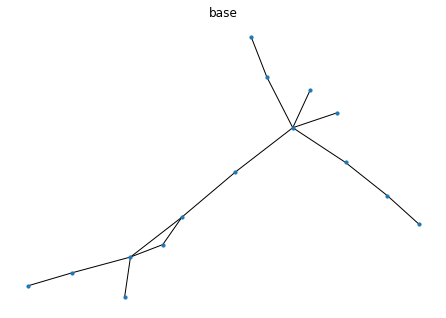

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 3, 3.0, 3.0, 0, 0, 0.6102, 0.08, 0.0568, 3, 1.0234])
Is there DIAG??  0.0


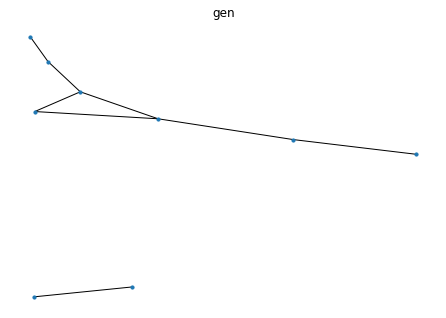

{'LCC': 7,
 'claw_count': 2.0,
 'cpl': 2.1818181818181817,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 8,
 'gini': 0.01388888888888884,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 3.1044429818782895,
 'rel_edge_distr_entropy': 0.9560345699882202,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 9.0}
Is there DIAG on base??  0.0


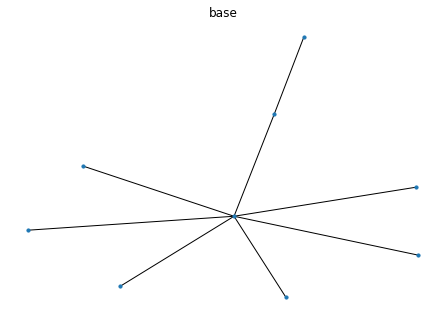

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 0.0, 0.0, 0, 0, 2, 13.0, 33.0, 1, 0, 1.3059, 0.1389, 0.1211, 1, 0.2374])
26 data training in total 
[12/30]: vae_loss:4.0514, prior_loss:0.3875
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


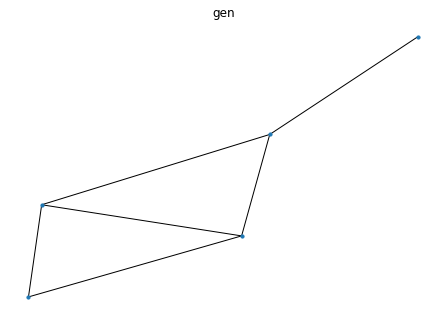

{'LCC': 5,
 'claw_count': 3.0,
 'cpl': 1.5,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': 0.11904761904761907,
 'n_components': 3,
 'node_num': 7,
 'power_law_exp': 2.253451992194984,
 'rel_edge_distr_entropy': 0.794168892305829,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 10.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


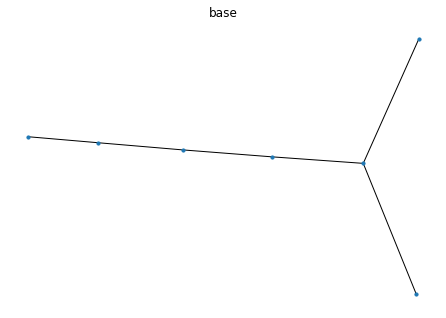

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 2, 4.0, 2.0, 2, 0, 0.9492, 0.1905, 0.1635, 2, 0.9762])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


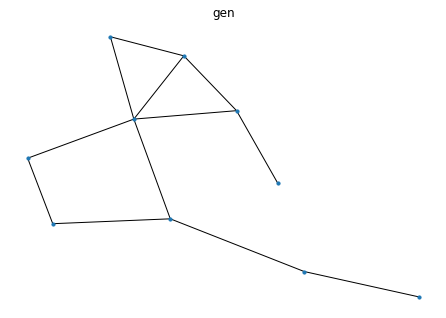

{'LCC': 10,
 'claw_count': 13.0,
 'cpl': 2.3333333333333335,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.20138888888888906,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.302445660712341,
 'rel_edge_distr_entropy': 0.8852180194592308,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 23.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


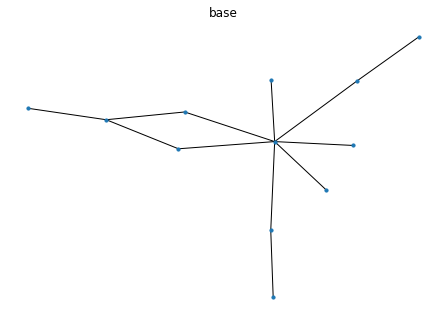

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 2, 5.0, 23.0, 2, 0, 0.7604, 0.0208, 0.0171, 2, 0.0909])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


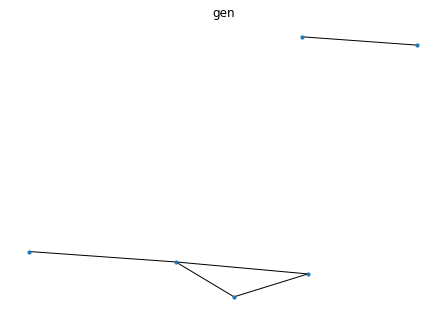

{'LCC': 4,
 'claw_count': 1.0,
 'cpl': 1.2857142857142858,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.10000000000000009,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 3.414577626291068,
 'rel_edge_distr_entropy': 0.9463784368140203,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


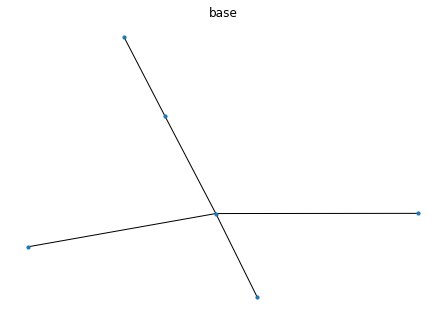

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 2, 2.0, 3.0, 1, 0, 0.4708, 0.0667, 0.0482, 1, 0.581])
Testing set
Is there DIAG??  0.0


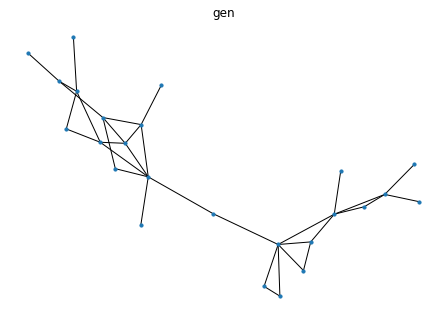

{'LCC': 25,
 'claw_count': 76.0,
 'cpl': 3.763333333333333,
 'd': 2.2666667,
 'd_max': 6.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.3627450980392155,
 'n_components': 6,
 'node_num': 30,
 'power_law_exp': 2.215954616858699,
 'rel_edge_distr_entropy': 0.8985110250275797,
 'square_count': 0,
 'triangle_count': 8,
 'wedge_count': 89.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 5, 23.0, 34.0, 6, 0, 0.2609, 0.1431, 0.0608, 5, 0.4275])
Is there DIAG??  0.0


{'LCC': 8,
 'claw_count': 23.0,
 'cpl': 1.9,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.1607142857142858,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.5187937336385398,
 'rel_edge_distr_entropy': 0.9276870967237173,
 'square_count': 1,
 'triangle_count': 6,
 'wedge_count': 31.0}
Is there DIAG on base??  0.0


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 4, 0.0, 3.0, 5, 1, 0.046, 0.0119, 0.0046, 2, 0.4788])
Is there DIAG??  0.0


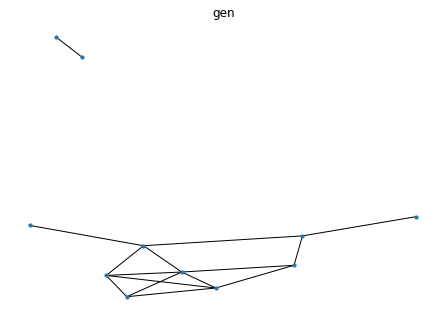

{'LCC': 9,
 'claw_count': 25.0,
 'cpl': 1.864864864864865,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.3422222222222222,
 'n_components': 6,
 'node_num': 15,
 'power_law_exp': 2.2135710970305054,
 'rel_edge_distr_entropy': 0.8304202000020422,
 'square_count': 1,
 'triangle_count': 6,
 'wedge_count': 37.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


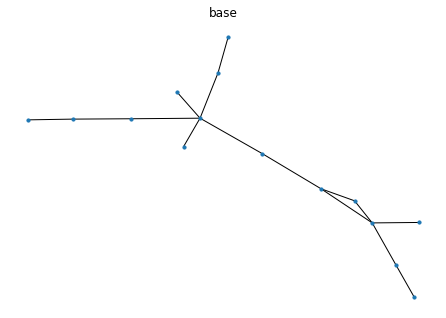

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 6, 12.0, 10.0, 5, 1, 0.6039, 0.1867, 0.1153, 5, 1.5828])
Is there DIAG??  0.0


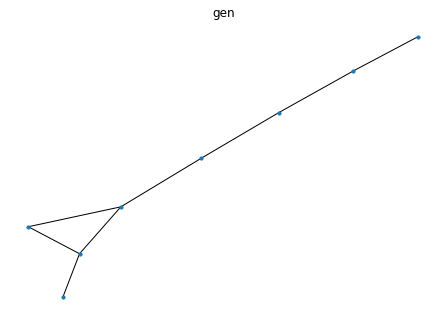

{'LCC': 8,
 'claw_count': 2.0,
 'cpl': 2.642857142857143,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.05555555555555558,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 2.609718417527379,
 'rel_edge_distr_entropy': 0.9166043628966368,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 10.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


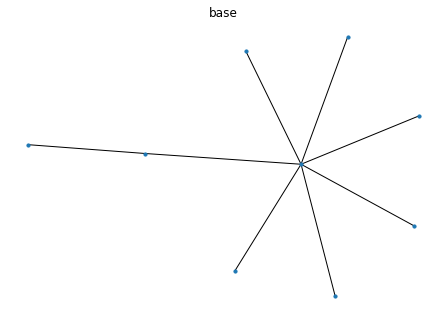

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 1, 12.0, 33.0, 1, 0, 1.8006, 0.0972, 0.0817, 1, 0.6984])
26 data training in total 
[13/30]: vae_loss:5.7755, prior_loss:0.3480
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


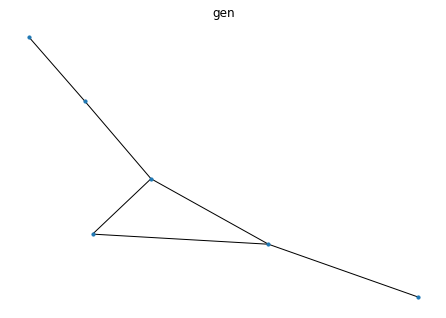

{'LCC': 6,
 'claw_count': 2.0,
 'cpl': 1.9333333333333333,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': 0.04761904761904767,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 2.674331879653742,
 'rel_edge_distr_entropy': 0.8759405616457789,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 1, 2.0, 1.0, 1, 0, 0.5283, 0.119, 0.0818, 1, 0.5429])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


{'LCC': 9,
 'claw_count': 9.0,
 'cpl': 2.0,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.20138888888888906,
 'n_components': 4,
 'node_num': 12,
 'power_law_exp': 2.0888435658065516,
 'rel_edge_distr_entropy': 0.8631350242078325,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 23.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


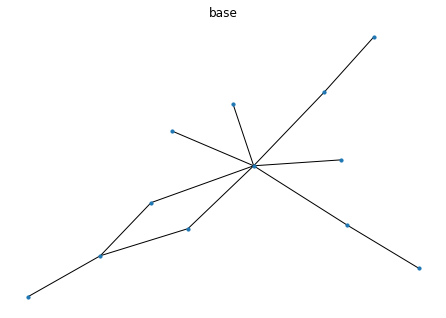

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 3, 5.0, 27.0, 2, 0, 0.974, 0.0208, 0.0391, 3, 0.4242])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


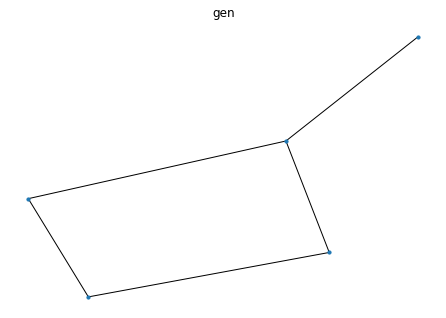

{'LCC': 5,
 'claw_count': 1.0,
 'cpl': 1.6,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 5,
 'gini': -0.03333333333333344,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 2.5732899022206244,
 'rel_edge_distr_entropy': 0.8690135303720694,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 6.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


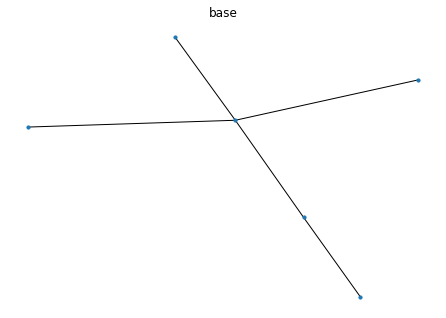

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 1, 1.0, 3.0, 0, 0, 1.3121, 0.0, 0.0292, 1, 0.2667])
Testing set
Is there DIAG??  0.0


{'LCC': 21,
 'claw_count': 227.0,
 'cpl': 2.8,
 'd': 2.2666667,
 'd_max': 10.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.5058823529411764,
 'n_components': 10,
 'node_num': 30,
 'power_law_exp': 2.1071484910894576,
 'rel_edge_distr_entropy': 0.8212399190376842,
 'square_count': 4,
 'triangle_count': 17,
 'wedge_count': 137.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


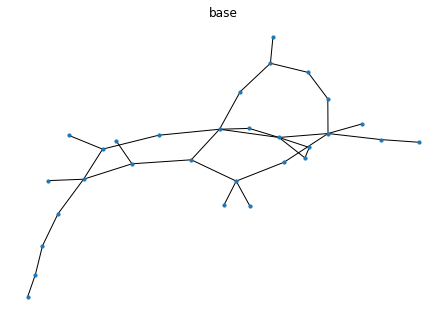

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([5.0, 1.0, 0.0, 0, 0, 9, 71.0, 185.0, 15, 4, 0.3697, 0.2863, 0.1381, 9, 1.3908])
Is there DIAG??  0.0


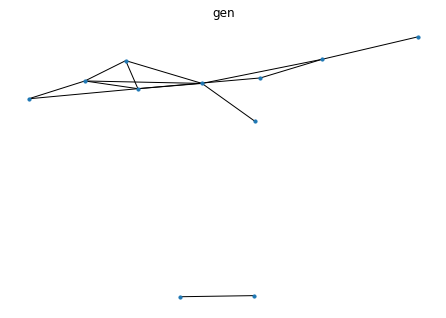

{'LCC': 9,
 'claw_count': 26.0,
 'cpl': 1.864864864864865,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.2142857142857144,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.3433163517178475,
 'rel_edge_distr_entropy': 0.8953600647976667,
 'square_count': 1,
 'triangle_count': 5,
 'wedge_count': 34.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


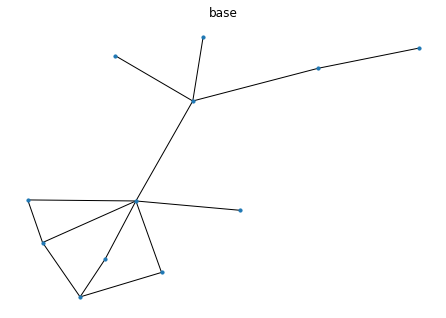

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 3, 3.0, 0.0, 4, 1, 0.1295, 0.0655, 0.037, 2, 0.5139])
Is there DIAG??  0.0


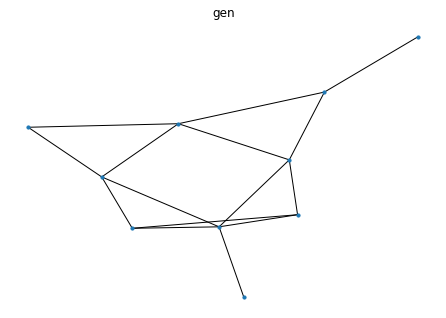

{'LCC': 10,
 'claw_count': 25.0,
 'cpl': 1.9555555555555555,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.3555555555555556,
 'n_components': 6,
 'node_num': 15,
 'power_law_exp': 2.0248731546865013,
 'rel_edge_distr_entropy': 0.8133576522446877,
 'square_count': 0,
 'triangle_count': 5,
 'wedge_count': 38.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


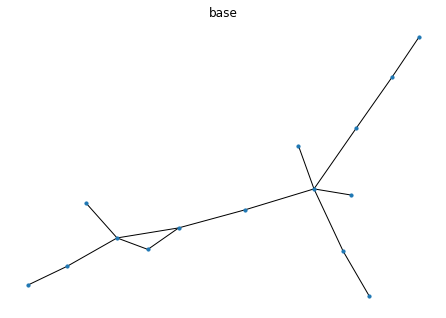

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 5, 13.0, 10.0, 4, 0, 0.7926, 0.2, 0.1323, 5, 1.4921])
Is there DIAG??  0.0


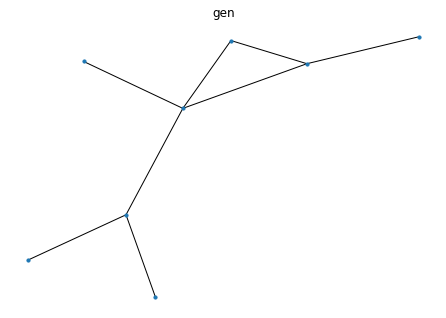

{'LCC': 8,
 'claw_count': 6.0,
 'cpl': 2.142857142857143,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.15277777777777768,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 2.8706159838918133,
 'rel_edge_distr_entropy': 0.8771712260628222,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 13.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


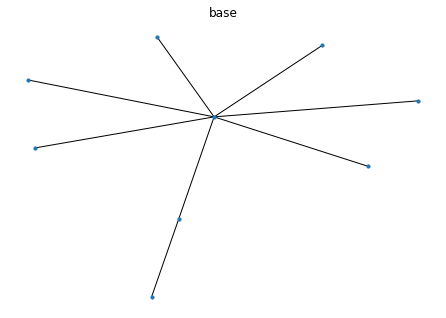

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 1, 9.0, 29.0, 1, 0, 1.5397, 0.0, 0.0422, 1, 0.1984])
26 data training in total 
[14/30]: vae_loss:10.2397, prior_loss:0.3026
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


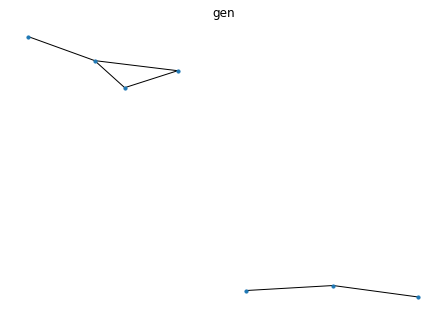

{'LCC': 4,
 'claw_count': 1.0,
 'cpl': 1.3333333333333333,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.0714285714285714,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 3.2026058631088743,
 'rel_edge_distr_entropy': 0.9577122309857289,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 6.0}
Is there DIAG on base??  0.0


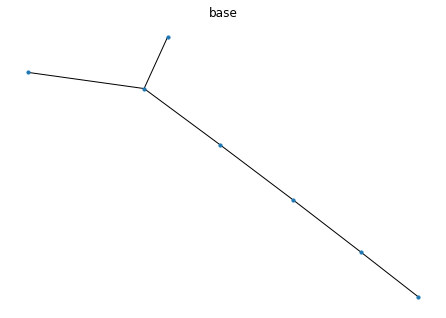

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 0.0, 0.0, 0, 0, 3, 0.0, 0.0, 1, 0, 0.0, 0.0, 0.0, 1, 1.1429])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


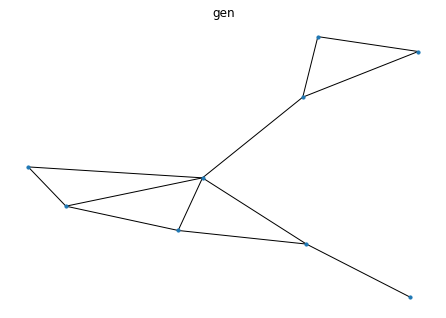

{'LCC': 9,
 'claw_count': 14.0,
 'cpl': 2.0833333333333335,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.23611111111111116,
 'n_components': 4,
 'node_num': 12,
 'power_law_exp': 2.1134027126173276,
 'rel_edge_distr_entropy': 0.8532006075162192,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 25.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


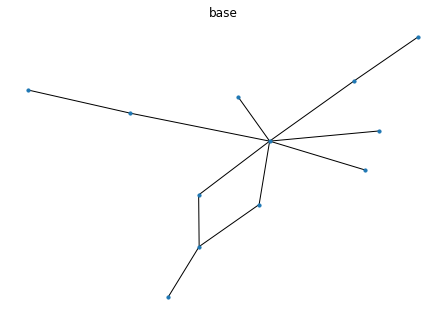

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 3, 3.0, 22.0, 4, 0, 0.9495, 0.0556, 0.0491, 3, 0.3409])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


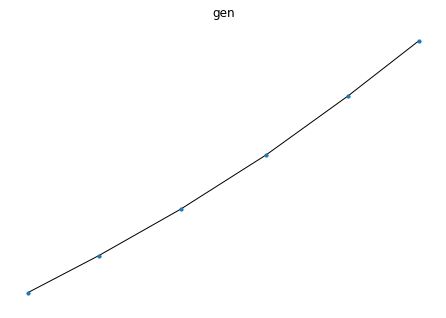

{'LCC': 6,
 'claw_count': 0.0,
 'cpl': 2.3333333333333335,
 'd': 1.6666666,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.20000000000000007,
 'n_components': 1,
 'node_num': 6,
 'power_law_exp': 3.1640425613334453,
 'rel_edge_distr_entropy': 0.9755815145647054,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 4.0}
Is there DIAG on base??  0.0


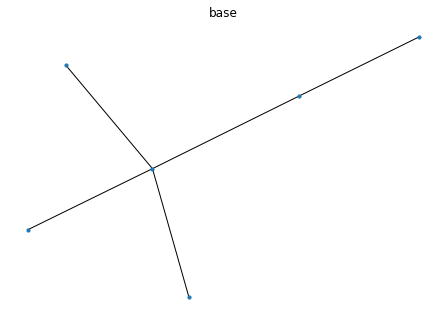

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 0, 3.0, 4.0, 0, 0, 0.7213, 0.1667, 0.0774, 0, 0.4667])
Testing set
Is there DIAG??  0.0


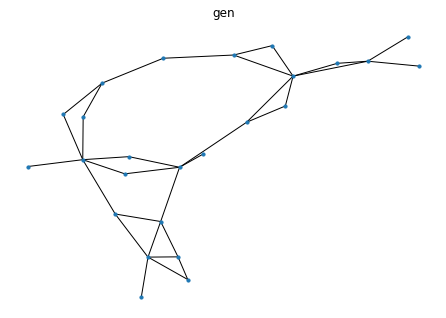

{'LCC': 25,
 'claw_count': 73.0,
 'cpl': 3.433333333333333,
 'd': 2.2666667,
 'd_max': 6.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.3441176470588234,
 'n_components': 6,
 'node_num': 30,
 'power_law_exp': 2.1733580390926854,
 'rel_edge_distr_entropy': 0.9048817100759492,
 'square_count': 0,
 'triangle_count': 6,
 'wedge_count': 86.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


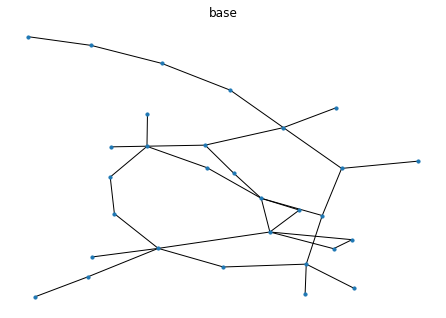

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 5, 20.0, 31.0, 4, 0, 0.3035, 0.1245, 0.0544, 5, 0.7575])
Is there DIAG??  0.0


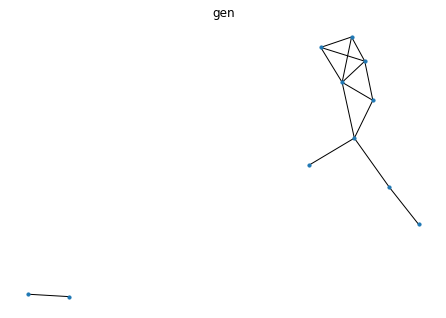

{'LCC': 9,
 'claw_count': 21.0,
 'cpl': 2.027027027027027,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.19047619047619047,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.3140587700663393,
 'rel_edge_distr_entropy': 0.9038753339314464,
 'square_count': 1,
 'triangle_count': 6,
 'wedge_count': 32.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


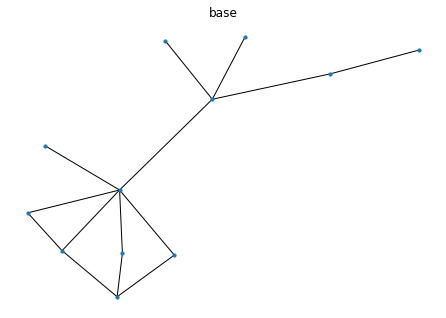

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 3, 1.0, 5.0, 5, 1, 0.1587, 0.0417, 0.0284, 2, 0.3518])
Is there DIAG??  0.0


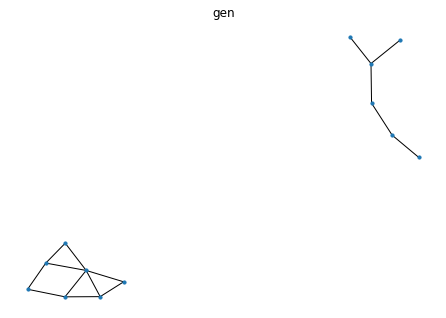

{'LCC': 7,
 'claw_count': 14.0,
 'cpl': 1.8055555555555556,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.2088888888888889,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.3728107276618084,
 'rel_edge_distr_entropy': 0.9092964608114635,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 27.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


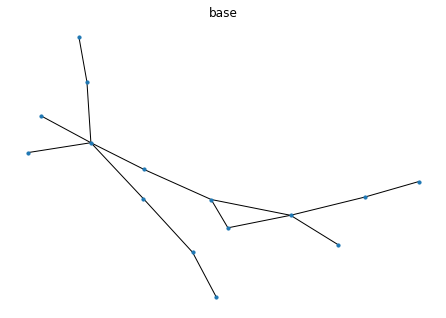

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 8, 2.0, 1.0, 2, 0, 0.4447, 0.0533, 0.0364, 3, 1.6421])
Is there DIAG??  0.0


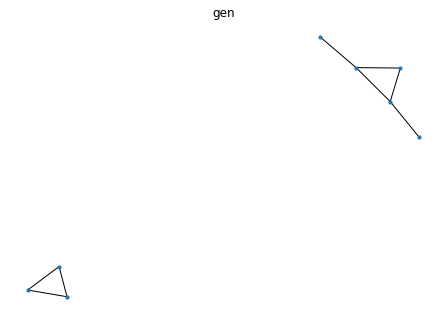

{'LCC': 5,
 'claw_count': 2.0,
 'cpl': 1.4615384615384615,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.05555555555555558,
 'n_components': 3,
 'node_num': 9,
 'power_law_exp': 2.609718417527379,
 'rel_edge_distr_entropy': 0.9166043628966368,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 10.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


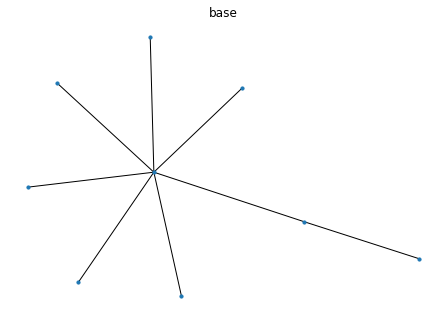

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 4, 12.0, 33.0, 2, 0, 1.8006, 0.0972, 0.0817, 2, 0.4829])
26 data training in total 
[15/30]: vae_loss:6.0464, prior_loss:0.3463
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


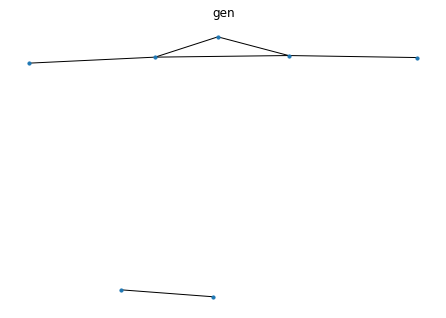

{'LCC': 5,
 'claw_count': 2.0,
 'cpl': 1.5454545454545454,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.023809523809523725,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 3.421833793828355,
 'rel_edge_distr_entropy': 0.9353041380249751,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 7.0}
Is there DIAG on base??  0.0


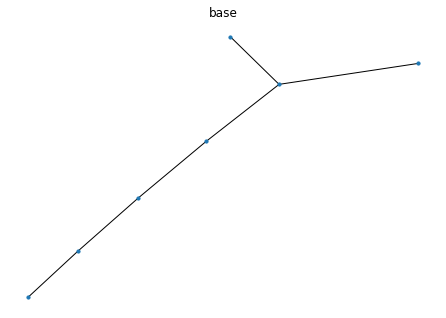

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 0.0, 0.0, 0, 0, 2, 1.0, 1.0, 1, 0, 0.2192, 0.0476, 0.0224, 1, 0.9307])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


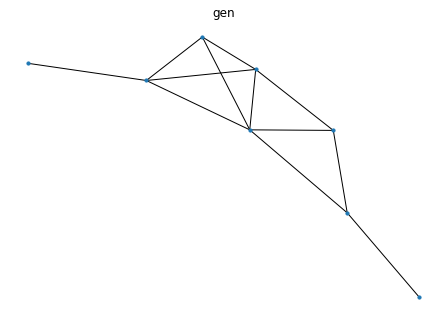

{'LCC': 8,
 'claw_count': 21.0,
 'cpl': 1.8214285714285714,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.32638888888888906,
 'n_components': 5,
 'node_num': 12,
 'power_law_exp': 2.041956528569873,
 'rel_edge_distr_entropy': 0.7922402995076363,
 'square_count': 1,
 'triangle_count': 6,
 'wedge_count': 31.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


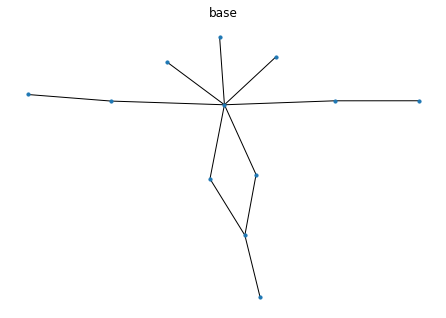

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 4, 3.0, 15.0, 6, 1, 1.0209, 0.1458, 0.11, 4, 0.6028])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


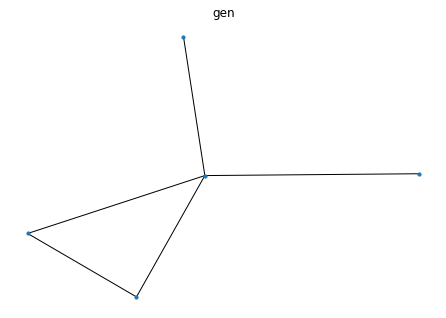

{'LCC': 5,
 'claw_count': 4.0,
 'cpl': 1.5,
 'd': 1.6666666,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 5,
 'gini': 0.06666666666666665,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 2.8033688011112043,
 'rel_edge_distr_entropy': 0.820845913399302,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


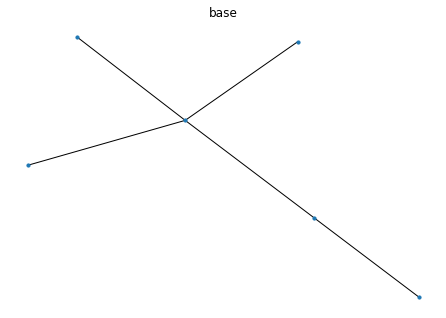

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 1, 1.0, 0.0, 1, 0, 1.082, 0.1, 0.0774, 1, 0.3667])
Testing set
Is there DIAG??  0.0


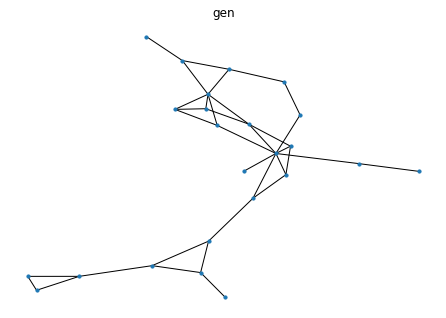

{'LCC': 24,
 'claw_count': 92.0,
 'cpl': 3.6268115942028984,
 'd': 2.2666667,
 'd_max': 8.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.33529411764705874,
 'n_components': 7,
 'node_num': 30,
 'power_law_exp': 2.0955613054010627,
 'rel_edge_distr_entropy': 0.8972243684392254,
 'square_count': 0,
 'triangle_count': 9,
 'wedge_count': 90.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 6, 24.0, 50.0, 7, 0, 0.3813, 0.1157, 0.0621, 6, 0.564])
Is there DIAG??  0.0


{'LCC': 12,
 'claw_count': 8.0,
 'cpl': 2.621212121212121,
 'd': 2.3333333,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.029761904761904878,
 'n_components': 1,
 'node_num': 12,
 'power_law_exp': 2.2977912410502306,
 'rel_edge_distr_entropy': 0.972162515316164,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 23.0}
Is there DIAG on base??  0.0


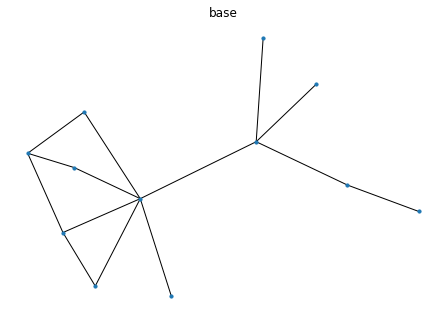

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 0, 8.0, 18.0, 1, 0, 0.175, 0.119, 0.0398, 0, 0.2424])
Is there DIAG??  0.0


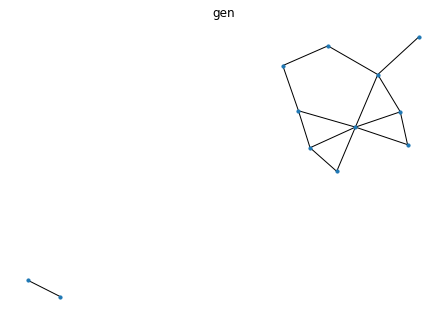

{'LCC': 10,
 'claw_count': 27.0,
 'cpl': 1.9130434782608696,
 'd': 2.0,
 'd_max': 6.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.2977777777777777,
 'n_components': 5,
 'node_num': 15,
 'power_law_exp': 2.2977912410502306,
 'rel_edge_distr_entropy': 0.8653987618612342,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 34.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


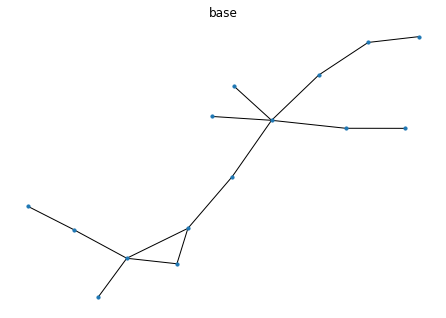

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 5, 9.0, 12.0, 3, 0, 0.5197, 0.1422, 0.0803, 4, 1.5346])
Is there DIAG??  0.0


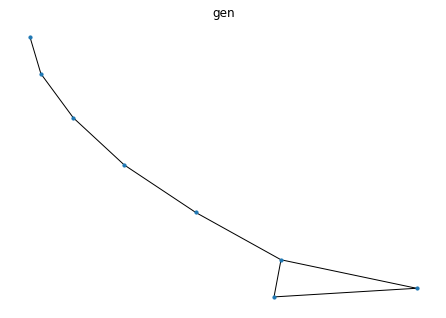

{'LCC': 8,
 'claw_count': 1.0,
 'cpl': 2.7857142857142856,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': -0.01388888888888884,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 2.52163709787812,
 'rel_edge_distr_entropy': 0.9314881044851694,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 9.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


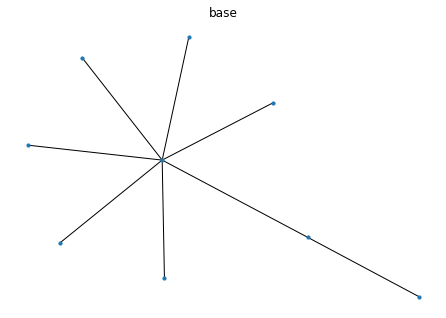

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 1, 13.0, 34.0, 1, 0, 1.8887, 0.1667, 0.0965, 1, 0.8413])
26 data training in total 
[16/30]: vae_loss:5.9364, prior_loss:0.3738
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


{'LCC': 4,
 'claw_count': 1.0,
 'cpl': 1.3333333333333333,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.0714285714285714,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 3.2026058631088743,
 'rel_edge_distr_entropy': 0.9577121084628163,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 6.0}
Is there DIAG on base??  0.0


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 0.0, 0.0, 0, 0, 3, 0.0, 0.0, 1, 0, 0.0, 0.0, 0.0, 1, 1.1429])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


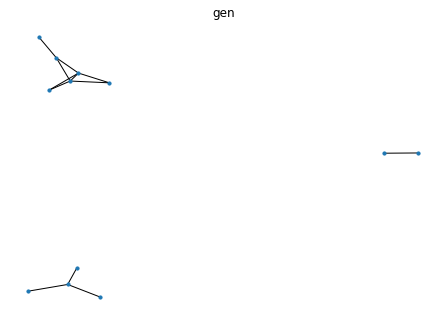

{'LCC': 6,
 'claw_count': 10.0,
 'cpl': 1.5454545454545454,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 12,
 'gini': 0.13888888888888906,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.887947882664749,
 'rel_edge_distr_entropy': 0.9359419665287186,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 20.0}
Is there DIAG on base??  0.0


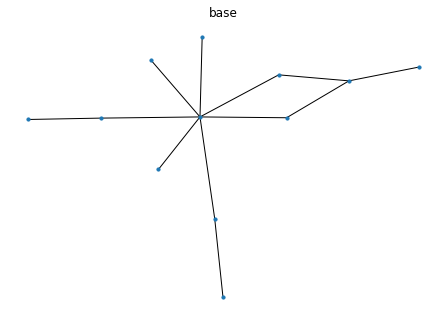

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 0.0, 0.0, 0, 0, 6, 8.0, 26.0, 3, 0, 0.1749, 0.0417, 0.0337, 2, 0.8788])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


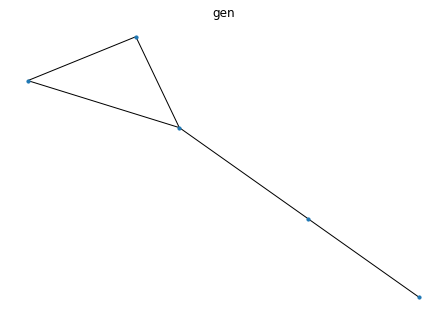

{'LCC': 5,
 'claw_count': 1.0,
 'cpl': 1.7,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 5,
 'gini': -0.03333333333333344,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 2.5732899022206244,
 'rel_edge_distr_entropy': 0.8690135303720694,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 6.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 1, 1.0, 3.0, 1, 0, 1.3121, 0.0, 0.0292, 1, 0.1667])
Testing set
Is there DIAG??  0.0


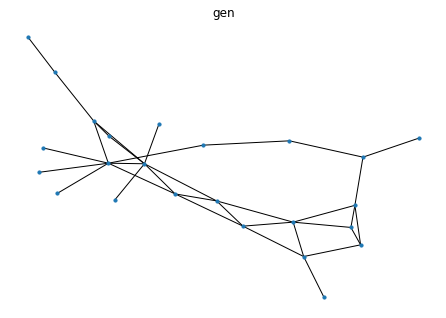

{'LCC': 24,
 'claw_count': 106.99999999999999,
 'cpl': 3.1594202898550723,
 'd': 2.2666667,
 'd_max': 7.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.4068627450980391,
 'n_components': 7,
 'node_num': 30,
 'power_law_exp': 2.2067912196699133,
 'rel_edge_distr_entropy': 0.8774177781005779,
 'square_count': 0,
 'triangle_count': 9,
 'wedge_count': 101.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


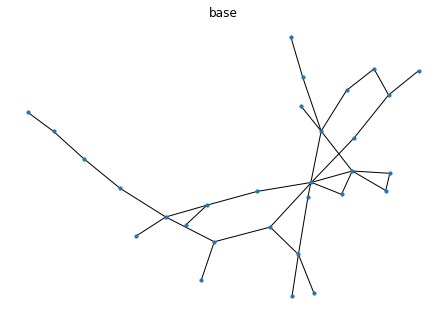

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 6, 35.0, 65.0, 7, 0, 0.2701, 0.1873, 0.0819, 6, 1.0314])
Is there DIAG??  0.0


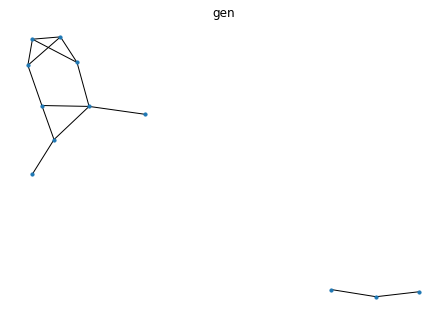

{'LCC': 9,
 'claw_count': 10.0,
 'cpl': 1.9487179487179487,
 'd': 2.3333333,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.06547619047619047,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.383905025044774,
 'rel_edge_distr_entropy': 0.9571218155451168,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 25.0}
Is there DIAG on base??  0.0


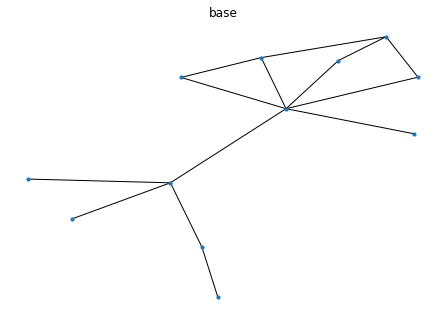

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 3, 6.0, 16.0, 2, 0, 0.0889, 0.0833, 0.0248, 1, 0.4301])
Is there DIAG??  0.0


{'LCC': 13,
 'claw_count': 9.0,
 'cpl': 3.641025641025641,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.18666666666666676,
 'n_components': 3,
 'node_num': 15,
 'power_law_exp': 2.34687885576197,
 'rel_edge_distr_entropy': 0.9165892224350334,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 25.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


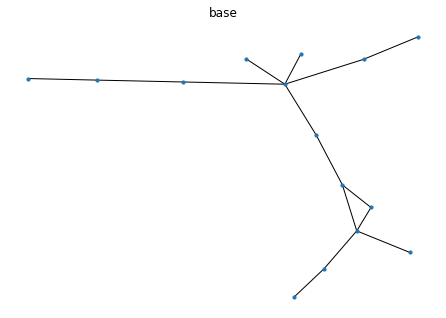

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 2, 0.0, 6.0, 2, 0, 0.4706, 0.0311, 0.0291, 2, 0.1934])
Is there DIAG??  0.0


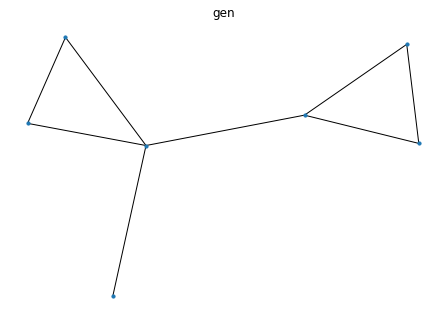

{'LCC': 7,
 'claw_count': 5.0,
 'cpl': 1.9047619047619047,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.15277777777777768,
 'n_components': 3,
 'node_num': 9,
 'power_law_exp': 2.331432460643355,
 'rel_edge_distr_entropy': 0.8526247063052855,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 13.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


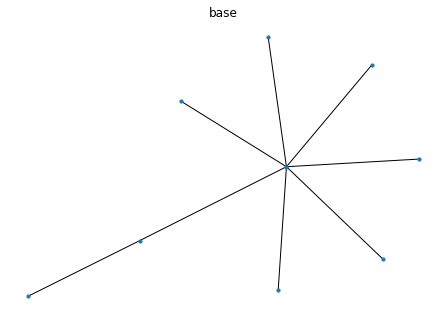

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 2, 9.0, 30.0, 2, 0, 2.0789, 0.0, 0.0177, 2, 0.0397])
26 data training in total 
[17/30]: vae_loss:6.1958, prior_loss:0.2994
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


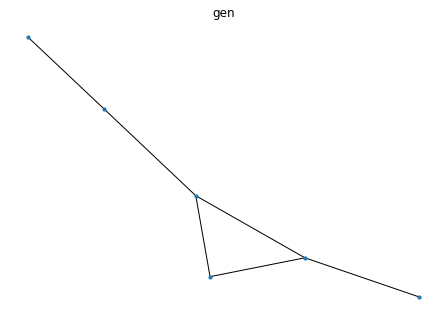

{'LCC': 6,
 'claw_count': 2.0,
 'cpl': 1.9333333333333333,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': 0.04761904761904767,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 2.674331879653742,
 'rel_edge_distr_entropy': 0.8759405616457789,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


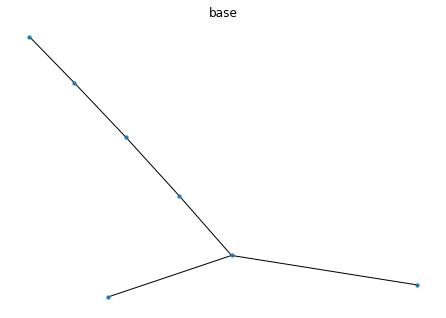

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 1, 2.0, 1.0, 1, 0, 0.5283, 0.119, 0.0818, 1, 0.5429])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


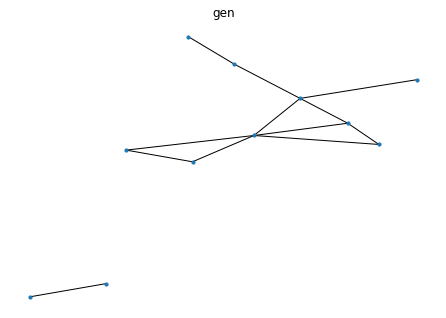

{'LCC': 9,
 'claw_count': 15.0,
 'cpl': 2.081081081081081,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.19444444444444442,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.6018795500591496,
 'rel_edge_distr_entropy': 0.9027638874227625,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 23.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


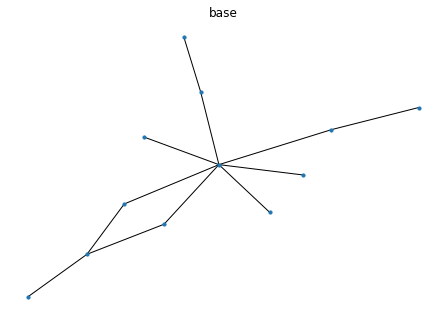

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 3, 5.0, 21.0, 3, 0, 0.461, 0.0139, 0.0005, 2, 0.3432])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


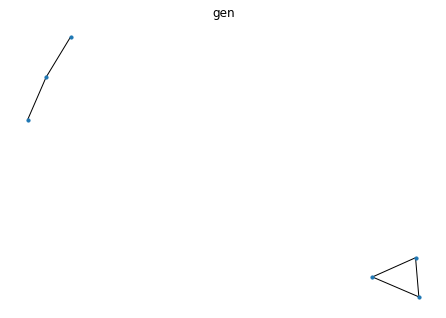

{'LCC': 3,
 'claw_count': 0.0,
 'cpl': 1.1666666666666667,
 'd': 1.6666666,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.20000000000000007,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 3.1640425613334453,
 'rel_edge_distr_entropy': 0.9755815145647054,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 4.0}
Is there DIAG on base??  0.0


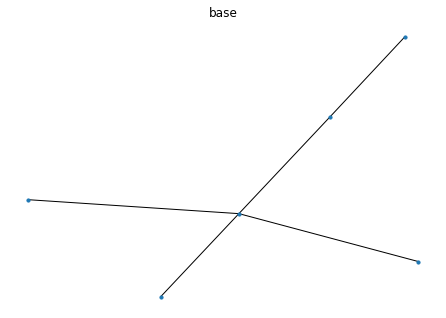

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 3, 3.0, 4.0, 1, 0, 0.7213, 0.1667, 0.0774, 1, 0.7])
Testing set
Is there DIAG??  0.0


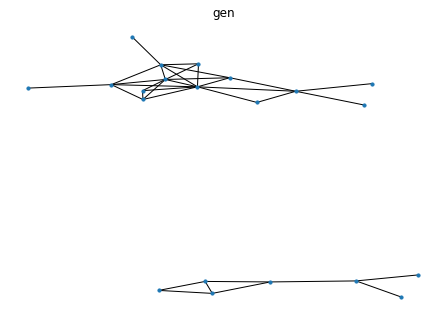

{'LCC': 14,
 'claw_count': 173.0,
 'cpl': 2.044642857142857,
 'd': 2.2666667,
 'd_max': 9.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.48039215686274495,
 'n_components': 11,
 'node_num': 30,
 'power_law_exp': 2.0550469841647754,
 'rel_edge_distr_entropy': 0.8346763150169364,
 'square_count': 5,
 'triangle_count': 20,
 'wedge_count': 124.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


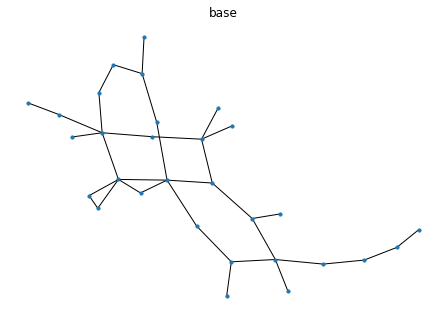

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 16, 58.0, 131.0, 18, 5, 0.4218, 0.2608, 0.1246, 10, 2.1462])
Is there DIAG??  0.0


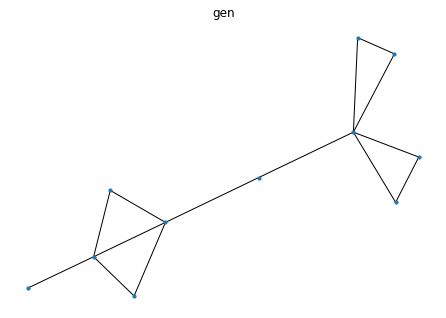

{'LCC': 11,
 'claw_count': 18.0,
 'cpl': 2.581818181818182,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.11904761904761907,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.191242388995403,
 'rel_edge_distr_entropy': 0.9264364315613645,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 29.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


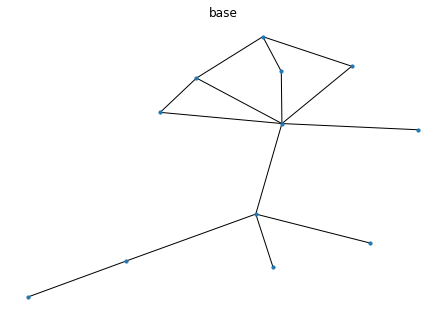

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 1, 2.0, 8.0, 3, 0, 0.2815, 0.0298, 0.0059, 1, 0.203])
Is there DIAG??  0.0


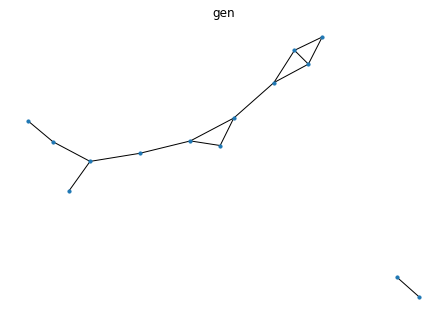

{'LCC': 12,
 'claw_count': 6.0,
 'cpl': 3.3134328358208953,
 'd': 2.0,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.12888888888888883,
 'n_components': 3,
 'node_num': 15,
 'power_law_exp': 2.4950456662658347,
 'rel_edge_distr_entropy': 0.9442750226706554,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 22.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


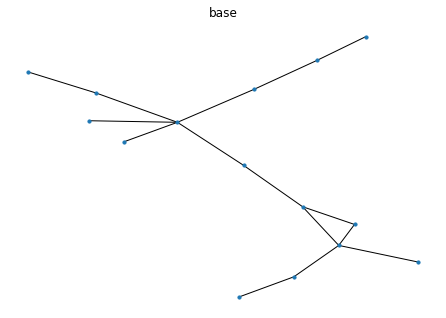

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 3, 3.0, 9.0, 2, 0, 0.3224, 0.0267, 0.0014, 2, 0.1342])
Is there DIAG??  0.0


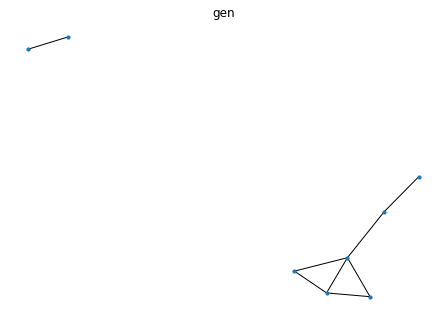

{'LCC': 6,
 'claw_count': 5.0,
 'cpl': 1.6875,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.125,
 'n_components': 3,
 'node_num': 9,
 'power_law_exp': 2.752714662512919,
 'rel_edge_distr_entropy': 0.8920549676513547,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 12.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


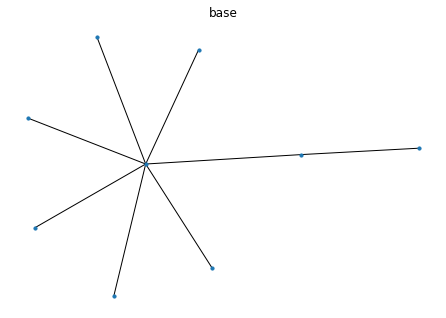

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 3, 10.0, 30.0, 2, 0, 1.6576, 0.0278, 0.0571, 2, 0.2569])
26 data training in total 
[18/30]: vae_loss:9.7725, prior_loss:0.2550
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


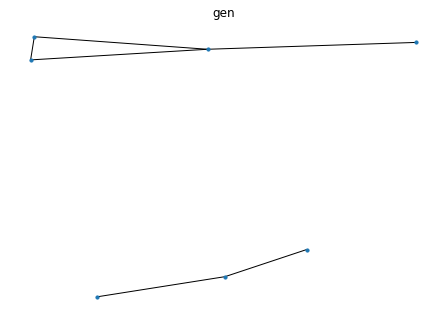

{'LCC': 4,
 'claw_count': 1.0,
 'cpl': 1.3333333333333333,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.0714285714285714,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 3.2026058631088743,
 'rel_edge_distr_entropy': 0.9577121084628163,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 6.0}
Is there DIAG on base??  0.0


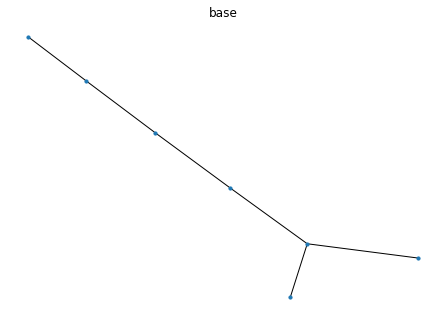

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 0.0, 0.0, 0, 0, 3, 0.0, 0.0, 1, 0, 0.0, 0.0, 0.0, 1, 1.1429])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


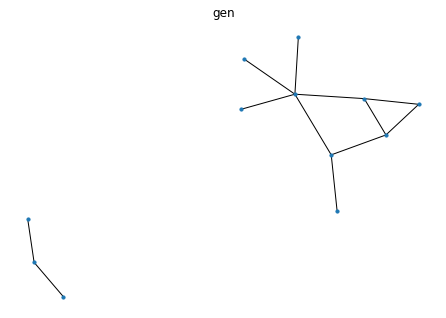

{'LCC': 9,
 'claw_count': 13.0,
 'cpl': 1.9743589743589745,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 1.0,
 'edge_num': 12,
 'gini': 0.14583333333333348,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.9073143334863554,
 'rel_edge_distr_entropy': 0.9317051523945278,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 21.0}
Is there DIAG on base??  0.0


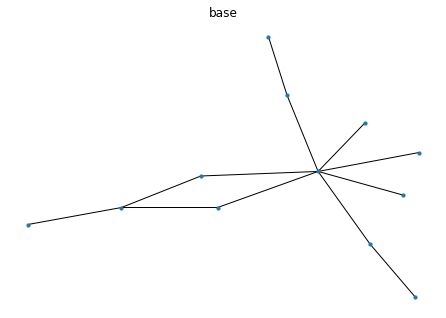

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 3, 7.0, 23.0, 1, 0, 0.1556, 0.0347, 0.0294, 1, 0.4499])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


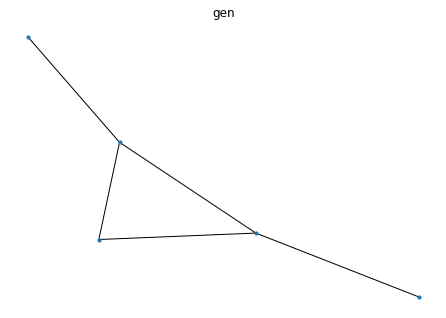

{'LCC': 5,
 'claw_count': 2.0,
 'cpl': 1.6,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 5,
 'gini': 0.033333333333333215,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 2.7298812813059676,
 'rel_edge_distr_entropy': 0.8398104526213844,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 7.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


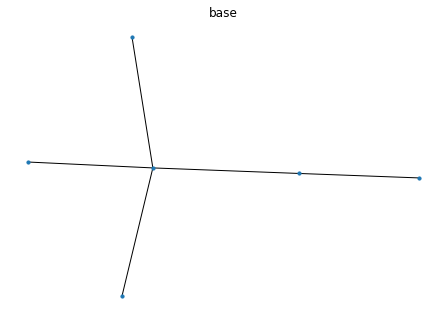

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 1, 0.0, 2.0, 1, 0, 1.1555, 0.0667, 0.0584, 1, 0.2667])
Testing set
Is there DIAG??  0.0


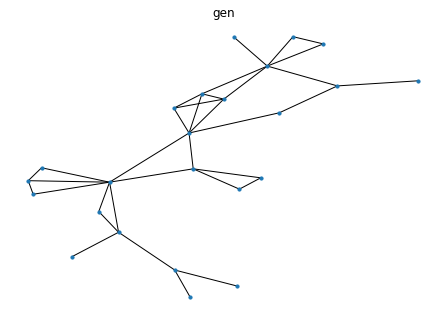

{'LCC': 24,
 'claw_count': 95.0,
 'cpl': 3.2681159420289854,
 'd': 2.2666667,
 'd_max': 7.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.3813725490196078,
 'n_components': 7,
 'node_num': 30,
 'power_law_exp': 2.1420830753244156,
 'rel_edge_distr_entropy': 0.8878672801964316,
 'square_count': 1,
 'triangle_count': 11,
 'wedge_count': 95.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


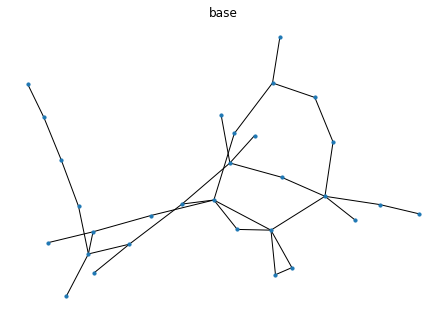

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 6, 29.0, 53.0, 9, 1, 0.3348, 0.1618, 0.0715, 6, 0.9227])
Is there DIAG??  0.0


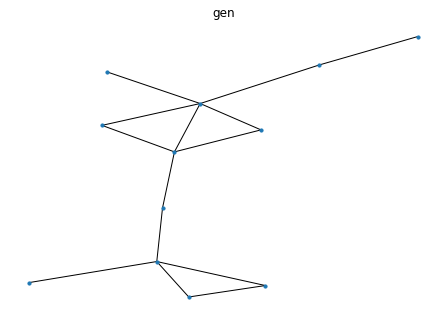

{'LCC': 12,
 'claw_count': 18.0,
 'cpl': 2.8333333333333335,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.1071428571428572,
 'n_components': 1,
 'node_num': 12,
 'power_law_exp': 2.4050025578262244,
 'rel_edge_distr_entropy': 0.9463595707736584,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 28.0}
Is there DIAG on base??  0.0


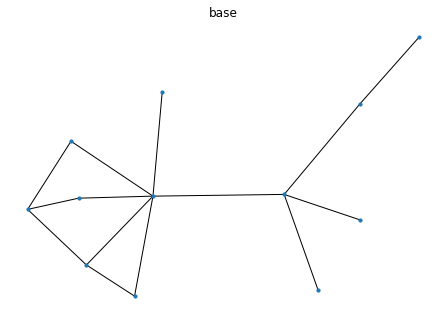

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 0, 3.0, 8.0, 2, 0, 0.0678, 0.0417, 0.014, 0, 0.4545])
Is there DIAG??  0.0


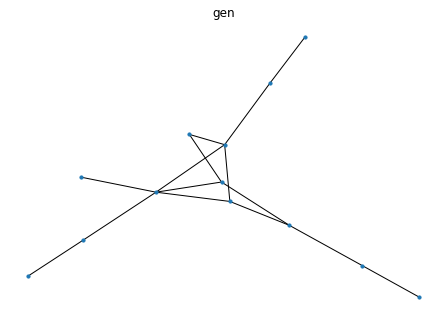

{'LCC': 13,
 'claw_count': 17.0,
 'cpl': 2.730769230769231,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.24444444444444446,
 'n_components': 3,
 'node_num': 15,
 'power_law_exp': 2.434220387399688,
 'rel_edge_distr_entropy': 0.8986732963738753,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 29.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


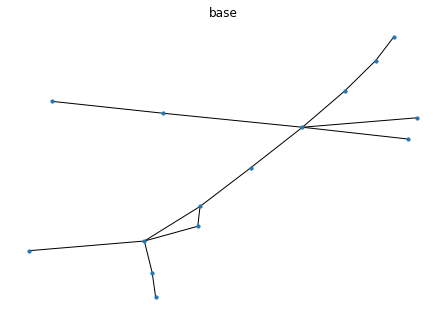

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 2, 4.0, 2.0, 0, 0, 0.3833, 0.0889, 0.047, 2, 0.7168])
Is there DIAG??  0.0


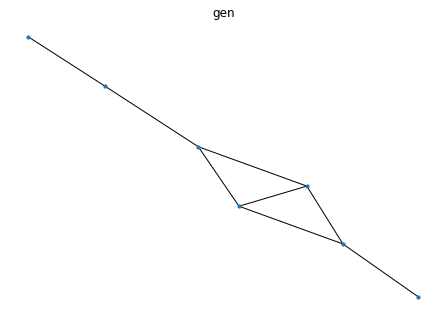

{'LCC': 7,
 'claw_count': 4.0,
 'cpl': 2.142857142857143,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.15277777777777768,
 'n_components': 3,
 'node_num': 9,
 'power_law_exp': 2.3758953224185513,
 'rel_edge_distr_entropy': 0.8474064556100452,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 13.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


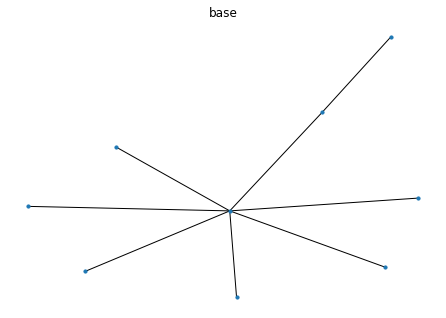

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 2, 9.0, 31.0, 2, 0, 2.0344, 0.0, 0.0125, 2, 0.1984])
26 data training in total 
[19/30]: vae_loss:3.5620, prior_loss:0.1959
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


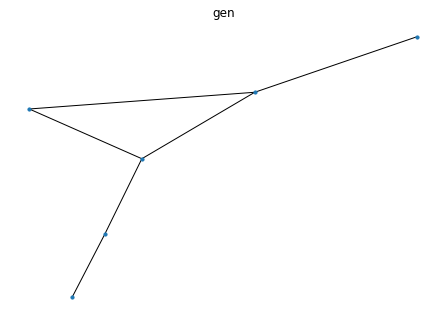

{'LCC': 6,
 'claw_count': 2.0,
 'cpl': 1.9333333333333333,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': 0.04761904761904767,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 2.674331879653742,
 'rel_edge_distr_entropy': 0.8759405616457789,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


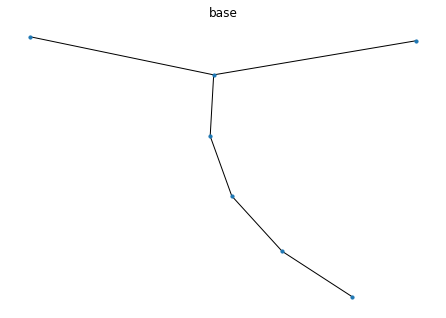

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 1, 2.0, 1.0, 1, 0, 0.5283, 0.119, 0.0818, 1, 0.5429])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


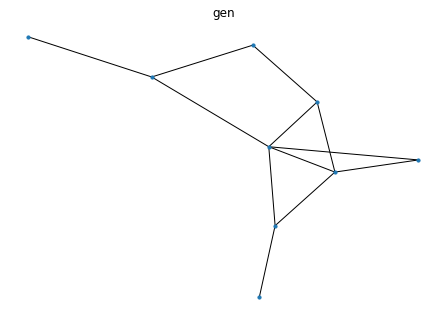

{'LCC': 9,
 'claw_count': 17.0,
 'cpl': 2.0277777777777777,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.2777777777777779,
 'n_components': 4,
 'node_num': 12,
 'power_law_exp': 2.1722010946411068,
 'rel_edge_distr_entropy': 0.8387291594834336,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 27.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


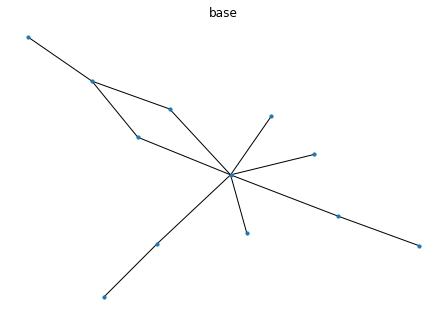

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 3, 1.0, 19.0, 3, 0, 0.8907, 0.0972, 0.0635, 3, 0.3965])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


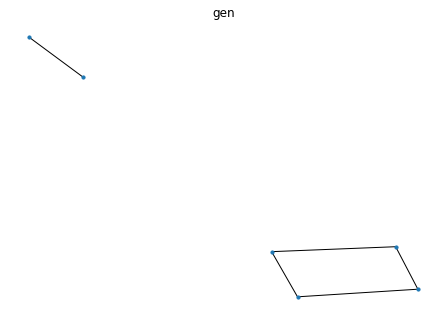

{'LCC': 4,
 'claw_count': 0.0,
 'cpl': 1.2857142857142858,
 'd': 1.6666666,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.20000000000000007,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 3.1640425613334453,
 'rel_edge_distr_entropy': 0.9755815145647054,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 4.0}
Is there DIAG on base??  0.0


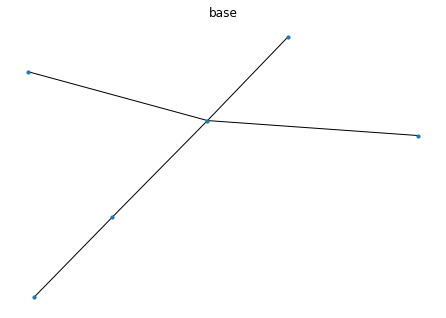

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 2, 3.0, 4.0, 0, 0, 0.7213, 0.1667, 0.0774, 1, 0.581])
Testing set
Is there DIAG??  0.0


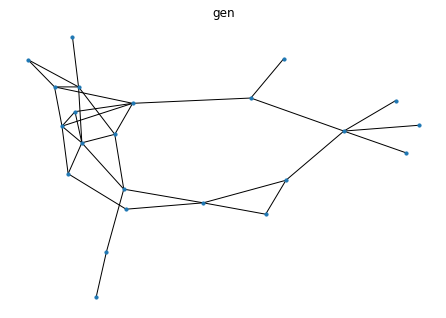

{'LCC': 23,
 'claw_count': 80.0,
 'cpl': 3.0316205533596836,
 'd': 2.2666667,
 'd_max': 6.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.3970588235294117,
 'n_components': 8,
 'node_num': 30,
 'power_law_exp': 2.0982857629004896,
 'rel_edge_distr_entropy': 0.8780457197904977,
 'square_count': 0,
 'triangle_count': 8,
 'wedge_count': 95.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


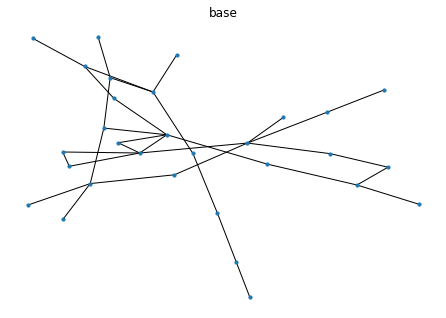

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 7, 29.0, 38.0, 6, 0, 0.3786, 0.1775, 0.0813, 7, 1.1592])
Is there DIAG??  0.0


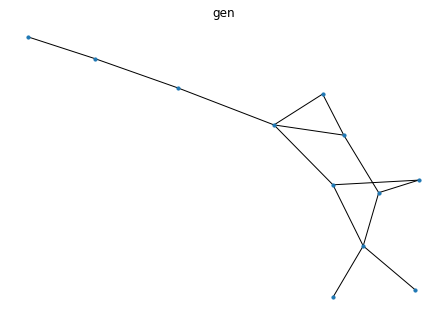

{'LCC': 12,
 'claw_count': 11.0,
 'cpl': 2.6666666666666665,
 'd': 2.3333333,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.07738095238095255,
 'n_components': 1,
 'node_num': 12,
 'power_law_exp': 2.357310324197768,
 'rel_edge_distr_entropy': 0.9597584307090183,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 25.0}
Is there DIAG on base??  0.0


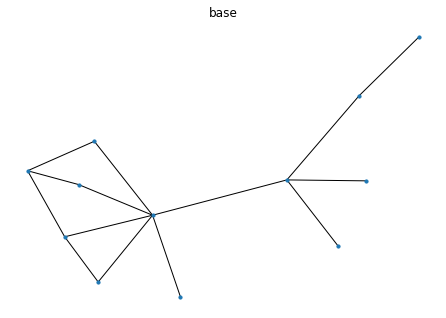

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 0, 6.0, 15.0, 0, 0, 0.1155, 0.0714, 0.0274, 0, 0.2879])
Is there DIAG??  0.0


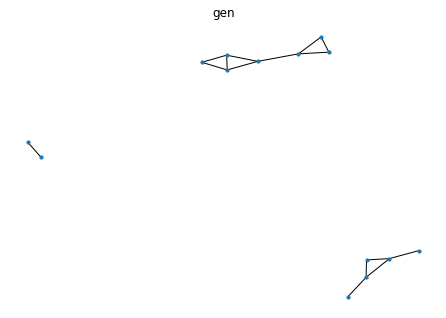

{'LCC': 7,
 'claw_count': 6.0,
 'cpl': 1.84375,
 'd': 2.0,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.12888888888888883,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.4950456662658347,
 'rel_edge_distr_entropy': 0.9442751107113346,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 22.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


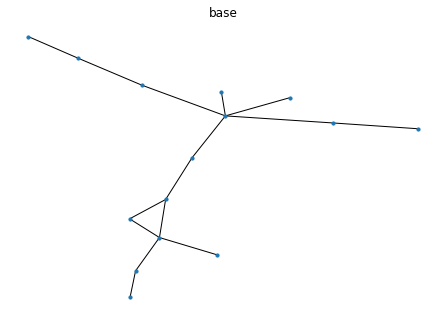

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 8, 3.0, 9.0, 3, 0, 0.3224, 0.0267, 0.0014, 3, 1.6039])
Is there DIAG??  0.0


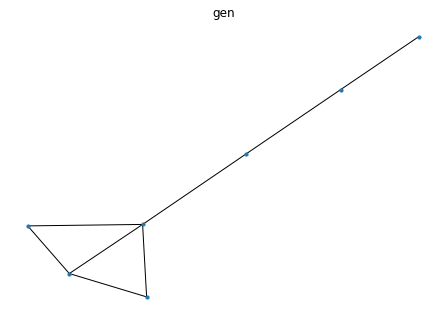

{'LCC': 7,
 'claw_count': 5.0,
 'cpl': 2.0952380952380953,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.15277777777777768,
 'n_components': 3,
 'node_num': 9,
 'power_law_exp': 2.331432460643355,
 'rel_edge_distr_entropy': 0.8526247063052855,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 13.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


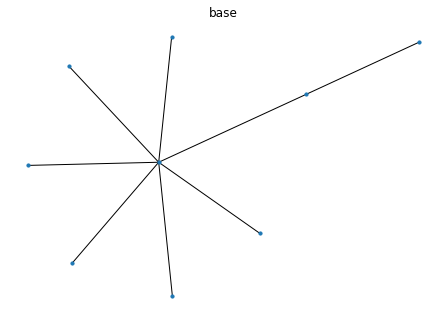

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 2, 9.0, 30.0, 2, 0, 2.0789, 0.0, 0.0177, 2, 0.1508])
26 data training in total 
[20/30]: vae_loss:5.1406, prior_loss:0.1846
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


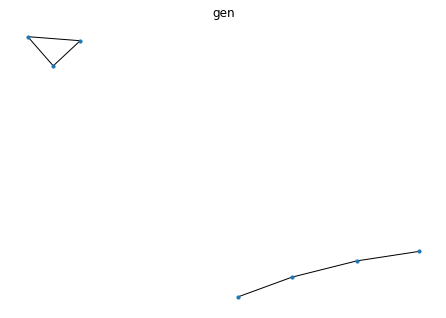

{'LCC': 4,
 'claw_count': 0.0,
 'cpl': 1.4444444444444444,
 'd': 1.7142857,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.16666666666666663,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 3.019773057244549,
 'rel_edge_distr_entropy': 0.98012020142357,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


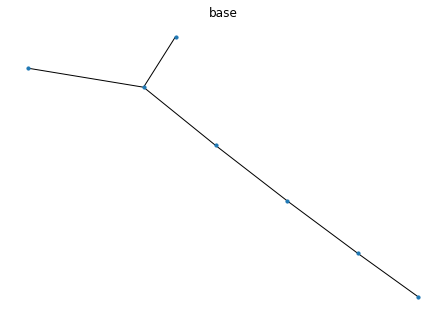

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 3, 1.0, 1.0, 1, 0, 0.1828, 0.0952, 0.0224, 1, 1.0317])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


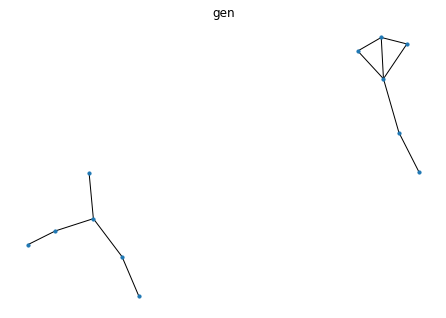

{'LCC': 6,
 'claw_count': 6.0,
 'cpl': 1.9,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 12,
 'gini': 0.07638888888888906,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.702307587146641,
 'rel_edge_distr_entropy': 0.959187164090173,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 17.0}
Is there DIAG on base??  0.0


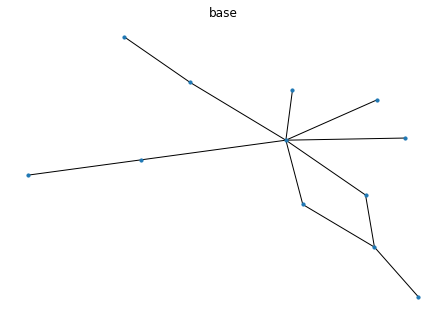

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 0.0, 0.0, 0, 0, 6, 11.0, 30.0, 2, 0, 0.3606, 0.1042, 0.0569, 1, 0.5242])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


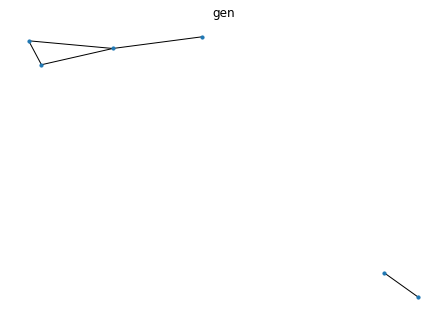

{'LCC': 4,
 'claw_count': 1.0,
 'cpl': 1.2857142857142858,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.10000000000000009,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 3.414577626291068,
 'rel_edge_distr_entropy': 0.9463784368140203,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


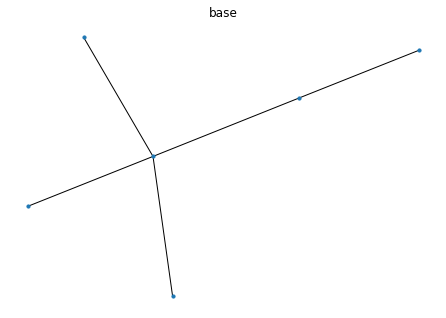

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 2, 2.0, 3.0, 1, 0, 0.4708, 0.0667, 0.0482, 1, 0.581])
Testing set
Is there DIAG??  0.0


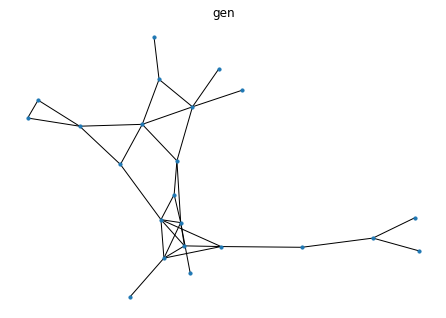

{'LCC': 23,
 'claw_count': 90.0,
 'cpl': 3.4268774703557314,
 'd': 2.2666667,
 'd_max': 6.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.4117647058823528,
 'n_components': 8,
 'node_num': 30,
 'power_law_exp': 2.125745761602621,
 'rel_edge_distr_entropy': 0.872351063951504,
 'square_count': 2,
 'triangle_count': 13,
 'wedge_count': 99.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


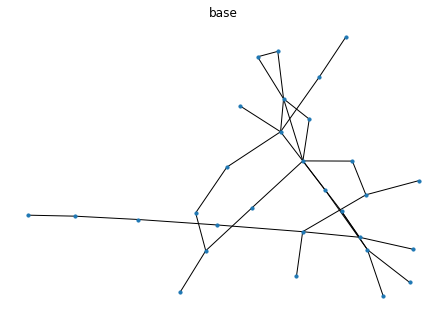

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 7, 33.0, 48.0, 11, 2, 0.3511, 0.1922, 0.087, 7, 0.7639])
Is there DIAG??  0.0


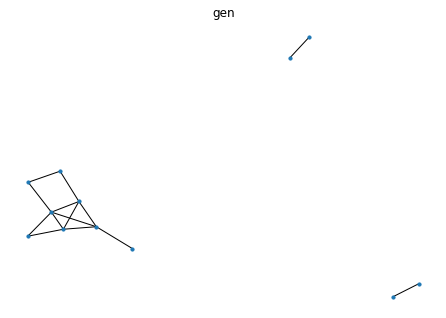

{'LCC': 8,
 'claw_count': 22.0,
 'cpl': 1.6666666666666667,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.1607142857142858,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.529098254782707,
 'rel_edge_distr_entropy': 0.9264349923609475,
 'square_count': 1,
 'triangle_count': 5,
 'wedge_count': 31.0}
Is there DIAG on base??  0.0


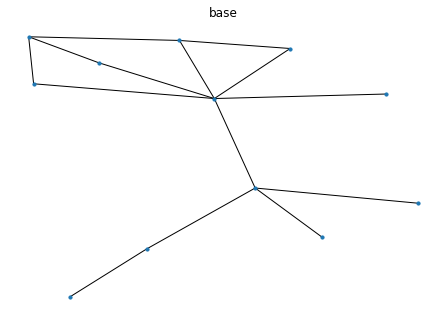

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 4, 0.0, 4.0, 4, 1, 0.0563, 0.0119, 0.0059, 2, 0.7121])
Is there DIAG??  0.0


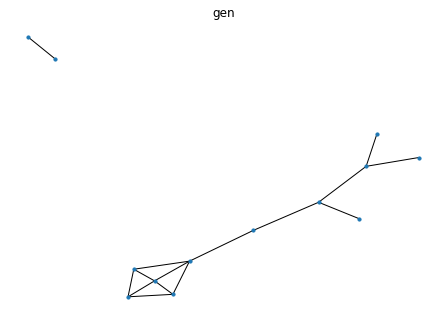

{'LCC': 11,
 'claw_count': 13.0,
 'cpl': 2.8035714285714284,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.23111111111111104,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.4510876290332426,
 'rel_edge_distr_entropy': 0.8995253540674902,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 28.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


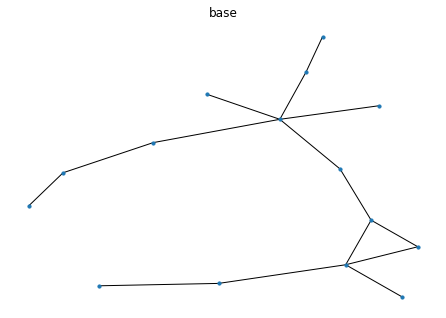

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 4, 3.0, 2.0, 3, 0, 0.3664, 0.0756, 0.0462, 3, 0.644])
Is there DIAG??  0.0


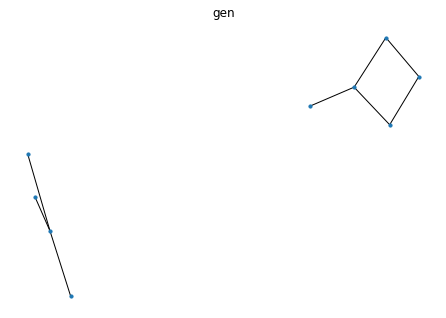

{'LCC': 5,
 'claw_count': 2.0,
 'cpl': 1.5625,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 8,
 'gini': 0.01388888888888884,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 3.1044429818782895,
 'rel_edge_distr_entropy': 0.9560345699882202,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 9.0}
Is there DIAG on base??  0.0


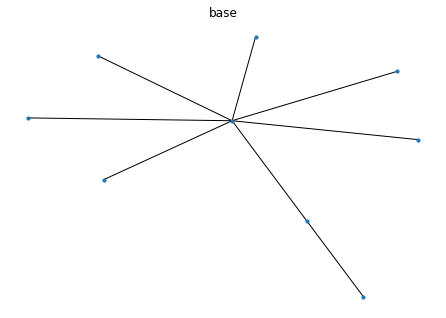

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 0.0, 0.0, 0, 0, 4, 13.0, 33.0, 0, 0, 1.3059, 0.1389, 0.1211, 1, 0.3819])
26 data training in total 
[21/30]: vae_loss:3.8903, prior_loss:0.1838
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


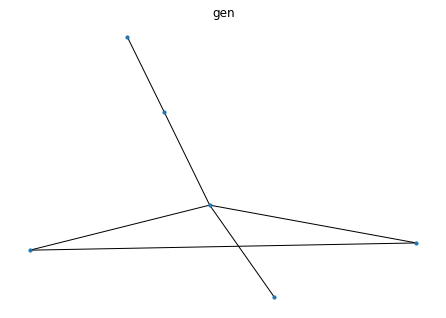

{'LCC': 6,
 'claw_count': 4.0,
 'cpl': 1.8,
 'd': 1.7142857,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': 0.0714285714285714,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 2.7312340490667566,
 'rel_edge_distr_entropy': 0.8613887603632371,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 9.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


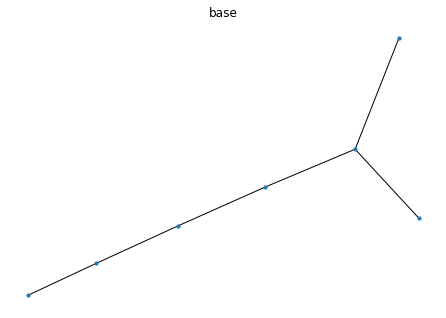

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 1, 3.0, 3.0, 1, 0, 0.4714, 0.1429, 0.0963, 1, 0.6762])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


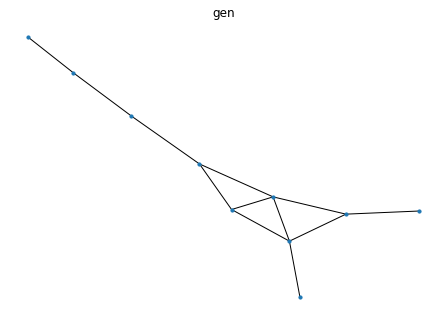

{'LCC': 10,
 'claw_count': 11.0,
 'cpl': 2.6444444444444444,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.2152777777777779,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.3414320146061485,
 'rel_edge_distr_entropy': 0.8806809881180586,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 23.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


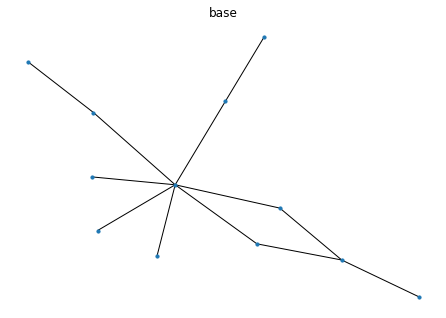

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 2, 5.0, 25.0, 3, 0, 0.7214, 0.0347, 0.0216, 2, 0.2202])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


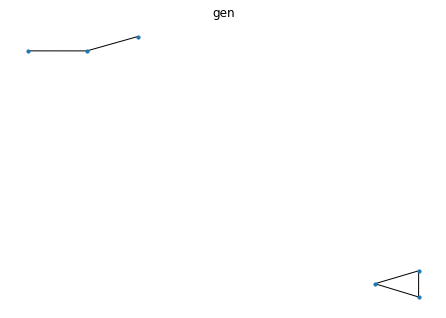

{'LCC': 3,
 'claw_count': 0.0,
 'cpl': 1.1666666666666667,
 'd': 1.6666666,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.20000000000000007,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 3.1640425613334453,
 'rel_edge_distr_entropy': 0.9755815145647054,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 4.0}
Is there DIAG on base??  0.0


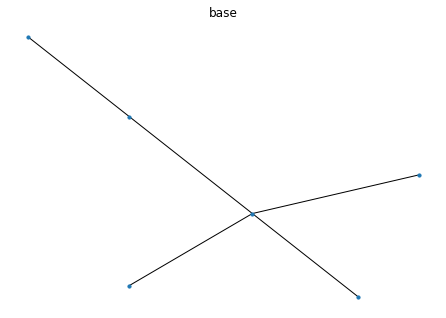

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 0.0, 0.0, 0, 0, 3, 3.0, 4.0, 1, 0, 0.7213, 0.1667, 0.0774, 1, 0.7])
Testing set
Is there DIAG??  0.0


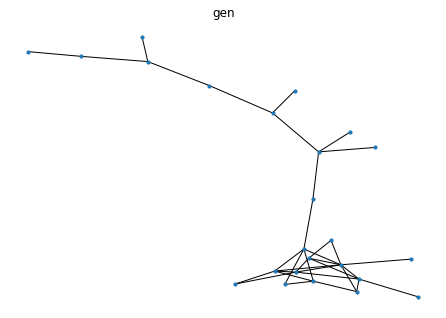

{'LCC': 24,
 'claw_count': 111.0,
 'cpl': 4.057971014492754,
 'd': 2.2666667,
 'd_max': 8.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.4049019607843136,
 'n_components': 7,
 'node_num': 30,
 'power_law_exp': 2.192203216046682,
 'rel_edge_distr_entropy': 0.8788384628772696,
 'square_count': 1,
 'triangle_count': 11,
 'wedge_count': 101.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


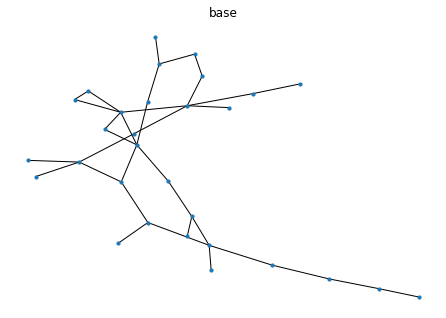

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 6, 35.0, 69.0, 9, 1, 0.2847, 0.1853, 0.0805, 6, 0.1328])
Is there DIAG??  0.0


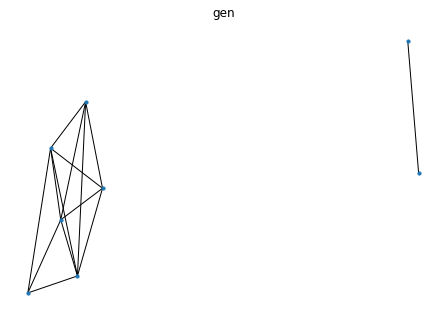

{'LCC': 6,
 'claw_count': 39.0,
 'cpl': 1.125,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.32738095238095255,
 'n_components': 6,
 'node_num': 12,
 'power_law_exp': 1.9195915210840804,
 'rel_edge_distr_entropy': 0.7872265570150141,
 'square_count': 6,
 'triangle_count': 13,
 'wedge_count': 45.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


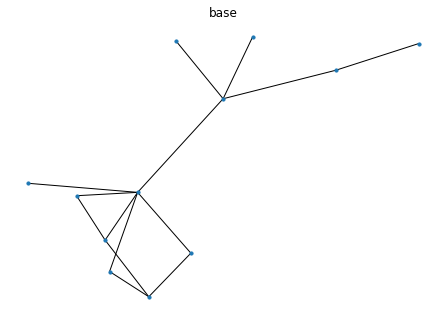

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 6, 14.0, 13.0, 12, 6, 0.5532, 0.1786, 0.1451, 5, 1.2538])
Is there DIAG??  0.0


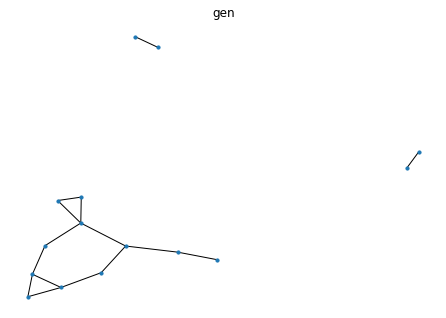

{'LCC': 11,
 'claw_count': 7.0,
 'cpl': 2.456140350877193,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 15,
 'gini': 0.10666666666666669,
 'n_components': 3,
 'node_num': 15,
 'power_law_exp': 2.6966379052472105,
 'rel_edge_distr_entropy': 0.9635958138503313,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 21.0}
Is there DIAG on base??  0.0


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 4, 4.0, 8.0, 1, 0, 0.1208, 0.0489, 0.0179, 2, 0.9915])
Is there DIAG??  0.0


{'LCC': 5,
 'claw_count': 6.0,
 'cpl': 1.2727272727272727,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.19444444444444442,
 'n_components': 4,
 'node_num': 9,
 'power_law_exp': 2.408503615336456,
 'rel_edge_distr_entropy': 0.8377409104622672,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 14.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


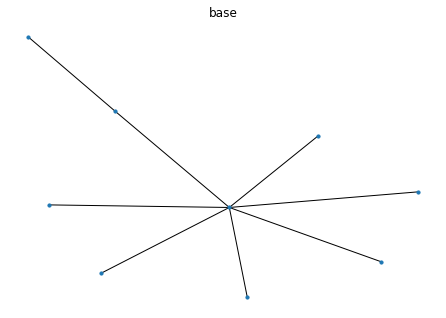

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 4, 8.0, 29.0, 3, 0, 2.0018, 0.0417, 0.0028, 3, 0.6717])
26 data training in total 
[22/30]: vae_loss:4.8753, prior_loss:0.1512
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


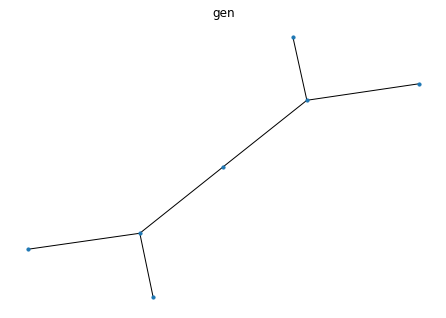

{'LCC': 7,
 'claw_count': 2.0,
 'cpl': 2.2857142857142856,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.023809523809523725,
 'n_components': 1,
 'node_num': 7,
 'power_law_exp': 3.421833793828355,
 'rel_edge_distr_entropy': 0.9353041380249751,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 7.0}
Is there DIAG on base??  0.0


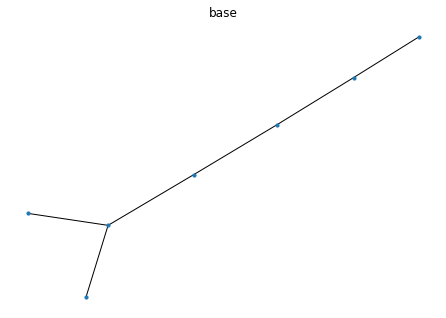

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 0.0, 0.0, 0, 0, 0, 1.0, 1.0, 0, 0, 0.2192, 0.0476, 0.0224, 0, 0.1905])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


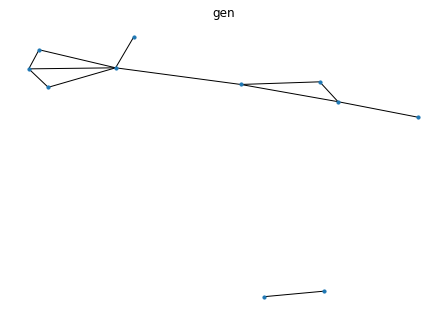

{'LCC': 9,
 'claw_count': 13.0,
 'cpl': 2.135135135135135,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.18055555555555558,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.5748671092505795,
 'rel_edge_distr_entropy': 0.9084615859268793,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 22.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


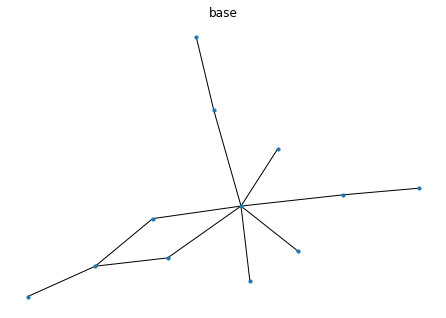

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 3, 6.0, 23.0, 3, 0, 0.488, 0.0, 0.0062, 2, 0.2891])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


{'LCC': 5,
 'claw_count': 2.0,
 'cpl': 1.6,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 5,
 'gini': 0.033333333333333215,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 2.7298812813059676,
 'rel_edge_distr_entropy': 0.8398104526213844,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 7.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 1, 0.0, 2.0, 1, 0, 1.1555, 0.0667, 0.0584, 1, 0.2667])
Testing set
Is there DIAG??  0.0


{'LCC': 21,
 'claw_count': 98.0,
 'cpl': 2.7934272300469485,
 'd': 2.2666667,
 'd_max': 8.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.36862745098039196,
 'n_components': 8,
 'node_num': 30,
 'power_law_exp': 2.1236751752882674,
 'rel_edge_distr_entropy': 0.8907489563441112,
 'square_count': 0,
 'triangle_count': 9,
 'wedge_count': 94.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


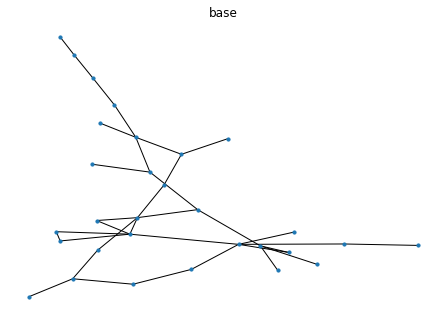

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 9, 28.0, 56.0, 7, 0, 0.3532, 0.149, 0.0686, 7, 1.3974])
Is there DIAG??  0.0


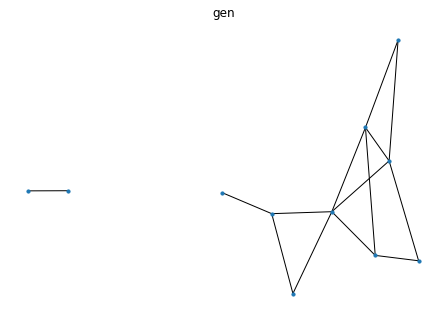

{'LCC': 9,
 'claw_count': 20.0,
 'cpl': 1.9189189189189189,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.1785714285714286,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.27039962184965,
 'rel_edge_distr_entropy': 0.9113956358436228,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 31.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 3, 0.0, 6.0, 3, 0, 0.2024, 0.0298, 0.0209, 2, 0.4599])
Is there DIAG??  0.0


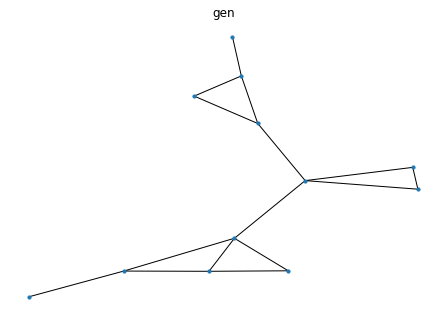

{'LCC': 12,
 'claw_count': 12.0,
 'cpl': 2.696969696969697,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.23555555555555552,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.207288813145534,
 'rel_edge_distr_entropy': 0.888903334158732,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 28.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


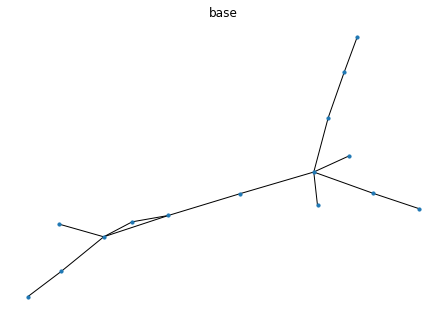

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 3, 3.0, 3.0, 3, 0, 0.6102, 0.08, 0.0568, 3, 0.7506])
Is there DIAG??  0.0


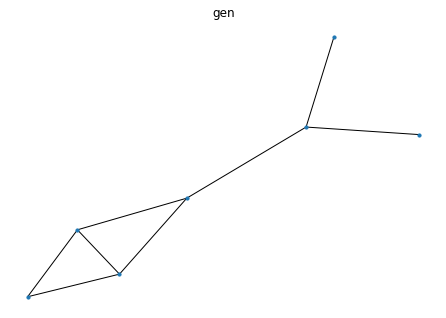

{'LCC': 7,
 'claw_count': 4.0,
 'cpl': 2.0476190476190474,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.15277777777777768,
 'n_components': 3,
 'node_num': 9,
 'power_law_exp': 2.3758953224185513,
 'rel_edge_distr_entropy': 0.847406509864531,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 13.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


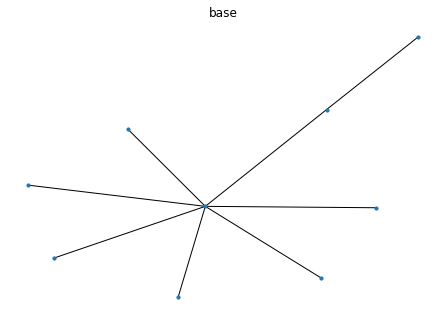

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 2, 9.0, 31.0, 2, 0, 2.0344, 0.0, 0.0125, 2, 0.1032])
26 data training in total 
[23/30]: vae_loss:5.7813, prior_loss:0.1472
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


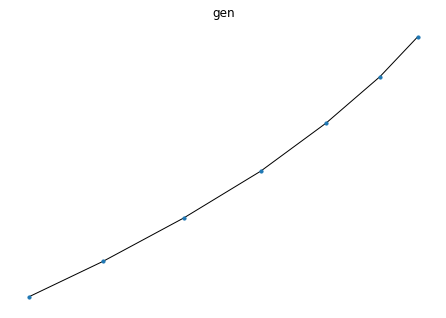

{'LCC': 7,
 'claw_count': 0.0,
 'cpl': 2.6666666666666665,
 'd': 1.7142857,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.16666666666666663,
 'n_components': 1,
 'node_num': 7,
 'power_law_exp': 3.019773057244549,
 'rel_edge_distr_entropy': 0.98012020142357,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


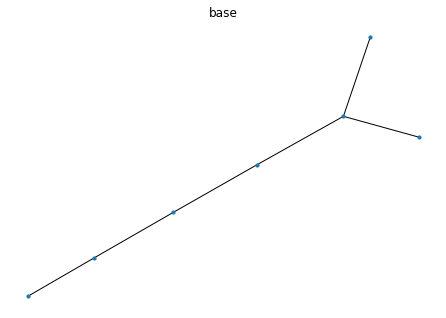

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 0, 1.0, 1.0, 0, 0, 0.1828, 0.0952, 0.0224, 0, 0.1905])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


{'LCC': 10,
 'claw_count': 5.0,
 'cpl': 2.652173913043478,
 'd': 2.0,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 12,
 'gini': 0.07638888888888906,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.7443493753033437,
 'rel_edge_distr_entropy': 0.9561111130656212,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 17.0}
Is there DIAG on base??  0.0


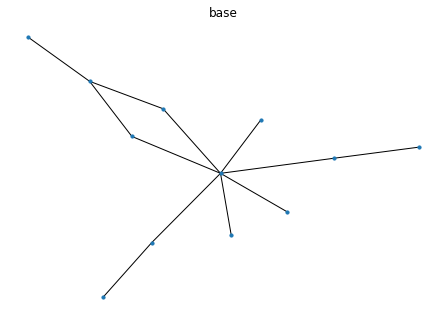

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 0.0, 0.0, 0, 0, 2, 11.0, 31.0, 2, 0, 0.3185, 0.1042, 0.0538, 1, 0.2279])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


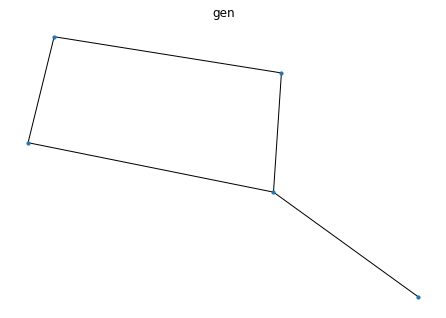

{'LCC': 5,
 'claw_count': 1.0,
 'cpl': 1.6,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 5,
 'gini': -0.03333333333333344,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 2.5732899022206244,
 'rel_edge_distr_entropy': 0.8690134638400981,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 6.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


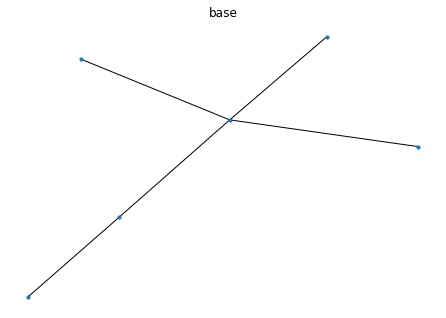

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 1, 1.0, 3.0, 0, 0, 1.3121, 0.0, 0.0292, 1, 0.2667])
Testing set
Is there DIAG??  0.0


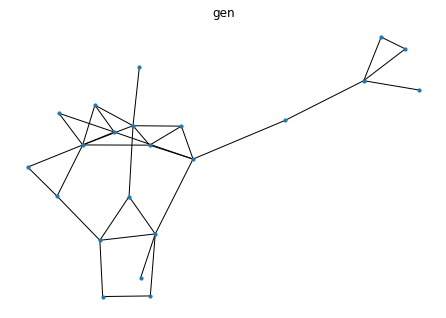

{'LCC': 22,
 'claw_count': 95.0,
 'cpl': 3.0043290043290045,
 'd': 2.2666667,
 'd_max': 7.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.4068627450980391,
 'n_components': 9,
 'node_num': 30,
 'power_law_exp': 2.011577862401287,
 'rel_edge_distr_entropy': 0.870756885573277,
 'square_count': 0,
 'triangle_count': 9,
 'wedge_count': 99.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


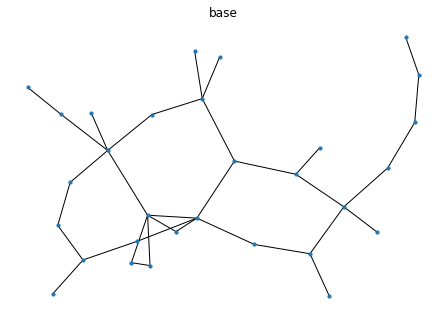

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 8, 33.0, 53.0, 7, 0, 0.4653, 0.1873, 0.0886, 8, 1.1865])
Is there DIAG??  0.0


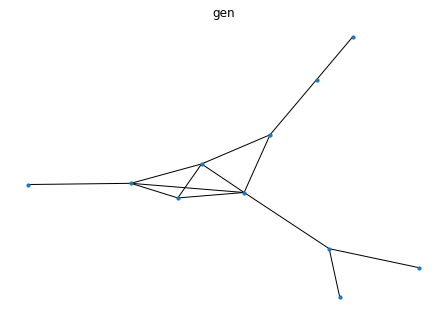

{'LCC': 11,
 'claw_count': 21.0,
 'cpl': 2.4727272727272727,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.19047619047619047,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.3140587700663393,
 'rel_edge_distr_entropy': 0.903875237984752,
 'square_count': 1,
 'triangle_count': 5,
 'wedge_count': 32.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


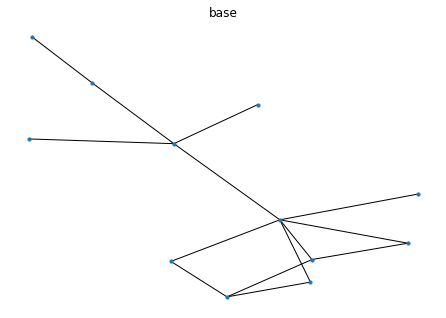

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 1, 1.0, 5.0, 4, 1, 0.1587, 0.0417, 0.0284, 1, 0.0939])
Is there DIAG??  0.0


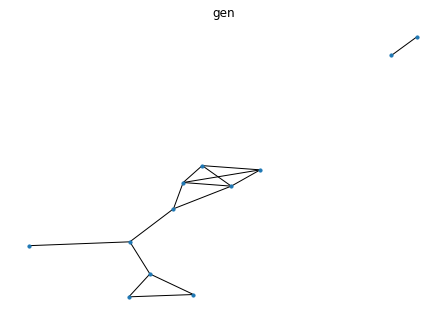

{'LCC': 10,
 'claw_count': 13.0,
 'cpl': 2.5,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.24888888888888894,
 'n_components': 5,
 'node_num': 15,
 'power_law_exp': 2.243272789934126,
 'rel_edge_distr_entropy': 0.8824627182694564,
 'square_count': 1,
 'triangle_count': 6,
 'wedge_count': 29.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


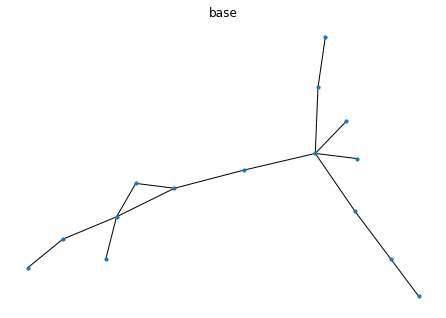

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 5, 4.0, 2.0, 5, 1, 0.5742, 0.0933, 0.0632, 4, 0.9476])
Is there DIAG??  0.0


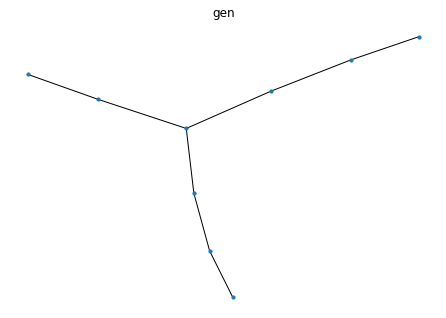

{'LCC': 9,
 'claw_count': 1.0,
 'cpl': 2.8333333333333335,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 8,
 'gini': -0.04166666666666674,
 'n_components': 1,
 'node_num': 9,
 'power_law_exp': 2.9718039953270337,
 'rel_edge_distr_entropy': 0.9709183115767528,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


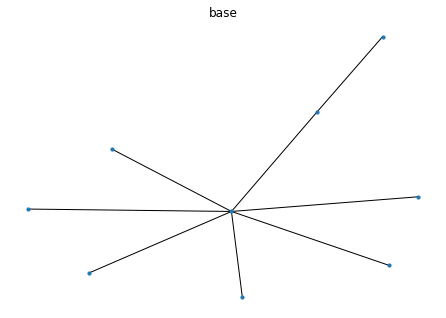

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 0.0, 0.0, 0, 0, 0, 14.0, 34.0, 0, 0, 1.4385, 0.1944, 0.136, 0, 0.8889])
26 data training in total 
[24/30]: vae_loss:5.0089, prior_loss:0.1782
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


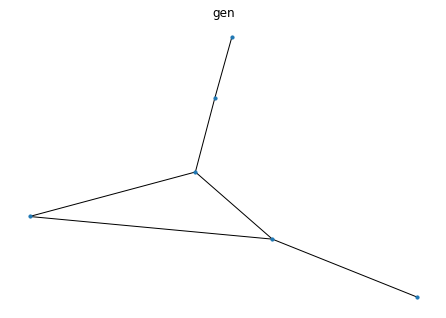

{'LCC': 6,
 'claw_count': 2.0,
 'cpl': 1.9333333333333333,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': 0.04761904761904767,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 2.674331879653742,
 'rel_edge_distr_entropy': 0.8759405616457789,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


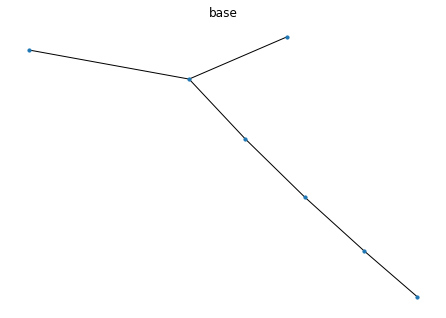

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 1, 2.0, 1.0, 1, 0, 0.5283, 0.119, 0.0818, 1, 0.5429])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


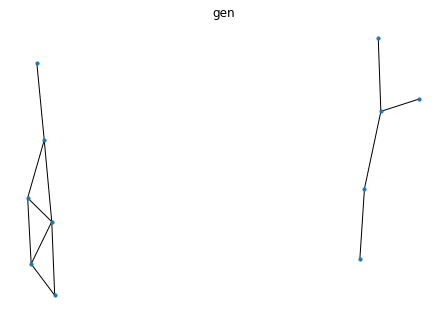

{'LCC': 6,
 'claw_count': 8.0,
 'cpl': 1.68,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.1527777777777779,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.5348042230159296,
 'rel_edge_distr_entropy': 0.9183960026184926,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 20.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


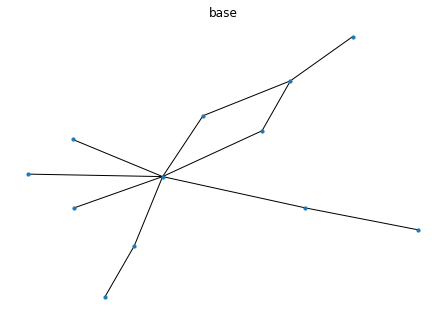

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 6, 8.0, 28.0, 3, 0, 0.5281, 0.0278, 0.0161, 2, 0.7442])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


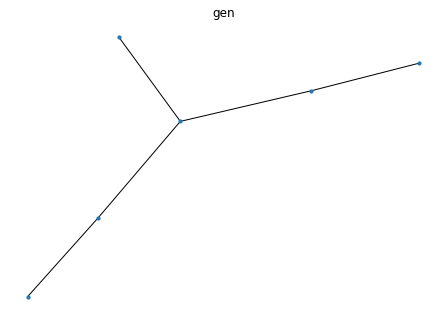

{'LCC': 6,
 'claw_count': 1.0,
 'cpl': 2.066666666666667,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.10000000000000009,
 'n_components': 1,
 'node_num': 6,
 'power_law_exp': 3.414577626291068,
 'rel_edge_distr_entropy': 0.9463784368140203,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


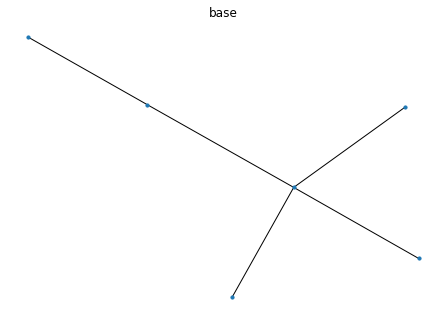

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 0, 2.0, 3.0, 0, 0, 0.4708, 0.0667, 0.0482, 0, 0.2])
Testing set
Is there DIAG??  0.0


{'LCC': 24,
 'claw_count': 131.0,
 'cpl': 3.5181159420289854,
 'd': 2.2666667,
 'd_max': 8.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.41470588235294104,
 'n_components': 7,
 'node_num': 30,
 'power_law_exp': 2.2050841994749266,
 'rel_edge_distr_entropy': 0.874410205181845,
 'square_count': 1,
 'triangle_count': 11,
 'wedge_count': 106.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


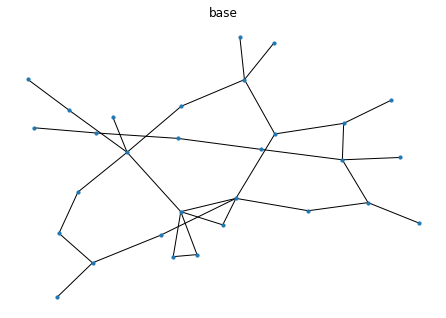

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 6, 40.0, 89.0, 9, 1, 0.2718, 0.1951, 0.0849, 6, 0.6727])
Is there DIAG??  0.0


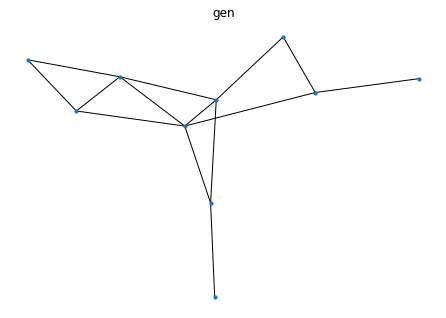

{'LCC': 10,
 'claw_count': 21.0,
 'cpl': 2.088888888888889,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.20833333333333348,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.103246451845914,
 'rel_edge_distr_entropy': 0.8839521947191525,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 33.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


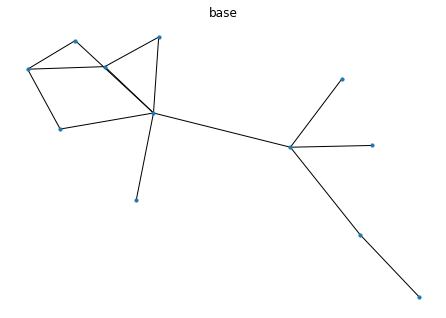

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 2, 2.0, 5.0, 3, 0, 0.3695, 0.0595, 0.0484, 2, 0.2899])
Is there DIAG??  0.0


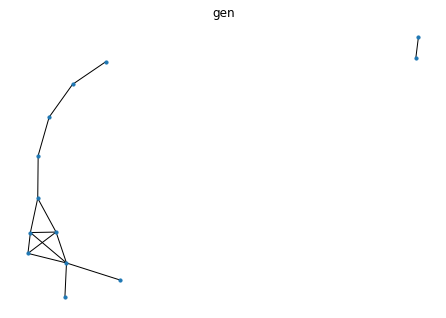

{'LCC': 11,
 'claw_count': 20.0,
 'cpl': 2.9107142857142856,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.2711111111111111,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.501381371276859,
 'rel_edge_distr_entropy': 0.888050131936287,
 'square_count': 1,
 'triangle_count': 5,
 'wedge_count': 31.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


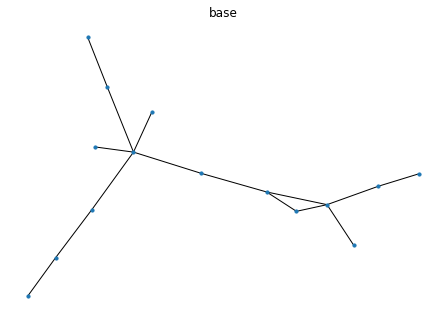

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 4, 6.0, 5.0, 4, 1, 0.3161, 0.1156, 0.0576, 3, 0.5369])
Is there DIAG??  0.0


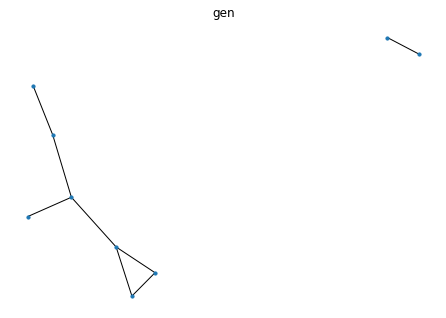

{'LCC': 7,
 'claw_count': 2.0,
 'cpl': 2.090909090909091,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 8,
 'gini': 0.01388888888888884,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 3.1044429818782895,
 'rel_edge_distr_entropy': 0.9560345699882202,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 9.0}
Is there DIAG on base??  0.0


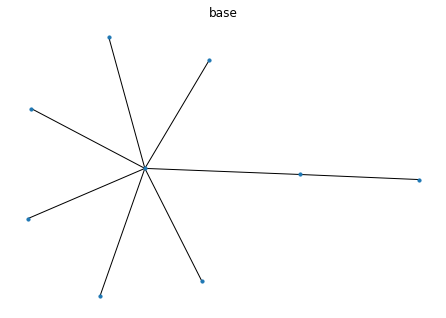

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 0.0, 0.0, 0, 0, 2, 13.0, 33.0, 1, 0, 1.3059, 0.1389, 0.1211, 1, 0.1465])
26 data training in total 
[25/30]: vae_loss:6.4001, prior_loss:0.1824
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


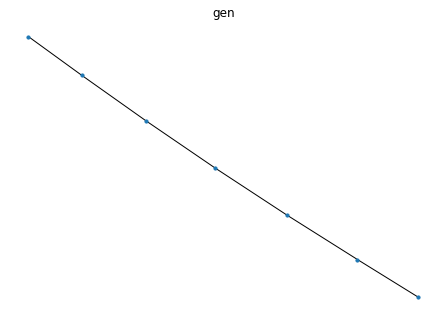

{'LCC': 7,
 'claw_count': 0.0,
 'cpl': 2.6666666666666665,
 'd': 1.7142857,
 'd_max': 2.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.16666666666666663,
 'n_components': 1,
 'node_num': 7,
 'power_law_exp': 3.019773057244549,
 'rel_edge_distr_entropy': 0.98012020142357,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 5.0}
Is there DIAG on base??  0.0


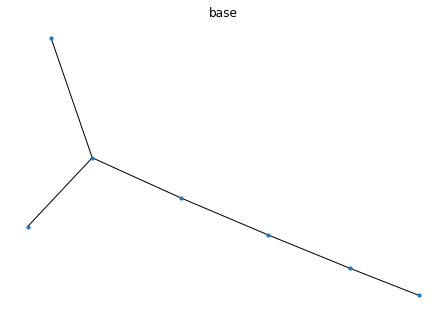

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 0, 1.0, 1.0, 0, 0, 0.1828, 0.0952, 0.0224, 0, 0.1905])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


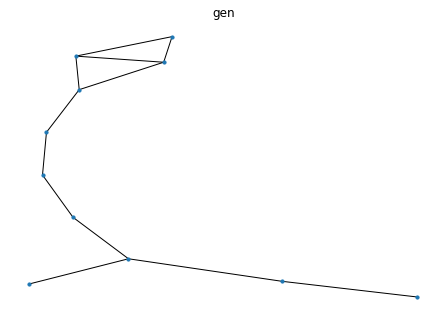

{'LCC': 11,
 'claw_count': 4.0,
 'cpl': 3.4363636363636365,
 'd': 2.0,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.07638888888888906,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.399458145014412,
 'rel_edge_distr_entropy': 0.9416412961266415,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 17.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


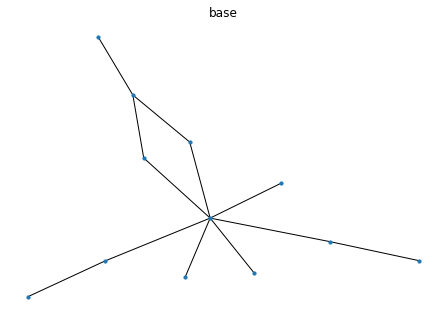

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 1, 11.0, 32.0, 2, 0, 0.6634, 0.1042, 0.0394, 1, 1.0121])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


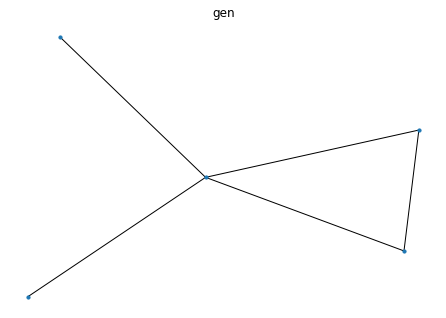

{'LCC': 5,
 'claw_count': 4.0,
 'cpl': 1.5,
 'd': 1.6666666,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 5,
 'gini': 0.06666666666666665,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 2.8033688011112043,
 'rel_edge_distr_entropy': 0.820845913399302,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


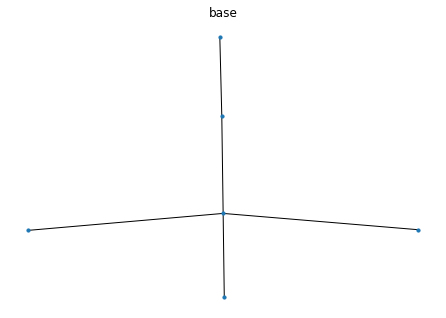

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 1, 1.0, 0.0, 1, 0, 1.082, 0.1, 0.0774, 1, 0.3667])
Testing set
Is there DIAG??  0.0


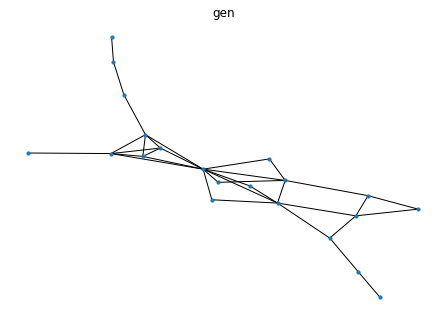

{'LCC': 21,
 'claw_count': 184.0,
 'cpl': 2.9047619047619047,
 'd': 2.2666667,
 'd_max': 10.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.46176470588235285,
 'n_components': 10,
 'node_num': 30,
 'power_law_exp': 2.0084545271699312,
 'rel_edge_distr_entropy': 0.841783454116913,
 'square_count': 5,
 'triangle_count': 17,
 'wedge_count': 122.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


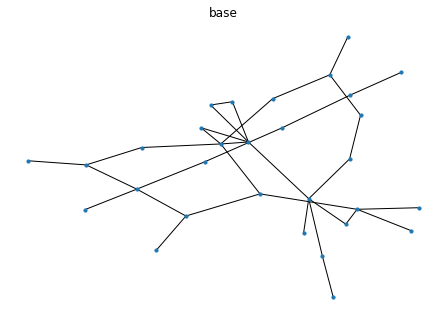

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([5.0, 1.0, 0.0, 0, 0, 9, 56.0, 142.0, 15, 5, 0.4684, 0.2422, 0.1175, 9, 1.286])
Is there DIAG??  0.0


{'LCC': 9,
 'claw_count': 17.0,
 'cpl': 2.1944444444444446,
 'd': 2.3333333,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.18452380952380953,
 'n_components': 4,
 'node_num': 12,
 'power_law_exp': 1.9324545924505947,
 'rel_edge_distr_entropy': 0.8650240227284619,
 'square_count': 1,
 'triangle_count': 7,
 'wedge_count': 33.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 3, 2.0, 9.0, 6, 1, 0.5403, 0.0357, 0.0673, 3, 0.1843])
Is there DIAG??  0.0


{'LCC': 12,
 'claw_count': 32.0,
 'cpl': 2.393939393939394,
 'd': 2.0,
 'd_max': 6.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.328888888888889,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.3756370342522284,
 'rel_edge_distr_entropy': 0.8505930488753333,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 37.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 3, 12.0, 17.0, 3, 0, 0.4418, 0.1733, 0.0951, 3, 1.0537])
Is there DIAG??  0.0


{'LCC': 7,
 'claw_count': 1.0,
 'cpl': 2.0,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 8,
 'gini': -0.04166666666666674,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 2.9718039953270337,
 'rel_edge_distr_entropy': 0.9709183115767528,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 0.0, 0.0, 0, 0, 2, 14.0, 34.0, 0, 0, 1.4385, 0.1944, 0.136, 1, 0.0556])
26 data training in total 
[26/30]: vae_loss:2.6826, prior_loss:0.1602
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


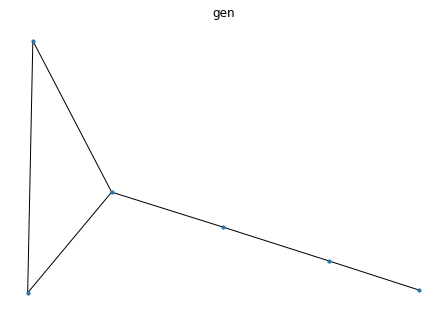

{'LCC': 6,
 'claw_count': 1.0,
 'cpl': 2.066666666666667,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': -0.023809523809523725,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 2.549906600843973,
 'rel_edge_distr_entropy': 0.8983485320836201,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 7.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


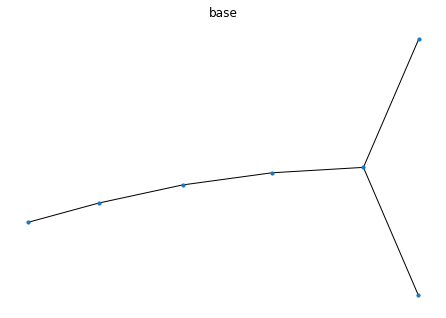

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 1, 1.0, 0.0, 1, 0, 0.6527, 0.0476, 0.0594, 1, 0.4095])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


{'LCC': 7,
 'claw_count': 21.0,
 'cpl': 1.5555555555555556,
 'd': 2.0,
 'd_max': 6.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.16666666666666674,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.5604486215510875,
 'rel_edge_distr_entropy': 0.9039246505324015,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 24.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 5, 4.0, 15.0, 3, 0, 0.5024, 0.0139, 0.0016, 2, 0.8687])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


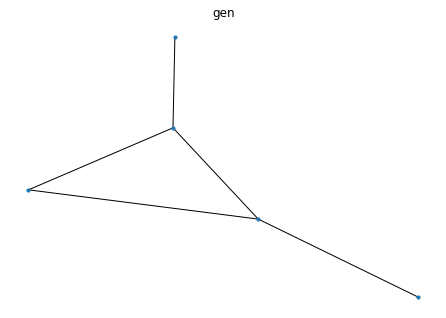

{'LCC': 5,
 'claw_count': 2.0,
 'cpl': 1.6,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 5,
 'gini': 0.033333333333333215,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 2.7298812813059676,
 'rel_edge_distr_entropy': 0.8398103860894132,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 7.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


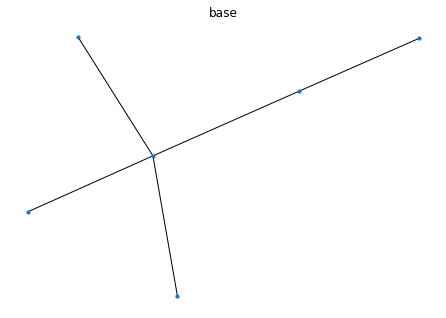

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 1, 0.0, 2.0, 1, 0, 1.1555, 0.0667, 0.0584, 1, 0.2667])
Testing set
Is there DIAG??  0.0


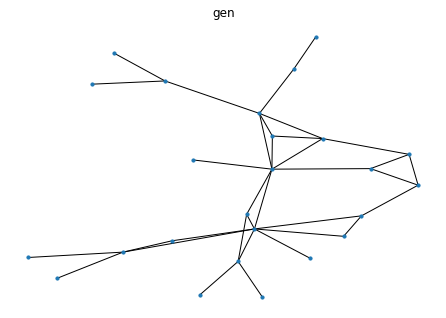

{'LCC': 25,
 'claw_count': 119.99999999999999,
 'cpl': 3.0866666666666664,
 'd': 2.2666667,
 'd_max': 8.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.392156862745098,
 'n_components': 6,
 'node_num': 30,
 'power_law_exp': 2.27789646390454,
 'rel_edge_distr_entropy': 0.8853051827677009,
 'square_count': 1,
 'triangle_count': 9,
 'wedge_count': 101.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


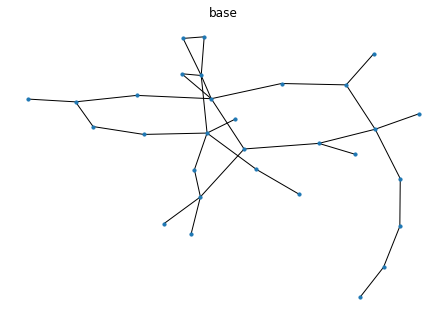

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 5, 35.0, 78.0, 7, 1, 0.199, 0.1725, 0.074, 5, 1.1041])
Is there DIAG??  0.0


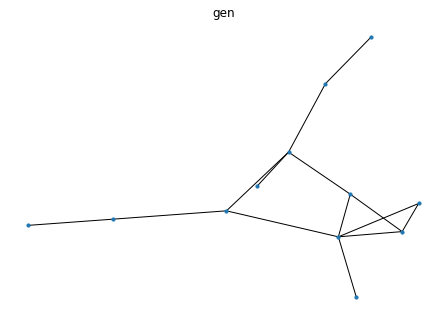

{'LCC': 12,
 'claw_count': 17.0,
 'cpl': 2.5757575757575757,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.125,
 'n_components': 1,
 'node_num': 12,
 'power_law_exp': 2.4335186582541883,
 'rel_edge_distr_entropy': 0.9437229556097568,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 28.0}
Is there DIAG on base??  0.0


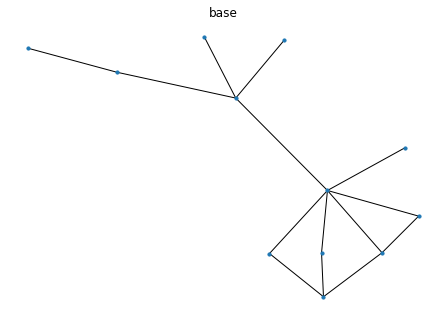

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 0, 3.0, 9.0, 1, 0, 0.0393, 0.0238, 0.0114, 0, 0.197])
Is there DIAG??  0.0


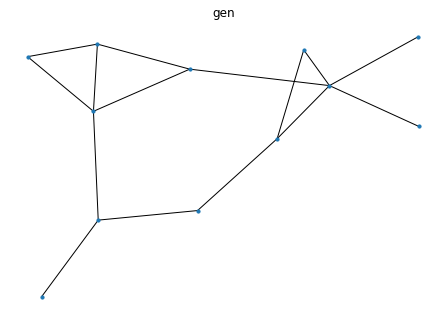

{'LCC': 12,
 'claw_count': 18.0,
 'cpl': 2.409090909090909,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.27555555555555555,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.2672099024570542,
 'rel_edge_distr_entropy': 0.8751699566458866,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 31.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


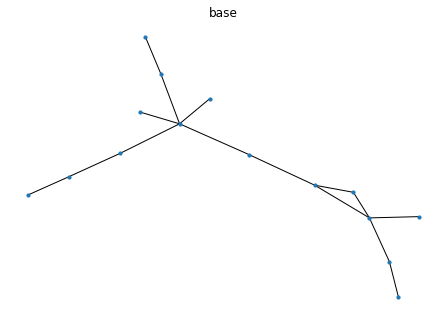

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 3, 6.0, 3.0, 2, 0, 0.5503, 0.12, 0.0705, 3, 1.0385])
Is there DIAG??  0.0


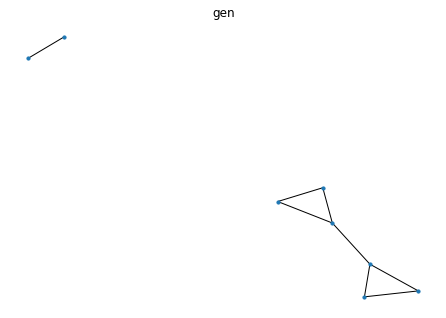

{'LCC': 6,
 'claw_count': 2.0,
 'cpl': 1.75,
 'd': 1.7777778,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.05555555555555558,
 'n_components': 3,
 'node_num': 9,
 'power_law_exp': 2.609718417527379,
 'rel_edge_distr_entropy': 0.9166043628966368,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 10.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


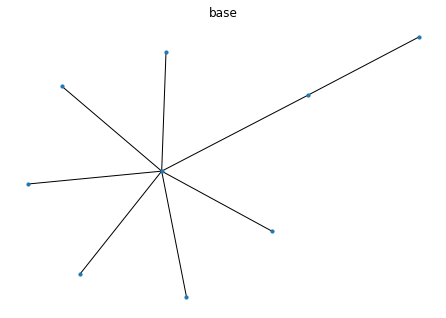

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 3, 12.0, 33.0, 2, 0, 1.8006, 0.0972, 0.0817, 2, 0.1944])
26 data training in total 
[27/30]: vae_loss:3.7764, prior_loss:0.1932
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


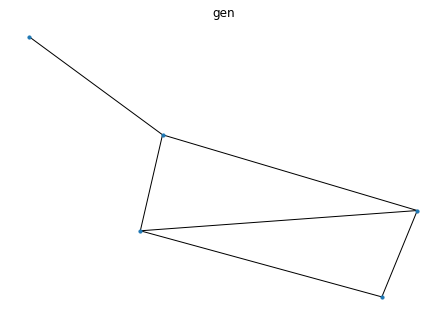

{'LCC': 5,
 'claw_count': 3.0,
 'cpl': 1.5,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': 0.11904761904761907,
 'n_components': 3,
 'node_num': 7,
 'power_law_exp': 2.253451992194984,
 'rel_edge_distr_entropy': 0.794168892305829,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 10.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


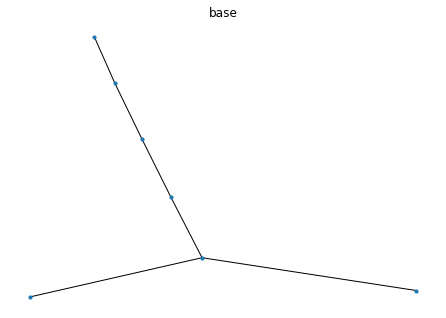

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 2, 4.0, 2.0, 2, 0, 0.9492, 0.1905, 0.1635, 2, 0.9762])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


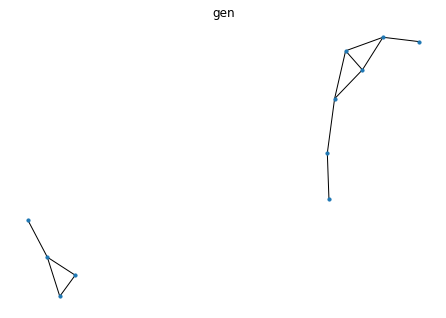

{'LCC': 7,
 'claw_count': 5.0,
 'cpl': 1.962962962962963,
 'd': 2.0,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.10416666666666674,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.452624055977231,
 'rel_edge_distr_entropy': 0.9328675465979728,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 18.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


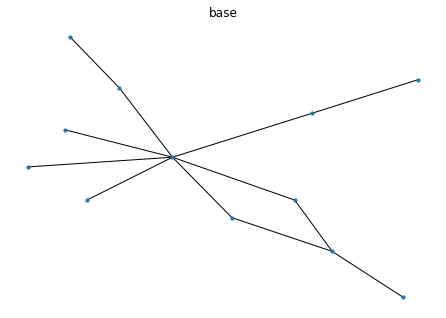

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([4.0, 1.0, 0.0, 0, 0, 5, 10.0, 31.0, 3, 0, 0.6103, 0.0764, 0.0306, 2, 0.4613])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


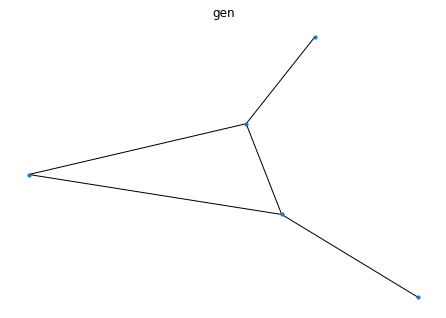

{'LCC': 5,
 'claw_count': 2.0,
 'cpl': 1.6,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 5,
 'gini': 0.033333333333333215,
 'n_components': 2,
 'node_num': 6,
 'power_law_exp': 2.7298812813059676,
 'rel_edge_distr_entropy': 0.8398103860894132,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 7.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


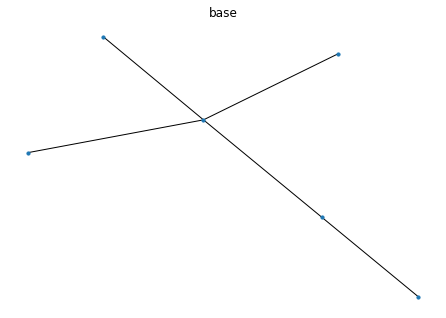

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 1, 0.0, 2.0, 1, 0, 1.1555, 0.0667, 0.0584, 1, 0.2667])
Testing set
Is there DIAG??  0.0


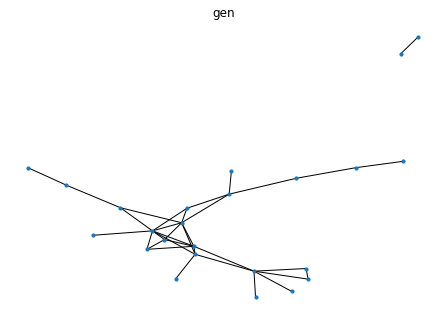

{'LCC': 22,
 'claw_count': 152.0,
 'cpl': 3.146551724137931,
 'd': 2.2666667,
 'd_max': 8.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.44509803921568625,
 'n_components': 8,
 'node_num': 30,
 'power_law_exp': 2.2798314013134773,
 'rel_edge_distr_entropy': 0.8613296989056206,
 'square_count': 3,
 'triangle_count': 15,
 'wedge_count': 115.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


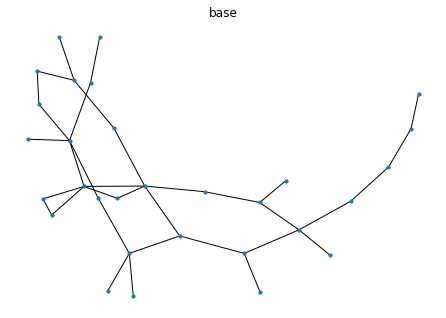

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 8, 49.0, 110.0, 13, 3, 0.197, 0.2255, 0.098, 7, 1.0443])
Is there DIAG??  0.0


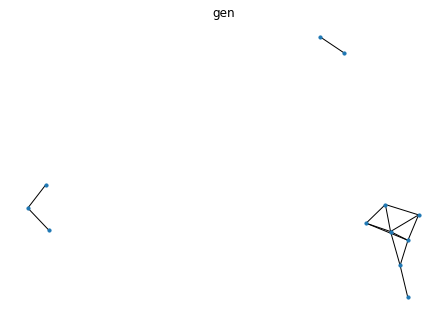

{'LCC': 7,
 'claw_count': 18.0,
 'cpl': 1.56,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.13690476190476208,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.484536950156437,
 'rel_edge_distr_entropy': 0.9362024618041915,
 'square_count': 0,
 'triangle_count': 5,
 'wedge_count': 29.0}
Is there DIAG on base??  0.0


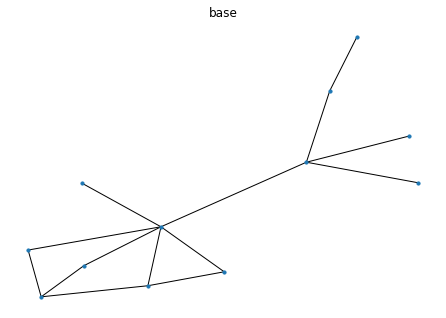

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 5, 2.0, 8.0, 4, 0, 0.0118, 0.0119, 0.0039, 2, 0.8188])
Is there DIAG??  0.0


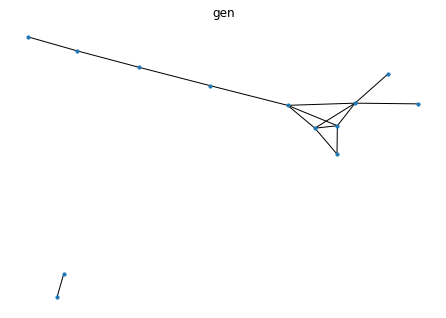

{'LCC': 11,
 'claw_count': 22.0,
 'cpl': 2.6964285714285716,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.27555555555555555,
 'n_components': 4,
 'node_num': 15,
 'power_law_exp': 2.522086104311743,
 'rel_edge_distr_entropy': 0.8838675833879743,
 'square_count': 1,
 'triangle_count': 5,
 'wedge_count': 32.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


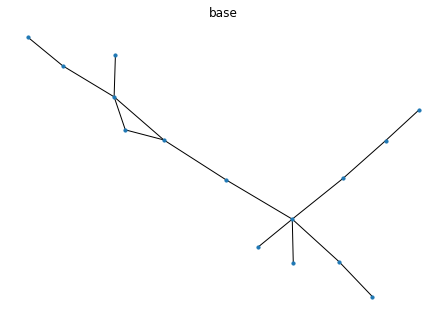

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 4, 7.0, 7.0, 4, 1, 0.2954, 0.12, 0.0618, 3, 0.7512])
Is there DIAG??  0.0


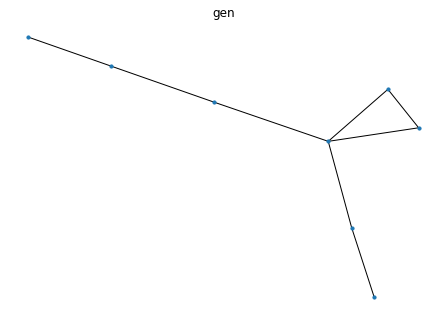

{'LCC': 8,
 'claw_count': 4.0,
 'cpl': 2.357142857142857,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.06944444444444442,
 'n_components': 2,
 'node_num': 9,
 'power_law_exp': 2.6487943324445298,
 'rel_edge_distr_entropy': 0.9069387092398873,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 11.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


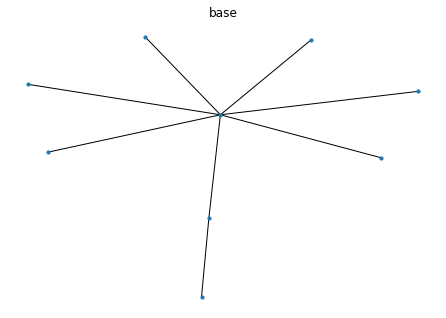

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 1, 11.0, 31.0, 1, 0, 1.7615, 0.0833, 0.072, 1, 0.4127])
26 data training in total 
[28/30]: vae_loss:3.8337, prior_loss:0.1536
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


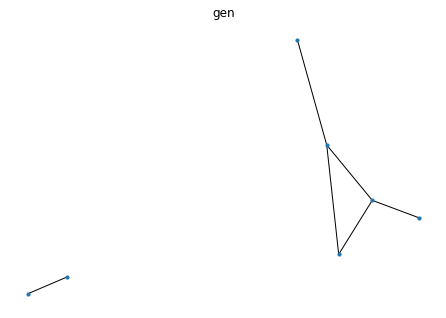

{'LCC': 5,
 'claw_count': 2.0,
 'cpl': 1.5454545454545454,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 6,
 'gini': -0.023809523809523725,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 3.421833793828355,
 'rel_edge_distr_entropy': 0.9353041380249751,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 7.0}
Is there DIAG on base??  0.0


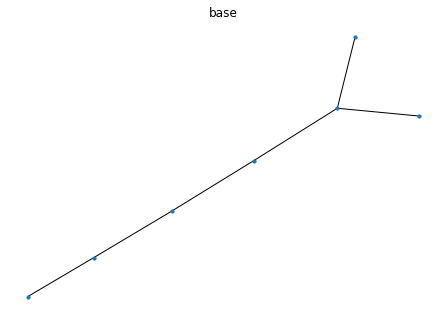

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 0.0, 0.0, 0, 0, 2, 1.0, 1.0, 1, 0, 0.2192, 0.0476, 0.0224, 1, 0.9307])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


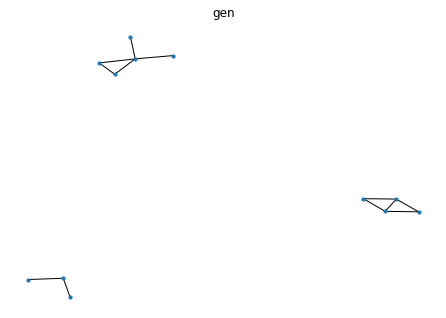

{'LCC': 5,
 'claw_count': 6.0,
 'cpl': 1.368421052631579,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 1.0,
 'edge_num': 12,
 'gini': 0.07638888888888906,
 'n_components': 3,
 'node_num': 12,
 'power_law_exp': 2.702307587146641,
 'rel_edge_distr_entropy': 0.959187164090173,
 'square_count': 0,
 'triangle_count': 3,
 'wedge_count': 17.0}
Is there DIAG on base??  0.0


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 0.0, 0.0, 0, 0, 7, 11.0, 30.0, 3, 0, 0.3606, 0.1042, 0.0569, 2, 1.0558])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


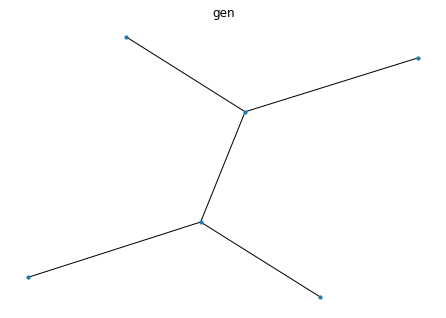

{'LCC': 6,
 'claw_count': 2.0,
 'cpl': 1.9333333333333333,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 1.0,
 'edge_num': 5,
 'gini': -0.06666666666666665,
 'n_components': 1,
 'node_num': 6,
 'power_law_exp': 3.730717679880512,
 'rel_edge_distr_entropy': 0.9171753590633354,
 'square_count': 0,
 'triangle_count': 0,
 'wedge_count': 6.0}
Is there DIAG on base??  0.0


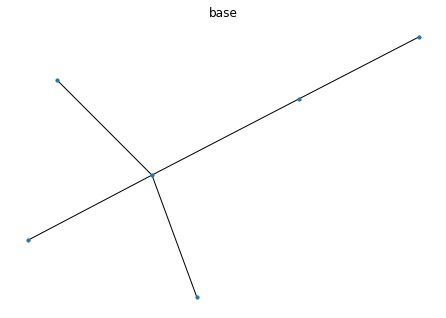

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 0, 1.0, 2.0, 0, 0, 0.1547, 0.0333, 0.019, 0, 0.0667])
Testing set
Is there DIAG??  0.0


{'LCC': 23,
 'claw_count': 84.0,
 'cpl': 2.960474308300395,
 'd': 2.2666667,
 'd_max': 6.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.3999999999999999,
 'n_components': 8,
 'node_num': 30,
 'power_law_exp': 2.1004308478421954,
 'rel_edge_distr_entropy': 0.8771751674521282,
 'square_count': 0,
 'triangle_count': 8,
 'wedge_count': 96.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 7, 30.0, 42.0, 6, 0, 0.3764, 0.1804, 0.0821, 7, 1.2303])
Is there DIAG??  0.0


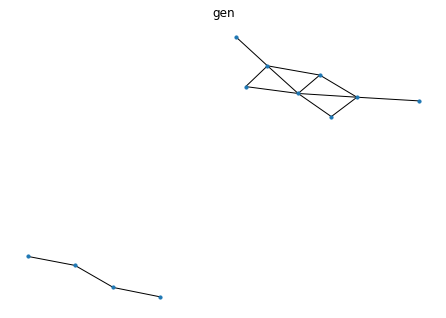

{'LCC': 8,
 'claw_count': 19.0,
 'cpl': 1.7941176470588236,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 1.0,
 'edge_num': 14,
 'gini': 0.13690476190476208,
 'n_components': 2,
 'node_num': 12,
 'power_law_exp': 2.4539766156121963,
 'rel_edge_distr_entropy': 0.9388391729147876,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 29.0}
Is there DIAG on base??  0.0


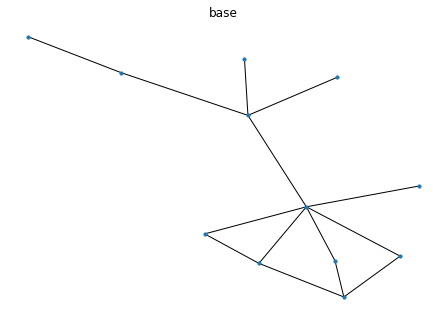

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 0.0, 0.0, 0, 0, 4, 2.0, 7.0, 3, 0, 0.0188, 0.0119, 0.0065, 1, 0.5847])
Is there DIAG??  0.0


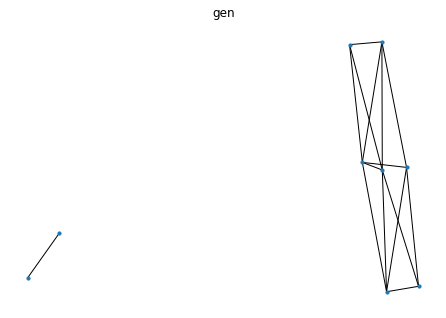

{'LCC': 7,
 'claw_count': 34.0,
 'cpl': 1.3181818181818181,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.4044444444444444,
 'n_components': 8,
 'node_num': 15,
 'power_law_exp': 1.939949401852131,
 'rel_edge_distr_entropy': 0.7719383864555409,
 'square_count': 1,
 'triangle_count': 9,
 'wedge_count': 44.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


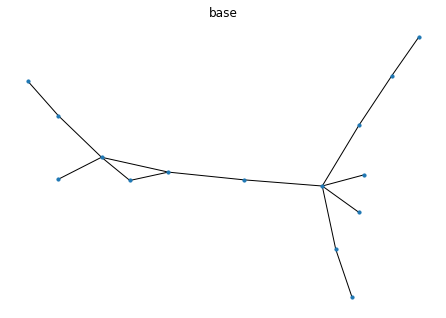

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 8, 19.0, 19.0, 8, 1, 0.8775, 0.2489, 0.1737, 7, 2.1294])
Is there DIAG??  0.0


{'LCC': 5,
 'claw_count': 4.0,
 'cpl': 1.3846153846153846,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.06944444444444442,
 'n_components': 3,
 'node_num': 9,
 'power_law_exp': 2.6487943324445298,
 'rel_edge_distr_entropy': 0.9069387092398873,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 11.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 4, 11.0, 31.0, 2, 0, 1.7615, 0.0833, 0.072, 2, 0.5598])
26 data training in total 
[29/30]: vae_loss:3.7056, prior_loss:0.1283
Training set
Base Adj_size:  (7, 7)
Show sample
Is there DIAG??  0.0


{'LCC': 6,
 'claw_count': 2.0,
 'cpl': 1.8666666666666667,
 'd': 1.7142857,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 6,
 'gini': 0.04761904761904767,
 'n_components': 2,
 'node_num': 7,
 'power_law_exp': 2.674331879653742,
 'rel_edge_distr_entropy': 0.8759405003843227,
 'square_count': 0,
 'triangle_count': 1,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


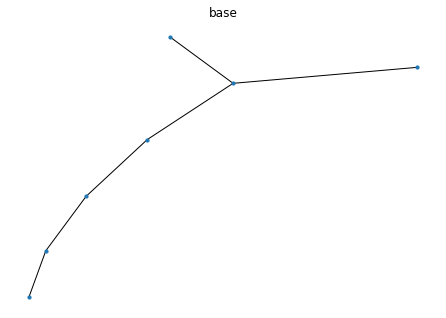

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 1, 2.0, 1.0, 1, 0, 0.5283, 0.119, 0.0818, 1, 0.6095])
Base Adj_size:  (12, 12)
Show sample
Is there DIAG??  0.0


{'LCC': 7,
 'claw_count': 10.0,
 'cpl': 1.7083333333333333,
 'd': 2.0,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 12,
 'gini': 0.19444444444444442,
 'n_components': 4,
 'node_num': 12,
 'power_law_exp': 2.291588834036644,
 'rel_edge_distr_entropy': 0.8894547376467273,
 'square_count': 0,
 'triangle_count': 4,
 'wedge_count': 22.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


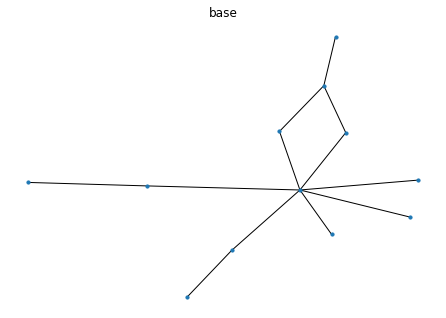

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 5, 6.0, 26.0, 4, 0, 0.7713, 0.0139, 0.0128, 3, 0.7159])
Base Adj_size:  (6, 6)
Show sample
Is there DIAG??  0.0


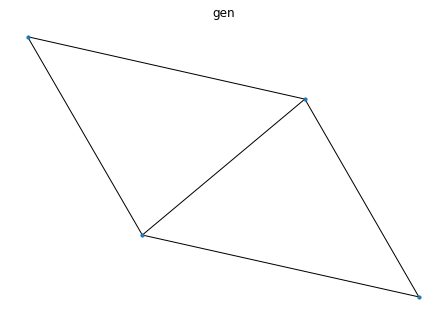

{'LCC': 4,
 'claw_count': 2.0,
 'cpl': 1.1666666666666667,
 'd': 1.6666666,
 'd_max': 3.0,
 'd_min': 0.0,
 'edge_num': 5,
 'gini': 0.06666666666666665,
 'n_components': 3,
 'node_num': 6,
 'power_law_exp': 2.1162212531024944,
 'rel_edge_distr_entropy': 0.7624454796474622,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 8.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 2, 1.0, 2.0, 2, 0, 1.7692, 0.1, 0.1358, 2, 0.7])
Testing set
Is there DIAG??  0.0


{'LCC': 25,
 'claw_count': 104.0,
 'cpl': 3.169435215946844,
 'd': 2.2666667,
 'd_max': 7.0,
 'd_min': 0.0,
 'edge_num': 34,
 'gini': 0.3715686274509802,
 'n_components': 5,
 'node_num': 30,
 'power_law_exp': 2.4673714119687613,
 'rel_edge_distr_entropy': 0.8999314294105721,
 'square_count': 2,
 'triangle_count': 9,
 'wedge_count': 96.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


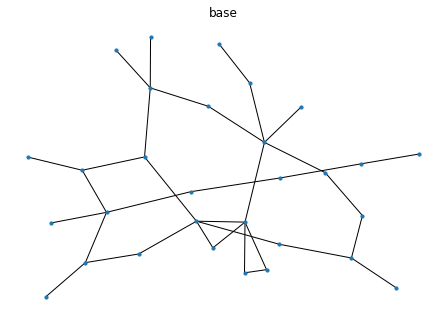

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([2.0, 1.0, 0.0, 0, 0, 5, 30.0, 62.0, 7, 2, 0.0095, 0.152, 0.0594, 4, 1.0214])
Is there DIAG??  0.0


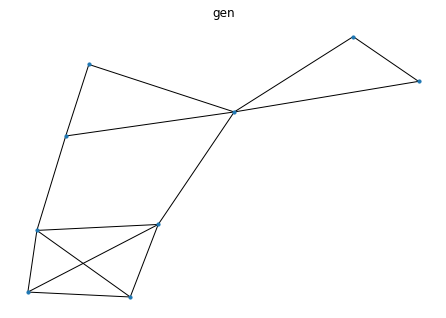

{'LCC': 9,
 'claw_count': 21.0,
 'cpl': 1.8333333333333333,
 'd': 2.3333333,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 14,
 'gini': 0.2142857142857144,
 'n_components': 4,
 'node_num': 12,
 'power_law_exp': 1.9223858392178514,
 'rel_edge_distr_entropy': 0.8640292474002474,
 'square_count': 1,
 'triangle_count': 6,
 'wedge_count': 34.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


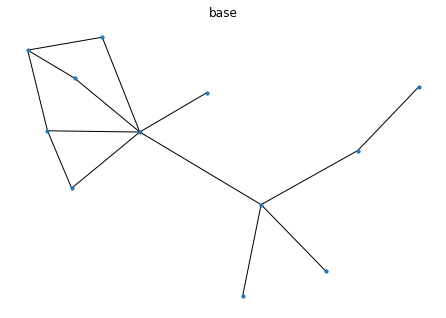

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([1.0, 1.0, 0.0, 0, 0, 3, 3.0, 5.0, 5, 1, 0.5504, 0.0655, 0.0683, 3, 0.5455])
Is there DIAG??  0.0


{'LCC': 11,
 'claw_count': 27.0,
 'cpl': 2.2545454545454544,
 'd': 2.0,
 'd_max': 5.0,
 'd_min': 0.0,
 'edge_num': 15,
 'gini': 0.3466666666666667,
 'n_components': 5,
 'node_num': 15,
 'power_law_exp': 2.1844129430826493,
 'rel_edge_distr_entropy': 0.8337508669380983,
 'square_count': 1,
 'triangle_count': 6,
 'wedge_count': 37.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


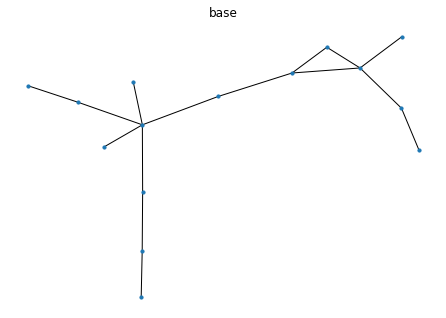

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([0.0, 1.0, 0.0, 0, 0, 4, 12.0, 12.0, 5, 1, 0.6331, 0.1911, 0.1119, 4, 1.1931])
Is there DIAG??  0.0


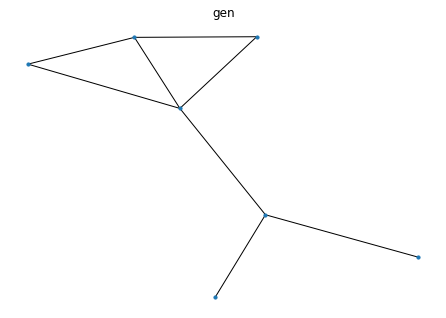

{'LCC': 7,
 'claw_count': 6.0,
 'cpl': 1.9047619047619047,
 'd': 1.7777778,
 'd_max': 4.0,
 'd_min': 0.0,
 'edge_num': 8,
 'gini': 0.19444444444444442,
 'n_components': 3,
 'node_num': 9,
 'power_law_exp': 2.408503615336456,
 'rel_edge_distr_entropy': 0.8377409104622672,
 'square_count': 0,
 'triangle_count': 2,
 'wedge_count': 14.0}
Is there DIAG on base??  0.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


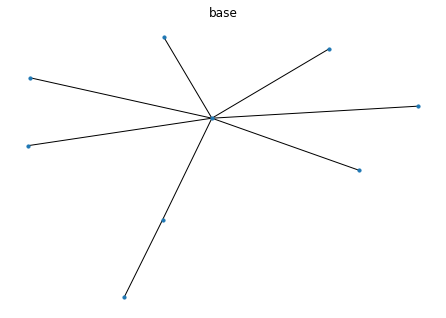

dict_keys(['d_max', 'd_min', 'd', 'node_num', 'edge_num', 'LCC', 'wedge_count', 'claw_count', 'triangle_count', 'square_count', 'power_law_exp', 'gini', 'rel_edge_distr_entropy', 'n_components', 'cpl'])
dict_values([3.0, 1.0, 0.0, 0, 0, 2, 8.0, 29.0, 2, 0, 2.0018, 0.0417, 0.0028, 2, 0.0397])


In [0]:
## Implement VAE/GAE Here to check the results
import random
av_size = 10  # set 0 if you do not need attr_vec
z_size = 6
d_size = 2
gc_size = 16
rep_size = 16
z_out_size = z_size + av_size

adj_thresh = .5
max_epochs = 30
lr = 0.005


beta = 5
alpha = 0.1
gamma = 15

G = Generator(
    av_size=av_size,
    d_size=d_size,
    gc_size=gc_size,
    z_size=z_size,
    z_out_size=z_out_size,
    rep_size=rep_size
).cuda()

criterion_bce = nn.BCELoss()
criterion_bce.cuda()

loss_MSE = nn.MSELoss()
loss_MSE.cuda()   
loss_BCE = nn.BCELoss()
loss_BCE.cuda()      
  
opt_vae = optim.Adam(G.parameters(), lr=lr)

training_index = list(range(0, len(train_adj_mats)))

for epoch in range(max_epochs):
    D_real_list, D_rec_enc_list, D_rec_noise_list, D_list = [], [], [], []
    # g_loss_list, rec_loss_list, prior_loss_list = [], [], []
    g_loss_list, rec_loss_list, prior_loss_list, aa_loss_list = [], [], [], []
    # Only train the 8th graph
    # for i in range(8, 9): 
    ct = 0
    
    training_list = []
    random.shuffle(training_index)
    for i in training_index:
        ones_label = Variable(torch.ones(1)).cuda()
        zeros_label = Variable(torch.zeros(1)).cuda()
        edge_num = np.sum(train_adj_mats[i])
        
        e = int(np.sum(train_adj_mats[i]) // 2)
        # adj = Variable(train_adj_mats[i]).cuda()
        adj = Variable(torch.from_numpy(train_adj_mats[i]).float()).cuda()
        
        # if adj.shape[0] <= d_size+2
        if adj.shape[0] < d_size+2 or adj.shape[0]>50:
            continue
        ct += 1
        training_list.append(i)
        if av_size == 0:
            attr_vec = None
        else:
            #attr_vec = Variable(train_attr_vecs[i]).cuda()
            attr_vec = Variable(torch.from_numpy(train_attr_vecs[i]).float()).cuda()
        G.set_attr_vec(attr_vec)

        
        norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
        pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
        # print('pos_weight', pos_weight)
        mean, logvar, rec_adj = G(adj, training=True)
        
        noisev = torch.randn(mean.shape, requires_grad=True).cuda()
        noisev = cat_attr(noisev, attr_vec)
        rec_noise = G.decoder(noisev)
       

        c_adj = topk_adj(F.sigmoid(rec_adj), e*2)
        aa_loss = loss_BCE(c_adj, adj)
        
        loss_BCE_logits = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss_BCE_logits.cuda()
        aa_loss = loss_BCE_logits(rec_adj, adj)
     
        pl = []
        for j in range(mean.size()[0]):
            prior_loss = 1 + logvar[j, :] - mean[j, :].pow(2) - logvar[j, :].exp()
            prior_loss = (-0.5 * torch.sum(prior_loss))/torch.numel(mean[j, :].data)
            pl.append(prior_loss)
        prior_loss_list.append(sum(pl))
        kl_loss = sum(pl) # /torch.numel(mean[i, :].data)
        vae_loss = kl_loss + norm*aa_loss
        opt_vae.zero_grad()
        vae_loss.backward() #retain_graph=True
        opt_vae.step()
    print('%d data training in total '%ct)
    print('[%d/%d]: vae_loss:%.4f, prior_loss:%.4f' 
                   % (epoch, 
                      max_epochs, 
                      torch.mean(torch.stack([vae_loss])),
                      torch.mean(torch.stack(prior_loss_list))))
    print('Training set')
    for i in range(10):  
        base_adj = train_adj_mats[i]
        
        if base_adj.shape[0] <= d_size + 2 or base_adj.shape[0] >50:
            continue
        print('Base Adj_size: ',base_adj.shape)
        attr_vec = Variable(torch.from_numpy(train_attr_vecs[i]).float()).cuda()
        # add a new line
        G.set_attr_vec(attr_vec)
        print('Show sample')
        sample_adj = gen_adj(G, base_adj.shape[0], int(np.sum(base_adj)) // 2, attr_vec)
        show_graph(sample_adj, base_adj=base_adj, remove_isolated=True)

    # test testing set
    print('Testing set')
    for i in range(10):
        base_adj = test_adj_mats[i]
        if base_adj.shape[0] <= d_size + 2 or base_adj.shape[0] >50:
            continue
        attr_vec = Variable(torch.from_numpy(test_attr_vecs[i]).float()).cuda()
        rec_adj = gen_adj(G, base_adj.shape[0], int(np.sum(base_adj)) // 2, attr_vec)
        show_graph(rec_adj, base_adj=base_adj, remove_isolated=True)


In [0]:
print(len(training_list))

26


In [0]:
#### EVAL
import math

def eval(adj, base_adj=None):
    if not isinstance(adj, np.ndarray):
        adj_ = adj.data.cpu().numpy()
    else:
        adj_ = copy.deepcopy(adj)
    
    adj_ -= np.diag(np.diag(adj_))
    gr = nx.from_numpy_array(adj_)
    assert((adj_ == adj_.T).all())

    d = compute_graph_statistics(adj_)
    # pprint(d)
    
    if base_adj is not None:
        # base_adj = base_adj.numpy()
        #base_adj = base_adj
        base_gr = nx.from_numpy_array(base_adj)
        bd = compute_graph_statistics(base_adj)
        diff_d = {}
        
        for k in list(d.keys()):
            diff_d[k] = round(abs(d[k] - bd[k]), 4)
    return diff_d


def gen_adj(model, n, e, attr_vec):
    fixed_noise = torch.randn((n, z_size), requires_grad=True).cuda()
    fixed_noise = cat_attr(fixed_noise, attr_vec)    
    rec_adj = model.decoder(fixed_noise)
    final_adj = topk_adj(rec_adj, e*2)
    return final_adj



def get_diffs(i):
    base_adj = train_adj_mats[i]

    # attr_vec = Variable(train_attr_vecs[i].float()).cuda()    
    attr_vec = Variable(torch.from_numpy(train_attr_vecs[i]).float()).cuda()
    # add a new line
    G.set_attr_vec(attr_vec)
    
    diff_d = {}
    sample_adj = gen_adj(G, base_adj.shape[0], int((base_adj).sum()) // 2, attr_vec)
    diff_d = eval(sample_adj, base_adj=base_adj)
    #if math.isnan(diff_d['cpl']):
    #diff_d = {}
    return diff_d
            
                
# Evaluation

diff_mix = {}
diff_seen = {}
diff_unseen = {}

for i in range(len(train_adj_mats)):
    for _ in range(3):
            # print('Graph %d'%i)  
            diff_d = get_diffs(i)   
            for k in list(diff_d.keys()):

                # Mix
                if k not in diff_mix.keys():
                    diff_mix[k] = []
                diff_mix[k].append(diff_d[k])

                #Seen
                if(i in training_list):
                    if k not in diff_seen.keys():
                        diff_seen[k] = []
                    diff_seen[k].append(diff_d[k])
                #Unseen
                else:
                    if k not in diff_unseen.keys():
                        diff_unseen[k] = []
                    diff_unseen[k].append(diff_d[k])


diffs = [diff_mix, diff_seen, diff_unseen]
for i in range(3):
    dif_mean_ = {}
    for k in list(diff_mix.keys()):  
        dif_mean[k] = np.mean(diffs[i][k])   
    if(i == 0):    
        print('MIX')
    if(i == 1):    
        print('SEEN')
    if(i == 2):    
        print('UNSEEN')    
    print(dif_mean)
    

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Not enough data. Returning nan
Not eno

MIX
{'d_max': 2.9615384615384617, 'd_min': 0.7884615384615384, 'd': 0.032051923076923075, 'node_num': 0.0, 'edge_num': 0.038461538461538464, 'LCC': 36.48076923076923, 'wedge_count': 528.7820512820513, 'claw_count': 3691.596153846154, 'triangle_count': 97.56410256410257, 'square_count': 63.37179487179487, 'power_law_exp': nan, 'gini': nan, 'rel_edge_distr_entropy': nan, 'n_components': 36.0, 'cpl': nan}
SEEN
{'d_max': 1.3205128205128205, 'd_min': 0.6923076923076923, 'd': 0.0, 'node_num': 0.0, 'edge_num': 0.0, 'LCC': 3.8461538461538463, 'wedge_count': 8.602564102564102, 'claw_count': 18.205128205128204, 'triangle_count': 3.6794871794871793, 'square_count': 0.7051282051282052, 'power_law_exp': 0.599175641025641, 'gini': 0.09507820512820511, 'rel_edge_distr_entropy': 0.06168333333333336, 'n_components': 3.1666666666666665, 'cpl': 0.6915461538461538}
UNSEEN
{'d_max': 4.602564102564102, 'd_min': 0.8846153846153846, 'd': 0.06410384615384615, 'node_num': 0.0, 'edge_num': 0.07692307692307693, '

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [0]:

dif_mean = {}
for k in list(diffs.keys()):  
    dif_mean[k] = np.mean(diffs[k])    
    #print('KEYS', k, 'MEAN: ', np.mean(diffs[k]), 'NOT MEAN: ', diffs[k])
    
print(dif_mean)

{'d_max': 2.9019607843137254, 'd_min': 0.8235294117647058, 'd': 0.013072549019607842, 'node_num': 0.0, 'edge_num': 0.0196078431372549, 'LCC': 36.96078431372549, 'wedge_count': 551.0522875816994, 'claw_count': 3540.346405228758, 'triangle_count': 98.77777777777777, 'square_count': 61.33986928104575, 'power_law_exp': inf, 'gini': 0.14133790849673203, 'rel_edge_distr_entropy': 0.06868823529411765, 'n_components': 36.55555555555556, 'cpl': 1.1033307189542483}


In [0]:

  
# for id_ in range(13):
#     for _ in range(5):
#         if(id_ == 9 or id_ == 12 ):
#             continue
#         print('Graph %d'%id_) 
#         test_gen(G, t_adj_mats[id_].size()[0], t_attr_vecs[id_,:], twice_edge_num =int(t_adj_mats[id_].sum().numpy()))
